In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!apt-get install unrar
!unrar x "/content/drive/MyDrive/dataset.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_248.TIFF      79%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_252.TIFF      79%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_256.TIFF      79%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_260.TIFF      79%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_264.TIFF      80%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_268.TIFF      80%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_272.TIFF      80%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_276.TIFF      80%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_28.TIFF      80%  OK 
Extracting  /content/dataset/images/test7Original_RGATE_G_1001_DS_28

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

In [7]:
IMAGE_PATH = '/content/dataset/images/'
MASK_PATH = '/content/dataset/masks/'

In [8]:
n_classes = 2

def create_df(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in sorted(filenames):  # Sort the filenames
            index_name = (filename.split('.')[0])
            index = index_name
            name.append(index)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df(IMAGE_PATH)
df_mask = create_df(MASK_PATH)

print('Total Images: ', len(df))
print('Total Images: ', len(df_mask))

Total Images:  4560
Total Images:  4560


In [ ]:
df.head()

id
0    Original_SGATE_G_1001_DS_0
1  Original_SGATE_G_1001_DS_100
2  Original_SGATE_G_1001_DS_104
3  Original_SGATE_G_1001_DS_108
4  Original_SGATE_G_1001_DS_112

In [ ]:
df_mask.head()

id
0    ground_SGATE_G_1001_DS_0
1  ground_SGATE_G_1001_DS_100
2  ground_SGATE_G_1001_DS_104
3  ground_SGATE_G_1001_DS_108
4  ground_SGATE_G_1001_DS_112

In [ ]:
print(df['id'][0])
print(df_mask['id'][0])

Original_SGATE_G_1001_DS_0
ground_SGATE_G_1001_DS_0


In [9]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming df and df_mask are already defined and hold your data
X = df['id'].values
X_mask = df_mask['id'].values

# Parameters
n_splits = 5  # Number of desired folds
test_size = 0.1

# First, create an index for the entire dataset
kf = KFold(n_splits=n_splits, shuffle=True, random_state=19)

# Define lists to hold the splits
train_indices = []
val_indices = []

# Separate data into folds, reserving some for testing
for train_index, val_index in kf.split(X):
    train_indices.append(train_index)
    val_indices.append(val_index)

# Now we will also separate the test data (you will decide how to do this)
test_size = int(len(X) * 0.1)
remaining_size = len(X) - test_size

# If you want to use the first folds for training/validation/test
X_test, X_trainval = X[:test_size], X[test_size:]

# Now we will perform k-fold cross-validation on the training/validation set
kf_trainval = KFold(n_splits=n_splits, shuffle=True, random_state=19)

for train_index, val_index in kf_trainval.split(X_trainval):
    X_train, X_val = X_trainval[train_index], X_trainval[val_index]

# For masks, we can apply the same k-fold strategy
kf_mask = KFold(n_splits=n_splits, shuffle=True, random_state=19)

# Split mask data in the same way
train_mask_indices = []
val_mask_indices = []

for train_mask_index, val_mask_index in kf_mask.split(X_mask):
    train_mask_indices.append(train_mask_index)
    val_mask_indices.append(val_mask_index)

# Split masks
X_test_mask, X_trainval_mask = X_mask[:test_size], X_mask[test_size:]

kf_trainval_mask = KFold(n_splits=n_splits, shuffle=True, random_state=19)

for train_mask_index, val_mask_index in kf_trainval_mask.split(X_trainval_mask):
    X_train_mask, X_val_mask = X_trainval_mask[train_mask_index], X_trainval_mask[val_mask_index]

# Print sizes
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

print('Train Size for Masks    : ', len(X_train_mask))
print('Val Size for Masks      : ', len(X_val_mask))
print('Test Size for Masks     : ', len(X_test_mask))

Train Size   :  3284
Val Size     :  820
Test Size    :  456
Train Size for Masks    :  3284
Val Size for Masks      :  820
Test Size for Masks     :  456


Image Size (64, 64)
Mask Size (64, 64)


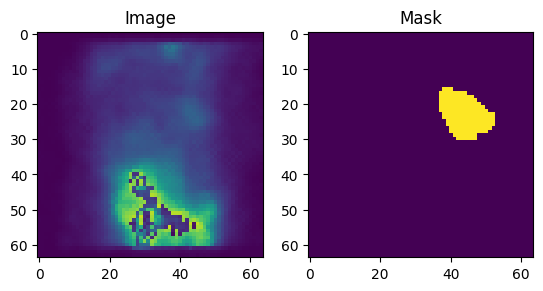

Image Size (64, 64)
Mask Size (64, 64)


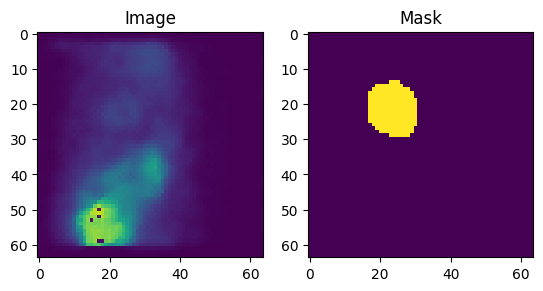

Image Size (64, 64)
Mask Size (64, 64)


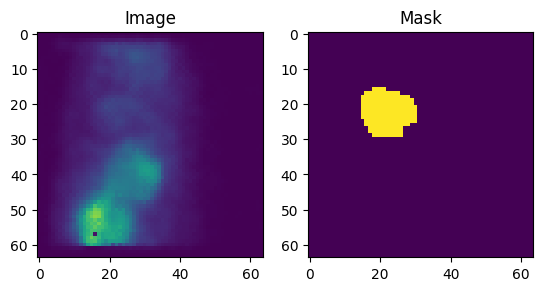

Image Size (64, 64)
Mask Size (64, 64)


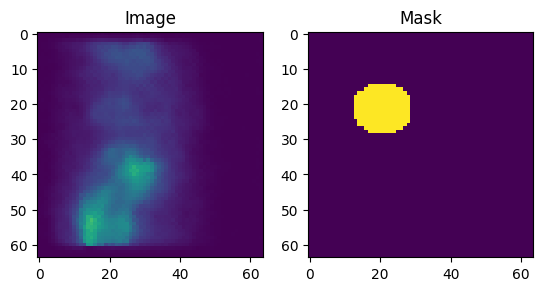

Image Size (64, 64)
Mask Size (64, 64)


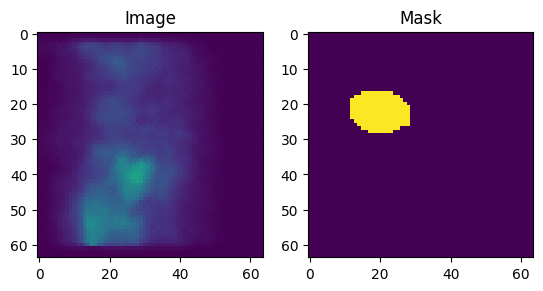

In [ ]:
for ind in range(5):
  img = Image.open(IMAGE_PATH + df['id'][ind] + '.TIFF')
  mask = Image.open(MASK_PATH + df_mask['id'][ind] + '.TIFF')
  print('Image Size', np.asarray(img).shape)
  print('Mask Size', np.asarray(mask).shape)

  img = plt.get_cmap('viridis')(img)
  mask= plt.get_cmap('viridis')(mask)
  fig, ax = plt.subplots(1, 2)
  # Display image
  ax[0].imshow(img)
  ax[0].set_title('Image')
  # Display mask
  ax[1].imshow(mask)
  ax[1].set_title('Mask')
  plt.show()

In [10]:
class SpectDataset(Dataset):

    def __init__(self, img_path, mask_path, X, Xmask, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.Xmask=Xmask
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.TIFF')
        #img[45:64, :] = 0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.Xmask[idx] + '.TIFF', cv2.IMREAD_GRAYSCALE)
        mask = mask / 255
        if img is None or mask is None:
          print(f"Image or mask at index {idx} could not be read.")
          return None
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
          img_patches = img.unfold(1, 32, 32).unfold(2, 32, 32)
          img_patches  = img_patches.contiguous().view(3,-1, 32, 32)
          img_patches = img_patches.permute(1,0,2,3)

          mask_patches = mask.unfold(0, 32, 32).unfold(1, 32, 32)
          mask_patches = mask_patches.contiguous().view(-1, 32, 32)

          return img_patches, mask_patches

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(64, 64, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(64, 64, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = SpectDataset(IMAGE_PATH, MASK_PATH, X_train,X_train_mask, mean, std, t_train, patch=False)
print(len(train_set))
val_set = SpectDataset(IMAGE_PATH, MASK_PATH, X_val,X_val_mask, mean, std, t_val, patch=False)
print(len(val_set))

#dataloader
batch_size= 128
num_workers = 2

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(len(train_loader))
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(len(val_loader))

3284
820
26
7


In [12]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3,padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta= tensor_size - target_size
    delta = delta//2
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNet(nn.Module):
    def __init__(self, num_channels, num_classes,retain_dim=True):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(num_channels, out_c=64)
        self.down_conv_2 = double_conv(in_c=64, out_c=128)
        self.down_conv_3 = double_conv(in_c=128, out_c=256)

        self.up_trans_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.up_conv_1 = double_conv(256, 128)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.up_conv_2 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels = num_classes, # Number of objects to segment
            kernel_size=1,
        )
        self.retain_dim = retain_dim

    def forward(self, image,out_size=(64, 64)):
        # encoder part
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)

        # decoder part
        x = self.up_trans_1(x5)
        y = crop_img(x3, x)
        x = self.up_conv_1(torch.cat([x, y], 1))

        x = self.up_trans_2(x)
        y = crop_img(x1, x)
        x = self.up_conv_2(torch.cat([x, y], 1))

        x = self.out(x)
        if self.retain_dim:
            x = F.interpolate(x, out_size)
        x = F.softmax(x, dim=1)
        return x


In [13]:
model = UNet(num_channels=3, num_classes=2)

In [14]:
!pip install torchviz graphviz
import torch
from torchviz import make_dot

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [15]:
model = UNet(num_channels=3, num_classes=2)

# Create a random tensor that matches the input size of your model
# Assuming your model takes input of shape (batch_size, num_channels, height, width)
input_tensor = torch.rand(1, 3, 64, 64)

# Forward pass through the model
output_tensor = model(input_tensor)

# Create a graph of the model
graph = make_dot(output_tensor, params=dict(model.named_parameters()))

# Render the graph using matplotlib
graph.format = 'png'
graph.render('model_architecture')

'model_architecture.png'

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=7):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
import torch.nn.functional as F
def segmentation_metrics(logits, targets, activation='0-1', eps=1e-7, reduction='mean'):
    ''' This method compute pixel_acc, iou, dice, precision, recall at the same time.
        If the task is mulit-class classification, i.e. logits.shape == [batch, classes, H, W],
        this method outputs the are averaged along the classes.
    '''
    # convert targets to one hot encoding
    if len(targets.shape) == len(logits.shape) - 1:
        if logits.shape[1] == 1:  # binary classification
            y_true = targets[:, None].to(logits.dtype)
        else:  # mulit-class classification
            y_true = F.one_hot(targets, num_classes=logits.shape[1])
            y_true = y_true.to(logits.dtype).to(logits.device)
            y_true = y_true[:, None].transpose(1, -1)[..., 0]
    else:
        y_true = targets.to(logits.dtype).to(logits.device)
    # logits to probability
    if activation == 'softmax':
        y_pred = torch.softmax(logits, dim=1)
    elif activation == 'sigmoid':
        y_pred = torch.sigmoid(logits)
    elif activation == '0-1':
        if logits.shape[1] == 1:  # binary classification
            y_pred = (logits > 0).to(logits.dtype).to(logits.device)
        else:  # mulit-class classification
            y_pred = torch.argmax(logits, axis=1)
            y_pred = F.one_hot(y_pred, num_classes=logits.shape[1])
            y_pred = y_pred.to(logits.dtype).to(logits.device)
            y_pred = y_pred[:, None].transpose(1, -1)[..., 0]

    axis = list(range(2, len(logits.shape)))  # height and width
    # compute true postive, false positive and false negative
    tp = torch.sum(y_true * y_pred, dim=axis)
    fp = torch.sum(y_pred, dim=axis) - tp
    fn = torch.sum(y_true, dim=axis) - tp

    if logits.shape[1] == 1:  # binary classification
        tn = torch.sum((1 - y_true) * (1 - y_pred), dim=axis)
        pixel_acc = (torch.sum(tp, dim=1) + torch.sum(tn, dim=1) + eps) / (torch.sum(tp, dim=1) + torch.sum(fp, dim=1) + torch.sum(fn, dim=1) + torch.sum(tn, dim=1) + eps)
    else:
        pixel_acc = (torch.sum(tp, dim=1) + eps) / (torch.sum(tp, dim=1) + torch.sum(fp, dim=1) + eps)
        tn = torch.sum((1 - y_true) * (1 - y_pred), dim=axis)
    iou = (tp + eps) / (fp + fn + tp + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    if reduction == 'mean':
        pixel_acc, iou, dice, precision, recall, tp , fn, fp, tn = pixel_acc.mean(), iou.mean(), dice.mean(), precision.mean(), recall.mean(), tp.mean(dim=0), fn.mean(dim=0), fp.mean(dim=0), tn.mean(dim=0)
    return iou, dice, precision, recall,pixel_acc, tp, fp, fn, tn

def compute_confusion_matrix_elements1(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        TP = 0; TN = 0; FP = 0; FN = 0
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                continue
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                sum_true_class = true_class.float().sum().item()
                sum_true_label = true_label.float().sum().item()

                TP += intersect
                FP += sum_true_class - intersect
                FN += sum_true_label - intersect
        TN = pred_mask.numel() - TP - FP - FN
        return TP, TN, FP, FN
def precision_score(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        TP = []; TN = []; FP = []; FN = []; precision_per_class=[]
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            TP.append(torch.logical_and(true_class, true_label).sum().item())
            TN.append(torch.logical_and(~true_class, ~true_label).sum().item())
            FP.append(torch.logical_and(true_class, ~true_label).sum().item())
            FN.append(torch.logical_and(~true_class, true_label).sum().item())
            precision_per_class.append(np.nanmean(TP)/(np.nanmean(TP)+np.nanmean(FP)))
        return np.nanmean(precision_per_class)

def precision_score1(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        precision_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                precision_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                sum_true_class = true_class.float().sum().item()

                precision = (intersect + smooth) / (sum_true_class + smooth)  # Precision formula
                precision_per_class.append(precision)
        return np.nanmean(precision_per_class)

def recall_score(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        recall_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                recall_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                sum_true_label = true_label.float().sum().item()

                recall = (intersect + smooth) / (sum_true_label + smooth)  # Recall formula
                recall_per_class.append(recall)
        return np.nanmean(recall_per_class)


def dice_score(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        dice_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                summing = (true_class.float() + true_label.float()).sum().item()
                dice = (2. * intersect + smooth) / (summing + smooth)  # Corrected the formula
                dice_per_class.append(dice)
        return np.nanmean(dice_per_class)


import pandas as pd


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    train_precision = []; val_precision = []
    train_recall = []; val_recall = []
    train_dice = []; val_dice = []  # Add Dice score
    train_TP=[]; val_TP=[];
    train_TN=[]; val_TN=[];
    train_FP=[]; val_FP=[];
    train_FN=[]; val_FN=[];
    model.to(device)
    fit_time = time.time()
    results = pd.DataFrame(columns=['Epoch', 'iou_score', 'accuracy', 'precision', 'recall', 'dice', 'val_iou_score', 'val_accuracy', 'vprecision', 'vrecall', 'vdice', 'TP', 'TN', 'FP', 'FN', 'TP2', 'TN2', 'FP2', 'FN2','val_TP', 'val_TN', 'val_FP', 'val_FN', 'val_TP2', 'val_TN2', 'val_FP2', 'val_FN2'])
    for e in range(epochs):
        # Initialize a DataFrame to store the results
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        jaccard = 0
        dice = 0
        precision = 0
        recall = 0
        TP=0; TN=0; FP=0; FN=0; TP2=0; TN2=0; FP2=0; FN2=0;
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            if data is None:
              continue
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            #iou_score += mIoU(output, mask)
            #accuracy += pixel_accuracy(output, mask)
            #precision += precision_score(output, mask)  # No need to convert to numpy
            #recall += recall_score(output, mask)
            #dice += dice_score(output, mask)  # No need to convert to numpy
            # Inside your training loop
            A,B,C,D,E,F,G,H,I = segmentation_metrics(output,mask)
            iou_score += A
            accuracy += E
            precision += C
            recall += D
            dice += B
            #A,B,C,D = compute_confusion_matrix_elements(output, mask)
            TP += F[0]
            TN += I[0]
            FP += G[0]
            FN += H[0]
            TP2 += F[1]
            TN2 += I[1]
            FP2 += G[1]
            FN2 += H[1]

            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            vjaccard = 0
            vdice = 0
            vprecision = 0
            vrecall = 0
            v_TP=0; v_TN=0; v_FP=0; v_FN=0; v_TP2=0; v_TN2=0; v_FP2=0; v_FN2=0;
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    #val_iou_score +=  mIoU(output, mask)
                    #test_accuracy += pixel_accuracy(output, mask)
                    #vprecision += precision_score(output, mask)
                    #vrecall += recall_score(output, mask)
                    #vdice += dice_score(output, mask)  # No need to convert to numpy
                    A,B,C,D,E,F,G,H,I = segmentation_metrics(output,mask)
                    val_iou_score +=  A
                    test_accuracy += E
                    vprecision += C
                    vrecall += D
                    vdice += B

                    #A,B,C,D = compute_confusion_matrix_elements(output, mask)
                    v_TP += F[0]
                    v_TN += I[0]
                    v_FP += G[0]
                    v_FN += H[0]
                    v_TP2 += F[1]
                    v_TN2 += I[1]
                    v_FP2 += G[1]
                    v_FN2 += H[1]
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 250:
                    print('Loss not decrease for 200 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            train_precision.append(precision/len(train_loader))  # Add Jaccard score
            train_recall.append(recall/len(train_loader))
            train_dice.append(dice/len(train_loader))  # Add Dice score
            val_precision.append(vprecision/len(val_loader))  # Add Jaccard score
            val_recall.append(vrecall/len(val_loader))
            val_dice.append(vdice/len(val_loader))  # Add Dice score

            val_TP.append(v_TP/len(val_loader))
            val_TN.append(v_TN/len(val_loader))
            val_FP.append(v_FP/len(val_loader))
            val_FN.append(v_FN/len(val_loader))
            train_TP.append(TP/len(train_loader))
            train_TN.append(TN/len(train_loader))
            train_FP.append(FP/len(train_loader))
            train_FN.append(FN/len(train_loader))

            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Dice:{:.3f}..".format(dice/len(train_loader)),
                  "Val Dice: {:.3f}..".format(vdice/len(val_loader)),
                  "Train Precision:{:.3f}..".format(precision/len(train_loader)),
                  "Val Precision: {:.3f}..".format(vprecision/len(val_loader)),
                  "Train Recall:{:.3f}..".format(recall/len(train_loader)),
                  "Val Recall: {:.3f}..".format(vrecall/len(val_loader)),

                  "Train TP:{:.3f}..".format(TP/len(train_loader)),
                  "Train TP2:{:.3f}..".format(TP2/len(train_loader)),
                  "Train TN:{:.3f}..".format(TN/len(train_loader)),
                  "Train TN2:{:.3f}..".format(TN2/len(train_loader)),
                  "Train FP:{:.3f}..".format(FP/len(train_loader)),
                  "Train FP2:{:.3f}..".format(FP2/len(train_loader)),
                  "Train FN:{:.3f}..".format(FN/len(train_loader)),
                  "Train FN2:{:.3f}..".format(FN2/len(train_loader)),


                  "Val TP: {:.3f}..".format(v_TP/len(val_loader)),
                  "Val TN: {:.3f}..".format(v_TN/len(val_loader)),
                  "Val FP: {:.3f}..".format(v_FP/len(val_loader)),
                  "Val FN: {:.3f}..".format(v_FN/len(val_loader)),


                  "Train Accuracy:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Accuracy:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
            results = results._append({'Epoch': epoch,
                                    'iou_score': (iou_score.item())/len(train_loader),
                                    'accuracy': (accuracy.item())/len(train_loader),
                                    'precision': (precision.item())/len(train_loader),
                                    'recall': (recall.item())/len(train_loader),
                                    'dice': (dice.item())/len(train_loader),
                                    'val_iou_score': (val_iou_score.item())/len(val_loader),
                                    'val_accuracy': (test_accuracy.item())/len(val_loader),
                                    'vprecision': (vprecision.item())/len(val_loader),
                                    'vrecall': (vrecall.item())/len(val_loader),
                                    'vdice': (vdice.item())/len(val_loader),
                                    'TP': (TP.item())/len(train_loader),
                                    'TN': (TN.item())/len(train_loader),
                                    'FP': (FP.item())/len(train_loader),
                                    'FN': (FN.item())/len(train_loader),
                                    'TP2':(TP2.item())/len(train_loader),
                                    'TN2':(TN2.item())/len(train_loader),
                                    'FP2':(FP2.item())/len(train_loader),
                                    'FN2':(FN2.item())/len(train_loader),
                                    'val_TP': (v_TP.item())/len(val_loader),
                                    'val_TN': (v_TN.item())/len(val_loader),
                                    'val_FP': (v_FP.item())/len(val_loader),
                                    'val_FN': (v_FN.item())/len(val_loader),
                                    'val_TP2':(v_TP2.item())/len(val_loader),
                                    'val_TN2':(v_TN2.item())/len(val_loader),
                                    'val_FP2':(v_FP2.item())/len(val_loader),
                                    'val_FN2':(v_FN2.item())/len(val_loader)
                                }, ignore_index=True)

    # Save the results to an Excel file
    results.to_excel('training_results.xlsx', index=False)
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_Precision' :train_precision, 'val_Precision':val_precision,
               'train_recall' :train_recall, 'val_recall':val_recall,
               'train_dice' :train_dice, 'val_dice':val_dice,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
# channels first format, get height, width axis
def identify_axis(shape):
    return list(range(2, len(shape)))

# convert to one hot encoding
def convert_prob(y_pred, y_true, activation):
    # convert to [batch, classes, ...]
    if len(y_true.shape) == len(y_pred.shape) - 1:
        if y_pred.shape[1] == 1: # binary classification
            y_true = y_true[:, None].to(y_pred.dtype)
        else:                    # mulit-class classification
            y_true = F.one_hot(y_true, num_classes=y_pred.shape[1])
            y_true = y_true.to(y_pred.dtype).to(y_pred.device)
            y_true = y_true[:, None].transpose(1, -1)[..., 0]
    if activation == 'softmax':
        y_pred = torch.softmax(y_pred, dim=1)
    elif activation == 'sigmoid':
        y_pred = torch.sigmoid(y_pred)
    return y_pred, y_true

def apply_reduction(tensor, reduction):
    if reduction == 'mean':
        tensor = torch.mean(tensor)
    elif reduction == 'sum':
        tensor = torch.sum(tensor)
    elif reduction == 'none':
        pass
    else:
        raise ValueError(f'Invalid reduction: {reduction}.')
    return tensor
def dice_coefficient(logits, targets, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    """The Dice similarity coefficient, also known as the Sørensen–Dice index or simply Dice coefficient, is a statistical tool which measures the similarity between two sets of data.
    Parameters
    ----------
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    y_pred, y_true = convert_prob(logits, targets, activation)
    axis = identify_axis(y_true.shape)

    intersection = (y_pred * y_true).sum(dim=axis)
    dice_class = (2.*intersection + smooth) / (y_pred.sum(dim=axis) + y_true.sum(dim=axis) + smooth)

    if reduction == 'none':
        return dice_class
    else: # Average class scores
        return apply_reduction(dice_class, reduction)
class DiceLoss(nn.Module):
    """Dice loss originates from Sørensen–Dice coefficient, which is a statistic developed in 1940s to gauge the similarity between two samples.

    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.5
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    def __init__(self, smooth = 0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return dice_loss(logits, targets, smooth=self.smooth,
                         activation=self.activation, reduction=self.reduction)

def dice_loss(logits, targets, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    dice_class = dice_coefficient(logits, targets, smooth=smooth,
                                  activation=activation, reduction='none')
    dice_class = 1 - dice_class
    return apply_reduction(dice_class, reduction)

################################
#       Tversky index       #
################################
def tversky_index(logits, targets, delta = 0.7, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    """Generalization of the Sørensen–Dice coefficient and the Jaccard index.
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    y_pred, y_true = convert_prob(logits, targets, activation)
    axis = identify_axis(y_true.shape)
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    tp = torch.sum(y_true * y_pred, dim=axis)
    fn = torch.sum(y_true * (1-y_pred), dim=axis)
    fp = torch.sum((1-y_true) * y_pred, dim=axis)
    tversky_class = (tp + smooth) / (tp + delta*fn + (1-delta)*fp + smooth)

    if reduction == 'none':
        return tversky_class
    else: # Average class scores
        return apply_reduction(tversky_class, reduction)
class TverskyLoss(nn.Module):
    """Tversky loss function for image segmentation using 3D fully convolutional deep networks
	Link: https://arxiv.org/abs/1706.05721
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    def __init__(self, delta = 0.7, smooth = 0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return tversky_loss(logits, targets, delta=self.delta, smooth=self.smooth,
                            activation=self.activation, reduction=self.reduction)

def tversky_loss(logits, targets, delta = 0.7, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    tversky_class = tversky_index(logits, targets, delta=delta, smooth=smooth,
                                  activation=activation, reduction='none')
    tversky_class = 1 - tversky_class
    return apply_reduction(tversky_class, reduction)

In [21]:
max_lr = 1e-4
epoch = 100
weight_decay = 1e-6

criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss(activation='softmax')
#criterion = TverskyLoss(activation='softmax')
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.670 
Epoch:1/100.. Train Loss: 0.667.. Val Loss: 0.670.. Train mIoU:0.342.. Val mIoU: 0.394.. Train Dice:0.431.. Val Dice: 0.479.. Train Precision:0.506.. Val Precision: 0.518.. Train Recall:0.534.. Val Recall: 0.585.. Train TP:2561.968.. Train TP2:72.139.. Train TN:72.139.. Train TN2:2561.968.. Train FP:108.338.. Train FP2:1353.555.. Train FN:1353.555.. Train FN2:108.338.. Val TP: 2914.556.. Val TN: 76.509.. Val FP: 107.695.. Val FN: 997.240.. Train Accuracy:0.643.. Val Accuracy:0.730.. Time: 0.20m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.670 >> 0.611 
Epoch:2/100.. Train Loss: 0.649.. Val Loss: 0.611.. Train mIoU:0.389.. Val mIoU: 0.444.. Train Dice:0.468.. Val Dice: 0.500.. Train Precision:0.514.. Val Precision: 0.509.. Train Recall:0.570.. Val Recall: 0.546.. Train TP:2915.280.. Train TP2:67.970.. Train TN:67.970.. Train TN2:2915.280.. Train FP:112.216.. Train FP2:1000.535.. Train FN:1000.535.. Train FN2:112.216.. Val TP: 3408.797.. Val TN: 38.516.. Val FP: 145.740.. Val FN: 502.947.. Train Accuracy:0.728.. Val Accuracy:0.842.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.611 >> 0.592 
Epoch:3/100.. Train Loss: 0.632.. Val Loss: 0.592.. Train mIoU:0.420.. Val mIoU: 0.453.. Train Dice:0.487.. Val Dice: 0.500.. Train Precision:0.512.. Val Precision: 0.504.. Train Recall:0.564.. Val Recall: 0.533.. Train TP:3186.877.. Train TP2:52.891.. Train TN:52.891.. Train TN2:3186.877.. Train FP:127.407.. Train FP2:728.825.. Train FN:728.825.. Train FN2:127.407.. Val TP: 3525.305.. Val TN: 27.760.. Val FP: 156.504.. Val FN: 386.431.. Train Accuracy:0.791.. Val Accuracy:0.867.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.592 >> 0.577 
saving model...
Epoch:4/100.. Train Loss: 0.613.. Val Loss: 0.577.. Train mIoU:0.445.. Val mIoU: 0.458.. Train Dice:0.499.. Val Dice: 0.496.. Train Precision:0.509.. Val Precision: 0.497.. Train Recall:0.549.. Val Recall: 0.517.. Train TP:3428.792.. Train TP2:35.878.. Train TN:35.878.. Train TN2:3428.792.. Train FP:144.561.. Train FP2:486.769.. Train FN:486.769.. Train FN2:144.561.. Val TP: 3621.688.. Val TN: 17.223.. Val FP: 167.306.. Val FN: 289.784.. Train Accuracy:0.846.. Val Accuracy:0.888.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.577 >> 0.558 
Epoch:5/100.. Train Loss: 0.592.. Val Loss: 0.558.. Train mIoU:0.456.. Val mIoU: 0.457.. Train Dice:0.497.. Val Dice: 0.487.. Train Precision:0.501.. Val Precision: 0.488.. Train Recall:0.527.. Val Recall: 0.499.. Train TP:3586.868.. Train TP2:20.385.. Train TN:20.385.. Train TN2:3586.868.. Train FP:159.664.. Train FP2:329.084.. Train FN:329.084.. Train FN2:159.664.. Val TP: 3673.085.. Val TN: 8.118.. Val FP: 175.938.. Val FN: 238.859.. Train Accuracy:0.881.. Val Accuracy:0.899.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.558 >> 0.542 
Epoch:6/100.. Train Loss: 0.569.. Val Loss: 0.542.. Train mIoU:0.461.. Val mIoU: 0.456.. Train Dice:0.489.. Val Dice: 0.481.. Train Precision:0.499.. Val Precision: 0.496.. Train Recall:0.506.. Val Recall: 0.489.. Train TP:3708.739.. Train TP2:6.845.. Train TN:6.845.. Train TN2:3708.739.. Train FP:172.880.. Train FP2:207.536.. Train FN:207.536.. Train FN2:172.880.. Val TP: 3710.513.. Val TN: 2.882.. Val FP: 180.639.. Val FN: 201.966.. Train Accuracy:0.907.. Val Accuracy:0.907.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.542 >> 0.522 
Epoch:7/100.. Train Loss: 0.544.. Val Loss: 0.522.. Train mIoU:0.466.. Val mIoU: 0.461.. Train Dice:0.485.. Val Dice: 0.481.. Train Precision:0.504.. Val Precision: 0.501.. Train Recall:0.500.. Val Recall: 0.488.. Train TP:3785.202.. Train TP2:1.603.. Train TN:1.603.. Train TN2:3785.202.. Train FP:178.926.. Train FP2:130.269.. Train FN:130.269.. Train FN2:178.926.. Val TP: 3753.894.. Val TN: 0.505.. Val FP: 183.108.. Val FN: 158.493.. Train Accuracy:0.925.. Val Accuracy:0.917.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.522 >> 0.494 
Epoch:8/100.. Train Loss: 0.519.. Val Loss: 0.494.. Train mIoU:0.474.. Val mIoU: 0.474.. Train Dice:0.489.. Val Dice: 0.488.. Train Precision:0.560.. Val Precision: 0.609.. Train Recall:0.504.. Val Recall: 0.499.. Train TP:3845.956.. Train TP2:0.190.. Train TN:0.190.. Train TN2:3845.956.. Train FP:179.306.. Train FP2:70.549.. Train FN:70.549.. Train FN2:179.306.. Val TP: 3851.862.. Val TN: 0.021.. Val FP: 184.278.. Val FN: 59.839.. Train Accuracy:0.939.. Val Accuracy:0.940.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.494 >> 0.490 
saving model...
Epoch:9/100.. Train Loss: 0.499.. Val Loss: 0.490.. Train mIoU:0.483.. Val mIoU: 0.472.. Train Dice:0.495.. Val Dice: 0.487.. Train Precision:0.782.. Val Precision: 0.760.. Train Recall:0.508.. Val Recall: 0.496.. Train TP:3878.529.. Train TP2:0.036.. Train TN:0.036.. Train TN2:3878.529.. Train FP:180.854.. Train FP2:36.582.. Train FN:36.582.. Train FN2:180.854.. Val TP: 3826.100.. Val TN: 0.045.. Val FP: 184.060.. Val FN: 85.796.. Train Accuracy:0.947.. Val Accuracy:0.934.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.490 >> 0.476 
Epoch:10/100.. Train Loss: 0.486.. Val Loss: 0.476.. Train mIoU:0.485.. Val mIoU: 0.478.. Train Dice:0.497.. Val Dice: 0.491.. Train Precision:0.899.. Val Precision: 0.863.. Train Recall:0.510.. Val Recall: 0.502.. Train TP:3892.450.. Train TP2:0.020.. Train TN:0.020.. Train TN2:3892.450.. Train FP:180.087.. Train FP2:23.443.. Train FN:23.443.. Train FN2:180.087.. Val TP: 3871.408.. Val TN: 0.009.. Val FP: 185.535.. Val FN: 39.048.. Train Accuracy:0.950.. Val Accuracy:0.945.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.476 >> 0.464 
Epoch:11/100.. Train Loss: 0.478.. Val Loss: 0.464.. Train mIoU:0.487.. Val mIoU: 0.483.. Train Dice:0.499.. Val Dice: 0.497.. Train Precision:0.908.. Val Precision: 0.901.. Train Recall:0.511.. Val Recall: 0.507.. Train TP:3895.132.. Train TP2:0.316.. Train TN:0.316.. Train TN2:3895.132.. Train FP:180.187.. Train FP2:20.365.. Train FN:20.365.. Train FN2:180.187.. Val TP: 3893.743.. Val TN: 0.843.. Val FP: 182.388.. Val FN: 19.026.. Train Accuracy:0.951.. Val Accuracy:0.951.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.464 >> 0.459 
Epoch:12/100.. Train Loss: 0.474.. Val Loss: 0.459.. Train mIoU:0.489.. Val mIoU: 0.492.. Train Dice:0.505.. Val Dice: 0.511.. Train Precision:0.860.. Val Precision: 0.894.. Train Recall:0.515.. Val Recall: 0.514.. Train TP:3877.870.. Train TP2:2.608.. Train TN:2.608.. Train TN2:3877.870.. Train FP:177.599.. Train FP2:37.923.. Train FN:37.923.. Train FN2:177.599.. Val TP: 3900.762.. Val TN: 3.289.. Val FP: 180.908.. Val FN: 11.041.. Train Accuracy:0.947.. Val Accuracy:0.953.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.459 >> 0.455 
Epoch:13/100.. Train Loss: 0.464.. Val Loss: 0.455.. Train mIoU:0.538.. Val mIoU: 0.588.. Train Dice:0.577.. Val Dice: 0.647.. Train Precision:0.838.. Val Precision: 0.820.. Train Recall:0.576.. Val Recall: 0.622.. Train TP:3887.139.. Train TP2:24.376.. Train TN:24.376.. Train TN2:3887.139.. Train FP:155.912.. Train FP2:28.573.. Train FN:28.573.. Train FN2:155.912.. Val TP: 3868.716.. Val TN: 44.447.. Val FP: 140.018.. Val FN: 42.820.. Train Accuracy:0.955.. Val Accuracy:0.955.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.455 >> 0.449 
saving model...
Epoch:14/100.. Train Loss: 0.455.. Val Loss: 0.449.. Train mIoU:0.599.. Val mIoU: 0.669.. Train Dice:0.655.. Val Dice: 0.739.. Train Precision:0.844.. Val Precision: 0.815.. Train Recall:0.647.. Val Recall: 0.727.. Train TP:3876.921.. Train TP2:51.060.. Train TN:51.060.. Train TN2:3876.921.. Train FP:130.056.. Train FP2:37.964.. Train FN:37.964.. Train FN2:130.056.. Val TP: 3853.293.. Val TN: 83.827.. Val FP: 101.130.. Val FN: 57.750.. Train Accuracy:0.959.. Val Accuracy:0.961.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.449 >> 0.441 
Epoch:15/100.. Train Loss: 0.447.. Val Loss: 0.441.. Train mIoU:0.656.. Val mIoU: 0.703.. Train Dice:0.724.. Val Dice: 0.776.. Train Precision:0.839.. Val Precision: 0.805.. Train Recall:0.719.. Val Recall: 0.792.. Train TP:3866.523.. Train TP2:77.062.. Train TN:77.062.. Train TN2:3866.523.. Train FP:102.971.. Train FP2:49.445.. Train FN:49.445.. Train FN2:102.971.. Val TP: 3832.833.. Val TN: 108.225.. Val FP: 75.610.. Val FN: 79.333.. Train Accuracy:0.963.. Val Accuracy:0.962.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.441 >> 0.431 
Epoch:16/100.. Train Loss: 0.439.. Val Loss: 0.431.. Train mIoU:0.703.. Val mIoU: 0.738.. Train Dice:0.774.. Val Dice: 0.806.. Train Precision:0.848.. Val Precision: 0.872.. Train Recall:0.773.. Val Recall: 0.796.. Train TP:3863.991.. Train TP2:96.984.. Train TN:96.984.. Train TN2:3863.991.. Train FP:83.201.. Train FP2:51.824.. Train FN:51.824.. Train FN2:83.201.. Val TP: 3868.910.. Val TN: 108.104.. Val FP: 76.289.. Val FN: 42.697.. Train Accuracy:0.967.. Val Accuracy:0.971.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.431 >> 0.423 
Epoch:17/100.. Train Loss: 0.431.. Val Loss: 0.423.. Train mIoU:0.732.. Val mIoU: 0.742.. Train Dice:0.803.. Val Dice: 0.811.. Train Precision:0.858.. Val Precision: 0.857.. Train Recall:0.808.. Val Recall: 0.816.. Train TP:3863.700.. Train TP2:110.267.. Train TN:110.267.. Train TN2:3863.700.. Train FP:70.229.. Train FP2:51.804.. Train FN:51.804.. Train FN2:70.229.. Val TP: 3854.719.. Val TN: 116.213.. Val FP: 68.694.. Val FN: 56.374.. Train Accuracy:0.970.. Val Accuracy:0.969.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.423 >> 0.420 
Epoch:18/100.. Train Loss: 0.426.. Val Loss: 0.420.. Train mIoU:0.744.. Val mIoU: 0.761.. Train Dice:0.814.. Val Dice: 0.828.. Train Precision:0.861.. Val Precision: 0.880.. Train Recall:0.823.. Val Recall: 0.826.. Train TP:3861.781.. Train TP2:115.768.. Train TN:115.768.. Train TN2:3861.781.. Train FP:64.462.. Train FP2:53.989.. Train FN:53.989.. Train FN2:64.462.. Val TP: 3863.970.. Val TN: 119.824.. Val FP: 65.303.. Val FN: 46.902.. Train Accuracy:0.971.. Val Accuracy:0.973.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.420 >> 0.417 
saving model...
Epoch:19/100.. Train Loss: 0.420.. Val Loss: 0.417.. Train mIoU:0.759.. Val mIoU: 0.793.. Train Dice:0.828.. Val Dice: 0.860.. Train Precision:0.871.. Val Precision: 0.894.. Train Recall:0.839.. Val Recall: 0.865.. Train TP:3865.925.. Train TP2:120.858.. Train TN:120.858.. Train TN2:3865.925.. Train FP:58.723.. Train FP2:50.494.. Train FN:50.494.. Train FN2:58.723.. Val TP: 3866.764.. Val TN: 134.109.. Val FP: 50.348.. Val FN: 44.779.. Train Accuracy:0.973.. Val Accuracy:0.977.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.417 >> 0.413 
Epoch:20/100.. Train Loss: 0.413.. Val Loss: 0.413.. Train mIoU:0.778.. Val mIoU: 0.775.. Train Dice:0.844.. Val Dice: 0.848.. Train Precision:0.878.. Val Precision: 0.827.. Train Recall:0.857.. Val Recall: 0.910.. Train TP:3868.051.. Train TP2:128.162.. Train TN:128.162.. Train TN2:3868.051.. Train FP:52.351.. Train FP2:47.437.. Train FN:47.437.. Train FN2:52.351.. Val TP: 3816.557.. Val TN: 153.880.. Val FP: 30.954.. Val FN: 94.609.. Train Accuracy:0.976.. Val Accuracy:0.969.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.413 >> 0.398 
Epoch:21/100.. Train Loss: 0.409.. Val Loss: 0.398.. Train mIoU:0.780.. Val mIoU: 0.807.. Train Dice:0.847.. Val Dice: 0.870.. Train Precision:0.877.. Val Precision: 0.908.. Train Recall:0.862.. Val Recall: 0.870.. Train TP:3865.843.. Train TP2:129.676.. Train TN:129.676.. Train TN2:3865.843.. Train FP:50.657.. Train FP2:49.824.. Train FN:49.824.. Train FN2:50.657.. Val TP: 3877.442.. Val TN: 135.745.. Val FP: 49.484.. Val FN: 33.329.. Train Accuracy:0.975.. Val Accuracy:0.980.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:22/100.. Train Loss: 0.403.. Val Loss: 0.403.. Train mIoU:0.791.. Val mIoU: 0.805.. Train Dice:0.856.. Val Dice: 0.870.. Train Precision:0.887.. Val Precision: 0.888.. Train Recall:0.870.. Val Recall: 0.886.. Train TP:3870.953.. Train TP2:132.680.. Train TN:132.680.. Train TN2:3870.953.. Train FP:47.899.. Train FP2:44.469.. Train FN:44.469.. Train FN2:47.899.. Val TP: 3860.567.. Val TN: 142.081.. Val FP: 42.732.. Val FN: 50.619.. Train Accuracy:0.977.. Val Accuracy:0.977.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.403 >> 0.392 
Epoch:23/100.. Train Loss: 0.398.. Val Loss: 0.392.. Train mIoU:0.801.. Val mIoU: 0.824.. Train Dice:0.863.. Val Dice: 0.885.. Train Precision:0.892.. Val Precision: 0.906.. Train Recall:0.878.. Val Recall: 0.892.. Train TP:3874.638.. Train TP2:135.043.. Train TN:135.043.. Train TN2:3874.638.. Train FP:44.946.. Train FP2:41.374.. Train FN:41.374.. Train FN2:44.946.. Val TP: 3872.496.. Val TN: 144.162.. Val FP: 40.854.. Val FN: 38.489.. Train Accuracy:0.979.. Val Accuracy:0.981.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.392 >> 0.390 
Epoch:24/100.. Train Loss: 0.393.. Val Loss: 0.390.. Train mIoU:0.809.. Val mIoU: 0.819.. Train Dice:0.871.. Val Dice: 0.879.. Train Precision:0.894.. Val Precision: 0.915.. Train Recall:0.888.. Val Recall: 0.881.. Train TP:3874.185.. Train TP2:139.192.. Train TN:139.192.. Train TN2:3874.185.. Train FP:41.564.. Train FP2:41.059.. Train FN:41.059.. Train FN2:41.564.. Val TP: 3878.309.. Val TN: 138.998.. Val FP: 45.414.. Val FN: 33.279.. Train Accuracy:0.980.. Val Accuracy:0.981.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.390 >> 0.386 
saving model...
Epoch:25/100.. Train Loss: 0.389.. Val Loss: 0.386.. Train mIoU:0.811.. Val mIoU: 0.832.. Train Dice:0.872.. Val Dice: 0.891.. Train Precision:0.899.. Val Precision: 0.902.. Train Recall:0.887.. Val Recall: 0.909.. Train TP:3877.274.. Train TP2:138.269.. Train TN:138.269.. Train TN2:3877.274.. Train FP:41.979.. Train FP2:38.478.. Train FN:38.478.. Train FN2:41.979.. Val TP: 3874.323.. Val TN: 148.796.. Val FP: 34.600.. Val FN: 38.280.. Train Accuracy:0.980.. Val Accuracy:0.982.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.386 >> 0.377 
Epoch:26/100.. Train Loss: 0.384.. Val Loss: 0.377.. Train mIoU:0.821.. Val mIoU: 0.835.. Train Dice:0.880.. Val Dice: 0.894.. Train Precision:0.903.. Val Precision: 0.921.. Train Recall:0.894.. Val Recall: 0.895.. Train TP:3879.528.. Train TP2:141.393.. Train TN:141.393.. Train TN2:3879.528.. Train FP:39.580.. Train FP2:35.500.. Train FN:35.500.. Train FN2:39.580.. Val TP: 3883.457.. Val TN: 144.384.. Val FP: 39.938.. Val FN: 28.221.. Train Accuracy:0.982.. Val Accuracy:0.983.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.377 >> 0.374 
Epoch:27/100.. Train Loss: 0.380.. Val Loss: 0.374.. Train mIoU:0.826.. Val mIoU: 0.842.. Train Dice:0.884.. Val Dice: 0.900.. Train Precision:0.908.. Val Precision: 0.916.. Train Recall:0.898.. Val Recall: 0.908.. Train TP:3882.300.. Train TP2:142.563.. Train TN:142.563.. Train TN2:3882.300.. Train FP:37.927.. Train FP2:33.211.. Train FN:33.211.. Train FN2:37.927.. Val TP: 3880.719.. Val TN: 149.297.. Val FP: 35.044.. Val FN: 30.940.. Train Accuracy:0.983.. Val Accuracy:0.984.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.374 >> 0.372 
Epoch:28/100.. Train Loss: 0.376.. Val Loss: 0.372.. Train mIoU:0.827.. Val mIoU: 0.832.. Train Dice:0.884.. Val Dice: 0.890.. Train Precision:0.913.. Val Precision: 0.928.. Train Recall:0.895.. Val Recall: 0.889.. Train TP:3885.264.. Train TP2:141.521.. Train TN:141.521.. Train TN2:3885.264.. Train FP:38.963.. Train FP2:30.253.. Train FN:30.253.. Train FN2:38.963.. Val TP: 3888.573.. Val TN: 140.957.. Val FP: 42.615.. Val FN: 23.855.. Train Accuracy:0.983.. Val Accuracy:0.984.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.372 >> 0.367 
Epoch:29/100.. Train Loss: 0.373.. Val Loss: 0.367.. Train mIoU:0.837.. Val mIoU: 0.843.. Train Dice:0.893.. Val Dice: 0.899.. Train Precision:0.917.. Val Precision: 0.933.. Train Recall:0.904.. Val Recall: 0.896.. Train TP:3887.071.. Train TP2:144.171.. Train TN:144.171.. Train TN2:3887.071.. Train FP:35.789.. Train FP2:28.970.. Train FN:28.970.. Train FN2:35.789.. Val TP: 3889.958.. Val TN: 144.516.. Val FP: 38.830.. Val FN: 22.696.. Train Accuracy:0.984.. Val Accuracy:0.985.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.367 >> 0.366 
saving model...
Epoch:30/100.. Train Loss: 0.370.. Val Loss: 0.366.. Train mIoU:0.839.. Val mIoU: 0.855.. Train Dice:0.895.. Val Dice: 0.909.. Train Precision:0.920.. Val Precision: 0.938.. Train Recall:0.905.. Val Recall: 0.907.. Train TP:3887.586.. Train TP2:144.622.. Train TN:144.622.. Train TN2:3887.586.. Train FP:35.689.. Train FP2:28.104.. Train FN:28.104.. Train FN2:35.689.. Val TP: 3890.242.. Val TN: 148.516.. Val FP: 35.922.. Val FN: 21.320.. Train Accuracy:0.984.. Val Accuracy:0.986.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.366 >> 0.362 
Epoch:31/100.. Train Loss: 0.367.. Val Loss: 0.362.. Train mIoU:0.842.. Val mIoU: 0.851.. Train Dice:0.897.. Val Dice: 0.905.. Train Precision:0.920.. Val Precision: 0.943.. Train Recall:0.907.. Val Recall: 0.895.. Train TP:3888.760.. Train TP2:145.255.. Train TN:145.255.. Train TN2:3888.760.. Train FP:34.831.. Train FP2:27.154.. Train FN:27.154.. Train FN2:34.831.. Val TP: 3893.650.. Val TN: 144.045.. Val FP: 40.656.. Val FN: 17.649.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:32/100.. Train Loss: 0.364.. Val Loss: 0.363.. Train mIoU:0.846.. Val mIoU: 0.853.. Train Dice:0.901.. Val Dice: 0.908.. Train Precision:0.922.. Val Precision: 0.932.. Train Recall:0.910.. Val Recall: 0.910.. Train TP:3888.293.. Train TP2:146.651.. Train TN:146.651.. Train TN2:3888.293.. Train FP:33.914.. Train FP2:27.142.. Train FN:27.142.. Train FN2:33.914.. Val TP: 3888.700.. Val TN: 149.665.. Val FP: 34.540.. Val FN: 23.096.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.363 >> 0.361 
Epoch:33/100.. Train Loss: 0.362.. Val Loss: 0.361.. Train mIoU:0.847.. Val mIoU: 0.861.. Train Dice:0.901.. Val Dice: 0.915.. Train Precision:0.923.. Val Precision: 0.926.. Train Recall:0.910.. Val Recall: 0.923.. Train TP:3889.102.. Train TP2:146.561.. Train TN:146.561.. Train TN2:3889.102.. Train FP:33.977.. Train FP2:26.360.. Train FN:26.360.. Train FN2:33.977.. Val TP: 3884.390.. Val TN: 155.485.. Val FP: 29.738.. Val FN: 26.387.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.361 >> 0.360 
Epoch:34/100.. Train Loss: 0.360.. Val Loss: 0.360.. Train mIoU:0.849.. Val mIoU: 0.863.. Train Dice:0.903.. Val Dice: 0.916.. Train Precision:0.925.. Val Precision: 0.921.. Train Recall:0.912.. Val Recall: 0.930.. Train TP:3889.319.. Train TP2:147.234.. Train TN:147.234.. Train TN2:3889.319.. Train FP:33.397.. Train FP2:26.050.. Train FN:26.050.. Train FN2:33.397.. Val TP: 3882.005.. Val TN: 158.467.. Val FP: 26.738.. Val FN: 28.790.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.360 >> 0.355 
Epoch:35/100.. Train Loss: 0.358.. Val Loss: 0.355.. Train mIoU:0.851.. Val mIoU: 0.860.. Train Dice:0.905.. Val Dice: 0.913.. Train Precision:0.925.. Val Precision: 0.931.. Train Recall:0.913.. Val Recall: 0.917.. Train TP:3889.526.. Train TP2:147.939.. Train TN:147.939.. Train TN2:3889.526.. Train FP:32.727.. Train FP2:25.807.. Train FN:25.807.. Train FN2:32.727.. Val TP: 3887.314.. Val TN: 152.723.. Val FP: 31.799.. Val FN: 24.164.. Train Accuracy:0.986.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.355 >> 0.355 
saving model...
Epoch:36/100.. Train Loss: 0.357.. Val Loss: 0.355.. Train mIoU:0.853.. Val mIoU: 0.865.. Train Dice:0.907.. Val Dice: 0.918.. Train Precision:0.926.. Val Precision: 0.923.. Train Recall:0.914.. Val Recall: 0.931.. Train TP:3890.821.. Train TP2:147.788.. Train TN:147.788.. Train TN2:3890.821.. Train FP:32.074.. Train FP2:25.317.. Train FN:25.317.. Train FN2:32.074.. Val TP: 3882.932.. Val TN: 157.942.. Val FP: 26.672.. Val FN: 28.455.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.355 >> 0.354 
Epoch:37/100.. Train Loss: 0.355.. Val Loss: 0.354.. Train mIoU:0.853.. Val mIoU: 0.855.. Train Dice:0.906.. Val Dice: 0.909.. Train Precision:0.926.. Val Precision: 0.953.. Train Recall:0.915.. Val Recall: 0.894.. Train TP:3889.769.. Train TP2:148.556.. Train TN:148.556.. Train TN2:3889.769.. Train FP:32.131.. Train FP2:25.544.. Train FN:25.544.. Train FN2:32.131.. Val TP: 3897.418.. Val TN: 143.150.. Val FP: 41.525.. Val FN: 13.907.. Train Accuracy:0.986.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.353 
Epoch:38/100.. Train Loss: 0.353.. Val Loss: 0.353.. Train mIoU:0.856.. Val mIoU: 0.862.. Train Dice:0.909.. Val Dice: 0.915.. Train Precision:0.929.. Val Precision: 0.941.. Train Recall:0.915.. Val Recall: 0.912.. Train TP:3891.761.. Train TP2:148.286.. Train TN:148.286.. Train TN2:3891.761.. Train FP:31.780.. Train FP2:24.173.. Train FN:24.173.. Train FN2:31.780.. Val TP: 3891.255.. Val TN: 151.104.. Val FP: 34.231.. Val FN: 19.411.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.19m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.353 >> 0.350 
Epoch:39/100.. Train Loss: 0.352.. Val Loss: 0.350.. Train mIoU:0.858.. Val mIoU: 0.865.. Train Dice:0.910.. Val Dice: 0.917.. Train Precision:0.930.. Val Precision: 0.936.. Train Recall:0.917.. Val Recall: 0.917.. Train TP:3891.156.. Train TP2:149.175.. Train TN:149.175.. Train TN2:3891.156.. Train FP:31.400.. Train FP2:24.269.. Train FN:24.269.. Train FN2:31.400.. Val TP: 3890.038.. Val TN: 152.426.. Val FP: 31.931.. Val FN: 21.606.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.350 >> 0.349 
Epoch:40/100.. Train Loss: 0.351.. Val Loss: 0.349.. Train mIoU:0.858.. Val mIoU: 0.869.. Train Dice:0.910.. Val Dice: 0.920.. Train Precision:0.929.. Val Precision: 0.934.. Train Recall:0.918.. Val Recall: 0.924.. Train TP:3891.404.. Train TP2:149.168.. Train TN:149.168.. Train TN2:3891.404.. Train FP:31.358.. Train FP2:24.070.. Train FN:24.070.. Train FN2:31.358.. Val TP: 3888.946.. Val TN: 155.234.. Val FP: 29.375.. Val FN: 22.446.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.349 >> 0.348 
saving model...
Epoch:41/100.. Train Loss: 0.349.. Val Loss: 0.348.. Train mIoU:0.861.. Val mIoU: 0.867.. Train Dice:0.913.. Val Dice: 0.919.. Train Precision:0.930.. Val Precision: 0.935.. Train Recall:0.920.. Val Recall: 0.922.. Train TP:3891.549.. Train TP2:150.437.. Train TN:150.437.. Train TN2:3891.549.. Train FP:30.323.. Train FP2:23.691.. Train FN:23.691.. Train FN2:30.323.. Val TP: 3890.042.. Val TN: 153.817.. Val FP: 30.427.. Val FN: 21.715.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.348 >> 0.347 
Epoch:42/100.. Train Loss: 0.348.. Val Loss: 0.347.. Train mIoU:0.862.. Val mIoU: 0.870.. Train Dice:0.914.. Val Dice: 0.921.. Train Precision:0.929.. Val Precision: 0.936.. Train Recall:0.921.. Val Recall: 0.925.. Train TP:3891.842.. Train TP2:150.454.. Train TN:150.454.. Train TN2:3891.842.. Train FP:29.928.. Train FP2:23.777.. Train FN:23.777.. Train FN2:29.928.. Val TP: 3889.141.. Val TN: 155.597.. Val FP: 28.805.. Val FN: 22.457.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.347 >> 0.346 
Epoch:43/100.. Train Loss: 0.347.. Val Loss: 0.346.. Train mIoU:0.863.. Val mIoU: 0.872.. Train Dice:0.915.. Val Dice: 0.923.. Train Precision:0.932.. Val Precision: 0.920.. Train Recall:0.921.. Val Recall: 0.942.. Train TP:3892.368.. Train TP2:150.763.. Train TN:150.763.. Train TN2:3892.368.. Train FP:29.739.. Train FP2:23.130.. Train FN:23.130.. Train FN2:29.739.. Val TP: 3881.149.. Val TN: 162.201.. Val FP: 21.985.. Val FN: 30.666.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.346 >> 0.345 
Epoch:44/100.. Train Loss: 0.347.. Val Loss: 0.345.. Train mIoU:0.861.. Val mIoU: 0.873.. Train Dice:0.913.. Val Dice: 0.924.. Train Precision:0.929.. Val Precision: 0.935.. Train Recall:0.921.. Val Recall: 0.928.. Train TP:3892.130.. Train TP2:150.360.. Train TN:150.360.. Train TN2:3892.130.. Train FP:29.852.. Train FP2:23.659.. Train FN:23.659.. Train FN2:29.852.. Val TP: 3888.729.. Val TN: 156.981.. Val FP: 27.517.. Val FN: 22.773.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:45/100.. Train Loss: 0.345.. Val Loss: 0.346.. Train mIoU:0.864.. Val mIoU: 0.871.. Train Dice:0.915.. Val Dice: 0.923.. Train Precision:0.931.. Val Precision: 0.932.. Train Recall:0.922.. Val Recall: 0.929.. Train TP:3892.786.. Train TP2:150.691.. Train TN:150.691.. Train TN2:3892.786.. Train FP:29.500.. Train FP2:23.023.. Train FN:23.023.. Train FN2:29.500.. Val TP: 3888.612.. Val TN: 156.074.. Val FP: 27.145.. Val FN: 24.170.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.346 >> 0.344 
Epoch:46/100.. Train Loss: 0.345.. Val Loss: 0.344.. Train mIoU:0.865.. Val mIoU: 0.873.. Train Dice:0.916.. Val Dice: 0.924.. Train Precision:0.931.. Val Precision: 0.938.. Train Recall:0.923.. Val Recall: 0.924.. Train TP:3892.653.. Train TP2:151.314.. Train TN:151.314.. Train TN2:3892.653.. Train FP:29.161.. Train FP2:22.871.. Train FN:22.871.. Train FN2:29.161.. Val TP: 3891.606.. Val TN: 154.925.. Val FP: 29.234.. Val FN: 20.235.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.344 >> 0.342 
saving model...
Epoch:47/100.. Train Loss: 0.344.. Val Loss: 0.342.. Train mIoU:0.866.. Val mIoU: 0.871.. Train Dice:0.917.. Val Dice: 0.921.. Train Precision:0.933.. Val Precision: 0.943.. Train Recall:0.923.. Val Recall: 0.920.. Train TP:3892.818.. Train TP2:151.384.. Train TN:151.384.. Train TN2:3892.818.. Train FP:29.442.. Train FP2:22.356.. Train FN:22.356.. Train FN2:29.442.. Val TP: 3893.115.. Val TN: 153.204.. Val FP: 30.927.. Val FN: 18.754.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.342 >> 0.342 
Epoch:48/100.. Train Loss: 0.343.. Val Loss: 0.342.. Train mIoU:0.867.. Val mIoU: 0.877.. Train Dice:0.917.. Val Dice: 0.926.. Train Precision:0.932.. Val Precision: 0.933.. Train Recall:0.925.. Val Recall: 0.936.. Train TP:3893.582.. Train TP2:151.278.. Train TN:151.278.. Train TN2:3893.582.. Train FP:28.506.. Train FP2:22.633.. Train FN:22.633.. Train FN2:28.506.. Val TP: 3887.819.. Val TN: 159.357.. Val FP: 24.676.. Val FN: 24.149.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.342 >> 0.342 
Epoch:49/100.. Train Loss: 0.342.. Val Loss: 0.342.. Train mIoU:0.866.. Val mIoU: 0.875.. Train Dice:0.916.. Val Dice: 0.925.. Train Precision:0.933.. Val Precision: 0.936.. Train Recall:0.922.. Val Recall: 0.929.. Train TP:3894.072.. Train TP2:150.752.. Train TN:150.752.. Train TN2:3894.072.. Train FP:29.401.. Train FP2:21.775.. Train FN:21.775.. Train FN2:29.401.. Val TP: 3889.118.. Val TN: 157.351.. Val FP: 27.524.. Val FN: 22.007.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.342 >> 0.341 
Epoch:50/100.. Train Loss: 0.342.. Val Loss: 0.341.. Train mIoU:0.871.. Val mIoU: 0.878.. Train Dice:0.920.. Val Dice: 0.927.. Train Precision:0.935.. Val Precision: 0.931.. Train Recall:0.927.. Val Recall: 0.939.. Train TP:3893.611.. Train TP2:152.784.. Train TN:152.784.. Train TN2:3893.611.. Train FP:27.754.. Train FP2:21.851.. Train FN:21.851.. Train FN2:27.754.. Val TP: 3886.529.. Val TN: 161.015.. Val FP: 23.283.. Val FN: 25.172.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.341 >> 0.341 
Epoch:51/100.. Train Loss: 0.341.. Val Loss: 0.341.. Train mIoU:0.870.. Val mIoU: 0.881.. Train Dice:0.920.. Val Dice: 0.929.. Train Precision:0.933.. Val Precision: 0.939.. Train Recall:0.927.. Val Recall: 0.933.. Train TP:3893.479.. Train TP2:152.476.. Train TN:152.476.. Train TN2:3893.479.. Train FP:27.865.. Train FP2:22.180.. Train FN:22.180.. Train FN2:27.865.. Val TP: 3890.188.. Val TN: 159.124.. Val FP: 25.423.. Val FN: 21.266.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.341 >> 0.340 
saving model...
Epoch:52/100.. Train Loss: 0.340.. Val Loss: 0.340.. Train mIoU:0.871.. Val mIoU: 0.878.. Train Dice:0.921.. Val Dice: 0.927.. Train Precision:0.935.. Val Precision: 0.940.. Train Recall:0.926.. Val Recall: 0.929.. Train TP:3894.152.. Train TP2:152.295.. Train TN:152.295.. Train TN2:3894.152.. Train FP:27.891.. Train FP2:21.662.. Train FN:21.662.. Train FN2:27.891.. Val TP: 3890.729.. Val TN: 157.453.. Val FP: 27.617.. Val FN: 20.201.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:53/100.. Train Loss: 0.340.. Val Loss: 0.340.. Train mIoU:0.871.. Val mIoU: 0.877.. Train Dice:0.920.. Val Dice: 0.927.. Train Precision:0.934.. Val Precision: 0.930.. Train Recall:0.927.. Val Recall: 0.937.. Train TP:3893.007.. Train TP2:153.002.. Train TN:153.002.. Train TN2:3893.007.. Train FP:27.872.. Train FP2:22.119.. Train FN:22.119.. Train FN2:27.872.. Val TP: 3886.116.. Val TN: 160.414.. Val FP: 23.981.. Val FN: 25.489.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.340 >> 0.339 
Epoch:54/100.. Train Loss: 0.340.. Val Loss: 0.339.. Train mIoU:0.870.. Val mIoU: 0.877.. Train Dice:0.920.. Val Dice: 0.927.. Train Precision:0.934.. Val Precision: 0.945.. Train Recall:0.926.. Val Recall: 0.924.. Train TP:3894.645.. Train TP2:151.796.. Train TN:151.796.. Train TN2:3894.645.. Train FP:27.836.. Train FP2:21.723.. Train FN:21.723.. Train FN2:27.836.. Val TP: 3893.139.. Val TN: 154.926.. Val FP: 29.884.. Val FN: 18.051.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.339 >> 0.339 
Epoch:55/100.. Train Loss: 0.339.. Val Loss: 0.339.. Train mIoU:0.873.. Val mIoU: 0.878.. Train Dice:0.922.. Val Dice: 0.927.. Train Precision:0.935.. Val Precision: 0.939.. Train Recall:0.928.. Val Recall: 0.930.. Train TP:3893.964.. Train TP2:152.932.. Train TN:152.932.. Train TN2:3893.964.. Train FP:27.383.. Train FP2:21.721.. Train FN:21.721.. Train FN2:27.383.. Val TP: 3890.582.. Val TN: 157.340.. Val FP: 26.994.. Val FN: 21.084.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.339 >> 0.337 
Epoch:56/100.. Train Loss: 0.339.. Val Loss: 0.337.. Train mIoU:0.872.. Val mIoU: 0.879.. Train Dice:0.921.. Val Dice: 0.928.. Train Precision:0.934.. Val Precision: 0.942.. Train Recall:0.928.. Val Recall: 0.928.. Train TP:3893.713.. Train TP2:152.992.. Train TN:152.992.. Train TN2:3893.713.. Train FP:27.387.. Train FP2:21.908.. Train FN:21.908.. Train FN2:27.387.. Val TP: 3892.975.. Val TN: 156.034.. Val FP: 27.524.. Val FN: 19.468.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:57/100.. Train Loss: 0.338.. Val Loss: 0.338.. Train mIoU:0.872.. Val mIoU: 0.881.. Train Dice:0.922.. Val Dice: 0.929.. Train Precision:0.935.. Val Precision: 0.941.. Train Recall:0.928.. Val Recall: 0.932.. Train TP:3894.336.. Train TP2:153.016.. Train TN:153.016.. Train TN2:3894.336.. Train FP:27.310.. Train FP2:21.337.. Train FN:21.337.. Train FN2:27.310.. Val TP: 3891.273.. Val TN: 158.199.. Val FP: 26.678.. Val FN: 19.849.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.19m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:58/100.. Train Loss: 0.338.. Val Loss: 0.338.. Train mIoU:0.872.. Val mIoU: 0.881.. Train Dice:0.922.. Val Dice: 0.929.. Train Precision:0.935.. Val Precision: 0.938.. Train Recall:0.928.. Val Recall: 0.934.. Train TP:3894.762.. Train TP2:152.514.. Train TN:152.514.. Train TN2:3894.762.. Train FP:27.198.. Train FP2:21.526.. Train FN:21.526.. Train FN2:27.198.. Val TP: 3889.364.. Val TN: 159.508.. Val FP: 25.995.. Val FN: 21.133.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.338 >> 0.337 
Epoch:59/100.. Train Loss: 0.337.. Val Loss: 0.337.. Train mIoU:0.873.. Val mIoU: 0.879.. Train Dice:0.923.. Val Dice: 0.928.. Train Precision:0.936.. Val Precision: 0.940.. Train Recall:0.928.. Val Recall: 0.931.. Train TP:3894.733.. Train TP2:152.623.. Train TN:152.623.. Train TN2:3894.733.. Train FP:27.400.. Train FP2:21.245.. Train FN:21.245.. Train FN2:27.400.. Val TP: 3890.407.. Val TN: 157.865.. Val FP: 27.008.. Val FN: 20.720.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.337 >> 0.336 
saving model...
Epoch:60/100.. Train Loss: 0.337.. Val Loss: 0.336.. Train mIoU:0.875.. Val mIoU: 0.880.. Train Dice:0.924.. Val Dice: 0.928.. Train Precision:0.935.. Val Precision: 0.945.. Train Recall:0.931.. Val Recall: 0.927.. Train TP:3893.918.. Train TP2:154.249.. Train TN:154.249.. Train TN2:3893.918.. Train FP:26.324.. Train FP2:21.509.. Train FN:21.509.. Train FN2:26.324.. Val TP: 3893.291.. Val TN: 156.024.. Val FP: 28.514.. Val FN: 18.171.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.336 
Epoch:61/100.. Train Loss: 0.337.. Val Loss: 0.336.. Train mIoU:0.875.. Val mIoU: 0.881.. Train Dice:0.924.. Val Dice: 0.929.. Train Precision:0.935.. Val Precision: 0.940.. Train Recall:0.931.. Val Recall: 0.932.. Train TP:3894.502.. Train TP2:153.933.. Train TN:153.933.. Train TN2:3894.502.. Train FP:26.249.. Train FP2:21.316.. Train FN:21.316.. Train FN2:26.249.. Val TP: 3890.914.. Val TN: 158.213.. Val FP: 26.646.. Val FN: 20.228.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.336 
Epoch:62/100.. Train Loss: 0.336.. Val Loss: 0.336.. Train mIoU:0.875.. Val mIoU: 0.879.. Train Dice:0.924.. Val Dice: 0.928.. Train Precision:0.937.. Val Precision: 0.945.. Train Recall:0.930.. Val Recall: 0.925.. Train TP:3894.510.. Train TP2:153.481.. Train TN:153.481.. Train TN2:3894.510.. Train FP:26.918.. Train FP2:21.091.. Train FN:21.091.. Train FN2:26.918.. Val TP: 3893.826.. Val TN: 155.344.. Val FP: 29.231.. Val FN: 17.600.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.335 
Epoch:63/100.. Train Loss: 0.336.. Val Loss: 0.335.. Train mIoU:0.877.. Val mIoU: 0.880.. Train Dice:0.926.. Val Dice: 0.928.. Train Precision:0.938.. Val Precision: 0.948.. Train Recall:0.930.. Val Recall: 0.924.. Train TP:3894.700.. Train TP2:153.896.. Train TN:153.896.. Train TN2:3894.700.. Train FP:26.724.. Train FP2:20.680.. Train FN:20.680.. Train FN2:26.724.. Val TP: 3894.759.. Val TN: 155.018.. Val FP: 29.398.. Val FN: 16.825.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:64/100.. Train Loss: 0.336.. Val Loss: 0.335.. Train mIoU:0.876.. Val mIoU: 0.879.. Train Dice:0.924.. Val Dice: 0.928.. Train Precision:0.937.. Val Precision: 0.946.. Train Recall:0.930.. Val Recall: 0.924.. Train TP:3894.826.. Train TP2:153.549.. Train TN:153.549.. Train TN2:3894.826.. Train FP:26.553.. Train FP2:21.071.. Train FN:21.071.. Train FN2:26.553.. Val TP: 3892.401.. Val TN: 155.982.. Val FP: 30.043.. Val FN: 17.573.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.335 
Epoch:65/100.. Train Loss: 0.336.. Val Loss: 0.335.. Train mIoU:0.875.. Val mIoU: 0.878.. Train Dice:0.923.. Val Dice: 0.926.. Train Precision:0.935.. Val Precision: 0.943.. Train Recall:0.931.. Val Recall: 0.926.. Train TP:3893.932.. Train TP2:154.145.. Train TN:154.145.. Train TN2:3893.932.. Train FP:26.622.. Train FP2:21.301.. Train FN:21.301.. Train FN2:26.622.. Val TP: 3892.740.. Val TN: 156.097.. Val FP: 28.721.. Val FN: 18.441.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:66/100.. Train Loss: 0.335.. Val Loss: 0.336.. Train mIoU:0.877.. Val mIoU: 0.877.. Train Dice:0.926.. Val Dice: 0.926.. Train Precision:0.938.. Val Precision: 0.947.. Train Recall:0.931.. Val Recall: 0.920.. Train TP:3895.093.. Train TP2:154.339.. Train TN:154.339.. Train TN2:3895.093.. Train FP:26.253.. Train FP2:20.316.. Train FN:20.316.. Train FN2:26.253.. Val TP: 3894.524.. Val TN: 153.850.. Val FP: 31.021.. Val FN: 16.605.. Train Accuracy:0.989.. Val Accuracy:0.988.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.335 
saving model...
Epoch:67/100.. Train Loss: 0.335.. Val Loss: 0.335.. Train mIoU:0.879.. Val mIoU: 0.878.. Train Dice:0.927.. Val Dice: 0.926.. Train Precision:0.937.. Val Precision: 0.944.. Train Recall:0.933.. Val Recall: 0.926.. Train TP:3895.274.. Train TP2:154.676.. Train TN:154.676.. Train TN2:3895.274.. Train FP:25.428.. Train FP2:20.623.. Train FN:20.623.. Train FN2:25.428.. Val TP: 3892.692.. Val TN: 155.919.. Val FP: 28.703.. Val FN: 18.686.. Train Accuracy:0.989.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.334 
Epoch:68/100.. Train Loss: 0.335.. Val Loss: 0.334.. Train mIoU:0.877.. Val mIoU: 0.882.. Train Dice:0.925.. Val Dice: 0.930.. Train Precision:0.936.. Val Precision: 0.945.. Train Recall:0.931.. Val Recall: 0.929.. Train TP:3894.450.. Train TP2:154.612.. Train TN:154.612.. Train TN2:3894.450.. Train FP:26.171.. Train FP2:20.768.. Train FN:20.768.. Train FN2:26.171.. Val TP: 3892.879.. Val TN: 157.279.. Val FP: 28.098.. Val FN: 17.744.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:69/100.. Train Loss: 0.335.. Val Loss: 0.334.. Train mIoU:0.879.. Val mIoU: 0.883.. Train Dice:0.927.. Val Dice: 0.930.. Train Precision:0.937.. Val Precision: 0.941.. Train Recall:0.933.. Val Recall: 0.933.. Train TP:3894.870.. Train TP2:154.870.. Train TN:154.870.. Train TN2:3894.870.. Train FP:25.814.. Train FP2:20.446.. Train FN:20.446.. Train FN2:25.814.. Val TP: 3891.660.. Val TN: 159.005.. Val FP: 25.974.. Val FN: 19.361.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
Epoch:70/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.879.. Val mIoU: 0.883.. Train Dice:0.927.. Val Dice: 0.931.. Train Precision:0.938.. Val Precision: 0.940.. Train Recall:0.933.. Val Recall: 0.934.. Train TP:3895.125.. Train TP2:154.906.. Train TN:154.906.. Train TN2:3895.125.. Train FP:25.348.. Train FP2:20.621.. Train FN:20.621.. Train FN2:25.348.. Val TP: 3892.218.. Val TN: 158.631.. Val FP: 25.176.. Val FN: 19.975.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:71/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.879.. Val mIoU: 0.877.. Train Dice:0.926.. Val Dice: 0.926.. Train Precision:0.938.. Val Precision: 0.949.. Train Recall:0.932.. Val Recall: 0.920.. Train TP:3895.426.. Train TP2:154.560.. Train TN:154.560.. Train TN2:3895.426.. Train FP:25.684.. Train FP2:20.329.. Train FN:20.329.. Train FN2:25.684.. Val TP: 3894.834.. Val TN: 153.580.. Val FP: 31.407.. Val FN: 16.179.. Train Accuracy:0.989.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
Epoch:72/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.879.. Val mIoU: 0.885.. Train Dice:0.926.. Val Dice: 0.932.. Train Precision:0.937.. Val Precision: 0.935.. Train Recall:0.932.. Val Recall: 0.941.. Train TP:3895.557.. Train TP2:154.331.. Train TN:154.331.. Train TN2:3895.557.. Train FP:25.609.. Train FP2:20.503.. Train FN:20.503.. Train FN2:25.609.. Val TP: 3888.126.. Val TN: 161.958.. Val FP: 22.731.. Val FN: 23.185.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
Epoch:73/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.880.. Val mIoU: 0.884.. Train Dice:0.928.. Val Dice: 0.931.. Train Precision:0.938.. Val Precision: 0.947.. Train Recall:0.934.. Val Recall: 0.929.. Train TP:3895.683.. Train TP2:154.890.. Train TN:154.890.. Train TN2:3895.683.. Train FP:25.113.. Train FP2:20.315.. Train FN:20.315.. Train FN2:25.113.. Val TP: 3893.856.. Val TN: 157.033.. Val FP: 27.689.. Val FN: 17.421.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:74/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.880.. Val mIoU: 0.881.. Train Dice:0.928.. Val Dice: 0.929.. Train Precision:0.939.. Val Precision: 0.947.. Train Recall:0.933.. Val Recall: 0.926.. Train TP:3894.984.. Train TP2:155.296.. Train TN:155.296.. Train TN2:3894.984.. Train FP:25.460.. Train FP2:20.260.. Train FN:20.260.. Train FN2:25.460.. Val TP: 3894.256.. Val TN: 155.929.. Val FP: 28.768.. Val FN: 17.048.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.333 
saving model...
Epoch:75/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.882.. Val mIoU: 0.885.. Train Dice:0.929.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.940.. Train Recall:0.934.. Val Recall: 0.937.. Train TP:3895.581.. Train TP2:155.338.. Train TN:155.338.. Train TN2:3895.581.. Train FP:25.118.. Train FP2:19.964.. Train FN:19.964.. Train FN2:25.118.. Val TP: 3890.321.. Val TN: 160.283.. Val FP: 24.852.. Val FN: 20.543.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:76/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.881.. Val mIoU: 0.883.. Train Dice:0.929.. Val Dice: 0.931.. Train Precision:0.938.. Val Precision: 0.945.. Train Recall:0.935.. Val Recall: 0.930.. Train TP:3895.580.. Train TP2:155.095.. Train TN:155.095.. Train TN2:3895.580.. Train FP:24.971.. Train FP2:20.354.. Train FN:20.354.. Train FN2:24.971.. Val TP: 3894.951.. Val TN: 156.184.. Val FP: 27.038.. Val FN: 17.827.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.20m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:77/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.881.. Val mIoU: 0.883.. Train Dice:0.929.. Val Dice: 0.931.. Train Precision:0.938.. Val Precision: 0.943.. Train Recall:0.935.. Val Recall: 0.932.. Train TP:3895.507.. Train TP2:155.424.. Train TN:155.424.. Train TN2:3895.507.. Train FP:24.676.. Train FP2:20.392.. Train FN:20.392.. Train FN2:24.676.. Val TP: 3892.800.. Val TN: 157.750.. Val FP: 26.534.. Val FN: 18.915.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:78/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.881.. Val mIoU: 0.884.. Train Dice:0.928.. Val Dice: 0.931.. Train Precision:0.939.. Val Precision: 0.941.. Train Recall:0.934.. Val Recall: 0.934.. Train TP:3896.374.. Train TP2:154.991.. Train TN:154.991.. Train TN2:3896.374.. Train FP:24.884.. Train FP2:19.751.. Train FN:19.751.. Train FN2:24.884.. Val TP: 3890.466.. Val TN: 159.958.. Val FP: 25.318.. Val FN: 20.258.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:79/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.883.. Val mIoU: 0.886.. Train Dice:0.930.. Val Dice: 0.933.. Train Precision:0.939.. Val Precision: 0.941.. Train Recall:0.935.. Val Recall: 0.937.. Train TP:3895.344.. Train TP2:155.746.. Train TN:155.746.. Train TN2:3895.344.. Train FP:24.923.. Train FP2:19.987.. Train FN:19.987.. Train FN2:24.923.. Val TP: 3891.410.. Val TN: 160.367.. Val FP: 24.063.. Val FN: 20.160.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:80/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.882.. Val mIoU: 0.884.. Train Dice:0.929.. Val Dice: 0.931.. Train Precision:0.939.. Val Precision: 0.941.. Train Recall:0.935.. Val Recall: 0.935.. Train TP:3896.051.. Train TP2:155.373.. Train TN:155.373.. Train TN2:3896.051.. Train FP:24.577.. Train FP2:19.999.. Train FN:19.999.. Train FN2:24.577.. Val TP: 3891.199.. Val TN: 159.302.. Val FP: 25.186.. Val FN: 20.313.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
saving model...
Epoch:81/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.881.. Val mIoU: 0.885.. Train Dice:0.929.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.946.. Train Recall:0.934.. Val Recall: 0.932.. Train TP:3895.349.. Train TP2:155.761.. Train TN:155.761.. Train TN2:3895.349.. Train FP:25.023.. Train FP2:19.867.. Train FN:19.867.. Train FN2:25.023.. Val TP: 3893.274.. Val TN: 158.239.. Val FP: 26.487.. Val FN: 18.000.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:82/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.883.. Val mIoU: 0.885.. Train Dice:0.930.. Val Dice: 0.932.. Train Precision:0.940.. Val Precision: 0.941.. Train Recall:0.935.. Val Recall: 0.937.. Train TP:3895.106.. Train TP2:155.815.. Train TN:155.815.. Train TN2:3895.106.. Train FP:25.083.. Train FP2:19.996.. Train FN:19.996.. Train FN2:25.083.. Val TP: 3891.524.. Val TN: 159.893.. Val FP: 24.440.. Val FN: 20.143.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:83/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.885.. Val mIoU: 0.883.. Train Dice:0.931.. Val Dice: 0.931.. Train Precision:0.940.. Val Precision: 0.945.. Train Recall:0.937.. Val Recall: 0.930.. Train TP:3896.499.. Train TP2:155.803.. Train TN:155.803.. Train TN2:3896.499.. Train FP:23.932.. Train FP2:19.767.. Train FN:19.767.. Train FN2:23.932.. Val TP: 3894.714.. Val TN: 156.601.. Val FP: 26.825.. Val FN: 17.860.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:84/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.883.. Val mIoU: 0.885.. Train Dice:0.930.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.944.. Train Recall:0.936.. Val Recall: 0.933.. Train TP:3896.250.. Train TP2:155.521.. Train TN:155.521.. Train TN2:3896.250.. Train FP:24.313.. Train FP2:19.917.. Train FN:19.917.. Train FN2:24.313.. Val TP: 3892.147.. Val TN: 159.103.. Val FP: 26.178.. Val FN: 18.573.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:85/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.884.. Val mIoU: 0.887.. Train Dice:0.930.. Val Dice: 0.934.. Train Precision:0.940.. Val Precision: 0.940.. Train Recall:0.936.. Val Recall: 0.939.. Train TP:3895.540.. Train TP2:155.923.. Train TN:155.923.. Train TN2:3895.540.. Train FP:24.579.. Train FP2:19.959.. Train FN:19.959.. Train FN2:24.579.. Val TP: 3889.128.. Val TN: 161.992.. Val FP: 23.999.. Val FN: 20.881.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:86/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.883.. Val mIoU: 0.886.. Train Dice:0.930.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.946.. Train Recall:0.936.. Val Recall: 0.932.. Train TP:3895.572.. Train TP2:156.027.. Train TN:156.027.. Train TN2:3895.572.. Train FP:24.409.. Train FP2:19.992.. Train FN:19.992.. Train FN2:24.409.. Val TP: 3893.348.. Val TN: 158.077.. Val FP: 26.648.. Val FN: 17.927.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:87/100.. Train Loss: 0.332.. Val Loss: 0.333.. Train mIoU:0.884.. Val mIoU: 0.885.. Train Dice:0.931.. Val Dice: 0.932.. Train Precision:0.940.. Val Precision: 0.943.. Train Recall:0.936.. Val Recall: 0.934.. Train TP:3895.723.. Train TP2:156.163.. Train TN:156.163.. Train TN2:3895.723.. Train FP:24.369.. Train FP2:19.746.. Train FN:19.746.. Train FN2:24.369.. Val TP: 3891.766.. Val TN: 159.282.. Val FP: 25.797.. Val FN: 19.155.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.332 
saving model...
Epoch:88/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.884.. Val mIoU: 0.886.. Train Dice:0.931.. Val Dice: 0.933.. Train Precision:0.940.. Val Precision: 0.944.. Train Recall:0.937.. Val Recall: 0.934.. Train TP:3895.809.. Train TP2:156.401.. Train TN:156.401.. Train TN2:3895.809.. Train FP:24.236.. Train FP2:19.554.. Train FN:19.554.. Train FN2:24.236.. Val TP: 3892.989.. Val TN: 158.931.. Val FP: 25.487.. Val FN: 18.592.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.18m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:89/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.883.. Val mIoU: 0.886.. Train Dice:0.929.. Val Dice: 0.932.. Train Precision:0.938.. Val Precision: 0.945.. Train Recall:0.936.. Val Recall: 0.933.. Train TP:3895.905.. Train TP2:155.730.. Train TN:155.730.. Train TN2:3895.905.. Train FP:24.428.. Train FP2:19.937.. Train FN:19.937.. Train FN2:24.428.. Val TP: 3894.544.. Val TN: 157.484.. Val FP: 25.814.. Val FN: 18.158.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:90/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.884.. Val mIoU: 0.885.. Train Dice:0.931.. Val Dice: 0.932.. Train Precision:0.941.. Val Precision: 0.942.. Train Recall:0.935.. Val Recall: 0.934.. Train TP:3896.410.. Train TP2:155.449.. Train TN:155.449.. Train TN2:3896.410.. Train FP:25.023.. Train FP2:19.118.. Train FN:19.118.. Train FN2:25.023.. Val TP: 3890.944.. Val TN: 159.629.. Val FP: 25.779.. Val FN: 19.649.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:91/100.. Train Loss: 0.332.. Val Loss: 0.333.. Train mIoU:0.885.. Val mIoU: 0.885.. Train Dice:0.931.. Val Dice: 0.932.. Train Precision:0.938.. Val Precision: 0.942.. Train Recall:0.938.. Val Recall: 0.934.. Train TP:3895.128.. Train TP2:157.013.. Train TN:157.013.. Train TN2:3895.128.. Train FP:23.622.. Train FP2:20.237.. Train FN:20.237.. Train FN2:23.622.. Val TP: 3892.206.. Val TN: 158.808.. Val FP: 25.703.. Val FN: 19.284.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:92/100.. Train Loss: 0.332.. Val Loss: 0.333.. Train mIoU:0.884.. Val mIoU: 0.884.. Train Dice:0.930.. Val Dice: 0.931.. Train Precision:0.941.. Val Precision: 0.944.. Train Recall:0.935.. Val Recall: 0.931.. Train TP:3896.430.. Train TP2:155.456.. Train TN:155.456.. Train TN2:3896.430.. Train FP:24.788.. Train FP2:19.327.. Train FN:19.327.. Train FN2:24.788.. Val TP: 3892.914.. Val TN: 158.114.. Val FP: 26.595.. Val FN: 18.377.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.332 
Epoch:93/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.884.. Val mIoU: 0.885.. Train Dice:0.931.. Val Dice: 0.932.. Train Precision:0.940.. Val Precision: 0.945.. Train Recall:0.936.. Val Recall: 0.933.. Train TP:3895.987.. Train TP2:155.835.. Train TN:155.835.. Train TN2:3895.987.. Train FP:24.549.. Train FP2:19.628.. Train FN:19.628.. Train FN2:24.549.. Val TP: 3893.797.. Val TN: 157.637.. Val FP: 26.200.. Val FN: 18.366.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:94/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.884.. Val mIoU: 0.887.. Train Dice:0.931.. Val Dice: 0.933.. Train Precision:0.940.. Val Precision: 0.944.. Train Recall:0.937.. Val Recall: 0.935.. Train TP:3895.667.. Train TP2:156.517.. Train TN:156.517.. Train TN2:3895.667.. Train FP:24.172.. Train FP2:19.645.. Train FN:19.645.. Train FN2:24.172.. Val TP: 3893.292.. Val TN: 159.140.. Val FP: 24.946.. Val FN: 18.621.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:95/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.885.. Val mIoU: 0.886.. Train Dice:0.931.. Val Dice: 0.933.. Train Precision:0.940.. Val Precision: 0.943.. Train Recall:0.937.. Val Recall: 0.934.. Train TP:3896.395.. Train TP2:156.037.. Train TN:156.037.. Train TN2:3896.395.. Train FP:24.073.. Train FP2:19.495.. Train FN:19.495.. Train FN2:24.073.. Val TP: 3891.495.. Val TN: 159.853.. Val FP: 25.502.. Val FN: 19.151.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.19m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
saving model...
Epoch:96/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.885.. Val mIoU: 0.886.. Train Dice:0.931.. Val Dice: 0.932.. Train Precision:0.940.. Val Precision: 0.943.. Train Recall:0.937.. Val Recall: 0.935.. Train TP:3895.772.. Train TP2:156.297.. Train TN:156.297.. Train TN2:3895.772.. Train FP:24.038.. Train FP2:19.893.. Train FN:19.893.. Train FN2:24.038.. Val TP: 3893.110.. Val TN: 158.790.. Val FP: 25.076.. Val FN: 19.025.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:97/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.885.. Val mIoU: 0.886.. Train Dice:0.931.. Val Dice: 0.933.. Train Precision:0.939.. Val Precision: 0.944.. Train Recall:0.938.. Val Recall: 0.934.. Train TP:3895.763.. Train TP2:156.751.. Train TN:156.751.. Train TN2:3895.763.. Train FP:23.810.. Train FP2:19.676.. Train FN:19.676.. Train FN2:23.810.. Val TP: 3892.444.. Val TN: 159.163.. Val FP: 25.564.. Val FN: 18.830.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.15m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:98/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.884.. Val mIoU: 0.885.. Train Dice:0.931.. Val Dice: 0.932.. Train Precision:0.940.. Val Precision: 0.944.. Train Recall:0.937.. Val Recall: 0.933.. Train TP:3896.445.. Train TP2:155.957.. Train TN:155.957.. Train TN2:3896.445.. Train FP:24.069.. Train FP2:19.529.. Train FN:19.529.. Train FN2:24.069.. Val TP: 3892.045.. Val TN: 158.922.. Val FP: 26.276.. Val FN: 18.757.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:99/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.884.. Val mIoU: 0.884.. Train Dice:0.930.. Val Dice: 0.931.. Train Precision:0.940.. Val Precision: 0.944.. Train Recall:0.936.. Val Recall: 0.932.. Train TP:3895.903.. Train TP2:156.029.. Train TN:156.029.. Train TN2:3895.903.. Train FP:24.428.. Train FP2:19.641.. Train FN:19.641.. Train FN2:24.428.. Val TP: 3892.573.. Val TN: 158.251.. Val FP: 26.642.. Val FN: 18.535.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/26 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease for 20 time
Epoch:100/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.886.. Val mIoU: 0.884.. Train Dice:0.932.. Val Dice: 0.931.. Train Precision:0.940.. Val Precision: 0.944.. Train Recall:0.938.. Val Recall: 0.932.. Train TP:3896.133.. Train TP2:156.338.. Train TN:156.338.. Train TN2:3896.133.. Train FP:23.830.. Train FP2:19.699.. Train FN:19.699.. Train FN2:23.830.. Val TP: 3892.617.. Val TN: 158.453.. Val FP: 26.410.. Val FN: 18.520.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m
Total time: 16.48 m


# CrossEntropyLoss loss function

In [ ]:
max_lr = 1e-4
epoch = 100
weight_decay = 1e-6

criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss(activation='softmax')
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.669 
Epoch:1/100.. Train Loss: 0.708.. Val Loss: 0.669.. Train mIoU:0.299.. Val mIoU: 0.442.. Train Dice:0.394.. Val Dice: 0.485.. Train Precision:0.511.. Val Precision: 0.494.. Train Recall:0.562.. Val Recall: 0.508.. Train TP:2189.609.. Train TP2:99.739.. Train TN:99.739.. Train TN2:2189.609.. Train FP:80.872.. Train FP2:1725.781.. Train FN:1725.781.. Train FN2:80.872.. Val TP: 3507.531.. Val TN: 17.644.. Val FP: 163.956.. Val FN: 406.869.. Train Accuracy:0.559.. Val Accuracy:0.861.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.669 >> 0.644 
Epoch:2/100.. Train Loss: 0.682.. Val Loss: 0.644.. Train mIoU:0.377.. Val mIoU: 0.421.. Train Dice:0.455.. Val Dice: 0.475.. Train Precision:0.514.. Val Precision: 0.495.. Train Recall:0.586.. Val Recall: 0.510.. Train TP:2813.855.. Train TP2:78.832.. Train TN:78.832.. Train TN2:2813.855.. Train FP:101.104.. Train FP2:1102.209.. Train FN:1102.209.. Train FN2:101.104.. Val TP: 3304.916.. Val TN: 27.718.. Val FP: 154.294.. Val FN: 609.073.. Train Accuracy:0.706.. Val Accuracy:0.814.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.644 >> 0.624 
Epoch:3/100.. Train Loss: 0.656.. Val Loss: 0.624.. Train mIoU:0.411.. Val mIoU: 0.427.. Train Dice:0.477.. Val Dice: 0.474.. Train Precision:0.510.. Val Precision: 0.490.. Train Recall:0.575.. Val Recall: 0.500.. Train TP:3132.228.. Train TP2:59.485.. Train TN:59.485.. Train TN2:3132.228.. Train FP:120.840.. Train FP2:783.447.. Train FN:783.447.. Train FN2:120.840.. Val TP: 3394.426.. Val TN: 19.764.. Val FP: 161.241.. Val FN: 520.569.. Train Accuracy:0.779.. Val Accuracy:0.834.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.624 >> 0.601 
saving model...
Epoch:4/100.. Train Loss: 0.629.. Val Loss: 0.601.. Train mIoU:0.431.. Val mIoU: 0.434.. Train Dice:0.487.. Val Dice: 0.475.. Train Precision:0.506.. Val Precision: 0.487.. Train Recall:0.560.. Val Recall: 0.495.. Train TP:3322.677.. Train TP2:44.965.. Train TN:44.965.. Train TN2:3322.677.. Train FP:135.347.. Train FP2:593.011.. Train FN:593.011.. Train FN2:135.347.. Val TP: 3476.301.. Val TN: 14.509.. Val FP: 167.957.. Val FN: 437.234.. Train Accuracy:0.822.. Val Accuracy:0.852.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.601 >> 0.581 
Epoch:5/100.. Train Loss: 0.601.. Val Loss: 0.581.. Train mIoU:0.442.. Val mIoU: 0.438.. Train Dice:0.487.. Val Dice: 0.474.. Train Precision:0.497.. Val Precision: 0.484.. Train Recall:0.526.. Val Recall: 0.487.. Train TP:3475.399.. Train TP2:25.354.. Train TN:25.354.. Train TN2:3475.399.. Train FP:155.107.. Train FP2:440.140.. Train FN:440.140.. Train FN2:155.107.. Val TP: 3539.426.. Val TN: 8.627.. Val FP: 172.611.. Val FN: 375.336.. Train Accuracy:0.855.. Val Accuracy:0.866.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.581 >> 0.558 
Epoch:6/100.. Train Loss: 0.572.. Val Loss: 0.558.. Train mIoU:0.451.. Val mIoU: 0.447.. Train Dice:0.484.. Val Dice: 0.475.. Train Precision:0.495.. Val Precision: 0.491.. Train Recall:0.500.. Val Recall: 0.485.. Train TP:3621.443.. Train TP2:9.275.. Train TN:9.275.. Train TN2:3621.443.. Train FP:170.737.. Train FP2:294.546.. Train FN:294.546.. Train FN2:170.737.. Val TP: 3624.384.. Val TN: 4.014.. Val FP: 177.556.. Val FN: 290.047.. Train Accuracy:0.886.. Val Accuracy:0.886.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.558 >> 0.530 
Epoch:7/100.. Train Loss: 0.544.. Val Loss: 0.530.. Train mIoU:0.461.. Val mIoU: 0.459.. Train Dice:0.484.. Val Dice: 0.482.. Train Precision:0.504.. Val Precision: 0.510.. Train Recall:0.496.. Val Recall: 0.489.. Train TP:3731.737.. Train TP2:2.528.. Train TN:2.528.. Train TN2:3731.737.. Train FP:177.266.. Train FP2:184.469.. Train FN:184.469.. Train FN2:177.266.. Val TP: 3715.637.. Val TN: 1.172.. Val FP: 181.358.. Val FN: 197.833.. Train Accuracy:0.912.. Val Accuracy:0.907.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.530 >> 0.503 
Epoch:8/100.. Train Loss: 0.518.. Val Loss: 0.503.. Train mIoU:0.472.. Val mIoU: 0.468.. Train Dice:0.489.. Val Dice: 0.486.. Train Precision:0.559.. Val Precision: 0.614.. Train Recall:0.500.. Val Recall: 0.496.. Train TP:3819.713.. Train TP2:0.504.. Train TN:0.504.. Train TN2:3819.713.. Train FP:179.163.. Train FP2:96.620.. Train FN:96.620.. Train FN2:179.163.. Val TP: 3796.298.. Val TN: 0.062.. Val FP: 181.624.. Val FN: 118.016.. Train Accuracy:0.933.. Val Accuracy:0.927.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.503 >> 0.496 
saving model...
Epoch:9/100.. Train Loss: 0.501.. Val Loss: 0.496.. Train mIoU:0.483.. Val mIoU: 0.509.. Train Dice:0.500.. Val Dice: 0.549.. Train Precision:0.764.. Val Precision: 0.723.. Train Recall:0.509.. Val Recall: 0.545.. Train TP:3855.991.. Train TP2:2.229.. Train TN:2.229.. Train TN2:3855.991.. Train FP:178.139.. Train FP2:59.641.. Train FN:59.641.. Train FN2:178.139.. Val TP: 3804.760.. Val TN: 17.214.. Val FP: 164.976.. Val FN: 109.049.. Train Accuracy:0.942.. Val Accuracy:0.933.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.496 >> 0.479 
Epoch:10/100.. Train Loss: 0.488.. Val Loss: 0.479.. Train mIoU:0.531.. Val mIoU: 0.585.. Train Dice:0.569.. Val Dice: 0.643.. Train Precision:0.811.. Val Precision: 0.789.. Train Recall:0.571.. Val Recall: 0.633.. Train TP:3863.622.. Train TP2:23.965.. Train TN:23.965.. Train TN2:3863.622.. Train FP:155.538.. Train FP2:52.875.. Train FN:52.875.. Train FN2:155.538.. Val TP: 3845.366.. Val TN: 47.638.. Val FP: 132.357.. Val FN: 70.639.. Train Accuracy:0.949.. Val Accuracy:0.950.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.479 >> 0.476 
Epoch:11/100.. Train Loss: 0.477.. Val Loss: 0.476.. Train mIoU:0.596.. Val mIoU: 0.630.. Train Dice:0.651.. Val Dice: 0.697.. Train Precision:0.812.. Val Precision: 0.792.. Train Recall:0.651.. Val Recall: 0.690.. Train TP:3855.499.. Train TP2:53.613.. Train TN:53.613.. Train TN2:3855.499.. Train FP:126.518.. Train FP2:60.370.. Train FN:60.370.. Train FN2:126.518.. Val TP: 3815.439.. Val TN: 69.716.. Val FP: 112.110.. Val FN: 98.735.. Train Accuracy:0.954.. Val Accuracy:0.949.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.476 >> 0.459 
Epoch:12/100.. Train Loss: 0.469.. Val Loss: 0.459.. Train mIoU:0.624.. Val mIoU: 0.673.. Train Dice:0.686.. Val Dice: 0.738.. Train Precision:0.828.. Val Precision: 0.828.. Train Recall:0.686.. Val Recall: 0.728.. Train TP:3852.225.. Train TP2:66.476.. Train TN:66.476.. Train TN2:3852.225.. Train FP:114.088.. Train FP2:63.211.. Train FN:63.211.. Train FN2:114.088.. Val TP: 3860.755.. Val TN: 81.303.. Val FP: 99.800.. Val FN: 54.142.. Train Accuracy:0.957.. Val Accuracy:0.962.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.459 >> 0.451 
Epoch:13/100.. Train Loss: 0.460.. Val Loss: 0.451.. Train mIoU:0.658.. Val mIoU: 0.716.. Train Dice:0.727.. Val Dice: 0.786.. Train Precision:0.823.. Val Precision: 0.835.. Train Recall:0.731.. Val Recall: 0.800.. Train TP:3846.634.. Train TP2:82.653.. Train TN:82.653.. Train TN2:3846.634.. Train FP:96.896.. Train FP2:69.817.. Train FN:69.817.. Train FN2:96.896.. Val TP: 3850.648.. Val TN: 108.462.. Val FP: 73.828.. Val FN: 63.062.. Train Accuracy:0.959.. Val Accuracy:0.967.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:14/100.. Train Loss: 0.451.. Val Loss: 0.452.. Train mIoU:0.699.. Val mIoU: 0.708.. Train Dice:0.773.. Val Dice: 0.780.. Train Precision:0.829.. Val Precision: 0.808.. Train Recall:0.784.. Val Recall: 0.812.. Train TP:3845.833.. Train TP2:102.257.. Train TN:102.257.. Train TN2:3845.833.. Train FP:78.026.. Train FP2:69.884.. Train FN:69.884.. Train FN2:78.026.. Val TP: 3807.592.. Val TN: 114.135.. Val FP: 67.381.. Val FN: 106.892.. Train Accuracy:0.964.. Val Accuracy:0.957.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.452 >> 0.437 
saving model...
Epoch:15/100.. Train Loss: 0.445.. Val Loss: 0.437.. Train mIoU:0.706.. Val mIoU: 0.737.. Train Dice:0.779.. Val Dice: 0.804.. Train Precision:0.834.. Val Precision: 0.848.. Train Recall:0.792.. Val Recall: 0.814.. Train TP:3845.825.. Train TP2:104.789.. Train TN:104.789.. Train TN2:3845.825.. Train FP:75.016.. Train FP2:70.371.. Train FN:70.371.. Train FN2:75.016.. Val TP: 3852.712.. Val TN: 114.197.. Val FP: 69.038.. Val FN: 60.053.. Train Accuracy:0.965.. Val Accuracy:0.968.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:16/100.. Train Loss: 0.437.. Val Loss: 0.439.. Train mIoU:0.729.. Val mIoU: 0.748.. Train Dice:0.801.. Val Dice: 0.819.. Train Precision:0.844.. Val Precision: 0.826.. Train Recall:0.816.. Val Recall: 0.855.. Train TP:3850.476.. Train TP2:113.354.. Train TN:113.354.. Train TN2:3850.476.. Train FP:66.588.. Train FP2:65.582.. Train FN:65.582.. Train FN2:66.588.. Val TP: 3826.197.. Val TN: 129.865.. Val FP: 51.300.. Val FN: 88.638.. Train Accuracy:0.968.. Val Accuracy:0.966.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.439 >> 0.423 
Epoch:17/100.. Train Loss: 0.430.. Val Loss: 0.423.. Train mIoU:0.746.. Val mIoU: 0.776.. Train Dice:0.817.. Val Dice: 0.841.. Train Precision:0.856.. Val Precision: 0.872.. Train Recall:0.835.. Val Recall: 0.862.. Train TP:3856.651.. Train TP2:119.995.. Train TN:119.995.. Train TN2:3856.651.. Train FP:60.149.. Train FP2:59.205.. Train FN:59.205.. Train FN2:60.149.. Val TP: 3861.904.. Val TN: 131.408.. Val FP: 50.891.. Val FN: 51.797.. Train Accuracy:0.971.. Val Accuracy:0.975.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.423 >> 0.412 
Epoch:18/100.. Train Loss: 0.422.. Val Loss: 0.412.. Train mIoU:0.767.. Val mIoU: 0.782.. Train Dice:0.835.. Val Dice: 0.843.. Train Precision:0.868.. Val Precision: 0.898.. Train Recall:0.855.. Val Recall: 0.843.. Train TP:3861.312.. Train TP2:127.220.. Train TN:127.220.. Train TN2:3861.312.. Train FP:53.230.. Train FP2:54.239.. Train FN:54.239.. Train FN2:53.230.. Val TP: 3884.497.. Val TN: 121.387.. Val FP: 58.961.. Val FN: 31.154.. Train Accuracy:0.974.. Val Accuracy:0.978.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.412 
Epoch:19/100.. Train Loss: 0.414.. Val Loss: 0.412.. Train mIoU:0.784.. Val mIoU: 0.794.. Train Dice:0.850.. Val Dice: 0.861.. Train Precision:0.877.. Val Precision: 0.870.. Train Recall:0.869.. Val Recall: 0.896.. Train TP:3869.088.. Train TP2:132.257.. Train TN:132.257.. Train TN2:3869.088.. Train FP:47.905.. Train FP2:46.750.. Train FN:46.750.. Train FN2:47.905.. Val TP: 3855.323.. Val TN: 144.934.. Val FP: 37.406.. Val FN: 58.337.. Train Accuracy:0.977.. Val Accuracy:0.977.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.402 
Epoch:20/100.. Train Loss: 0.408.. Val Loss: 0.402.. Train mIoU:0.794.. Val mIoU: 0.819.. Train Dice:0.858.. Val Dice: 0.880.. Train Precision:0.891.. Val Precision: 0.906.. Train Recall:0.872.. Val Recall: 0.889.. Train TP:3875.972.. Train TP2:132.663.. Train TN:132.663.. Train TN2:3875.972.. Train FP:47.273.. Train FP2:40.093.. Train FN:40.093.. Train FN2:47.273.. Val TP: 3879.740.. Val TN: 139.743.. Val FP: 42.173.. Val FN: 34.345.. Train Accuracy:0.979.. Val Accuracy:0.981.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.402 >> 0.401 
saving model...
Epoch:21/100.. Train Loss: 0.402.. Val Loss: 0.401.. Train mIoU:0.799.. Val mIoU: 0.808.. Train Dice:0.861.. Val Dice: 0.869.. Train Precision:0.899.. Val Precision: 0.889.. Train Recall:0.872.. Val Recall: 0.887.. Train TP:3879.840.. Train TP2:132.717.. Train TN:132.717.. Train TN2:3879.840.. Train FP:47.424.. Train FP2:36.020.. Train FN:36.020.. Train FN2:47.424.. Val TP: 3873.990.. Val TN: 140.458.. Val FP: 42.933.. Val FN: 38.619.. Train Accuracy:0.980.. Val Accuracy:0.980.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.401 >> 0.396 
Epoch:22/100.. Train Loss: 0.397.. Val Loss: 0.396.. Train mIoU:0.803.. Val mIoU: 0.806.. Train Dice:0.865.. Val Dice: 0.867.. Train Precision:0.900.. Val Precision: 0.915.. Train Recall:0.877.. Val Recall: 0.872.. Train TP:3879.445.. Train TP2:134.629.. Train TN:134.629.. Train TN2:3879.445.. Train FP:45.684.. Train FP2:36.242.. Train FN:36.242.. Train FN2:45.684.. Val TP: 3880.528.. Val TN: 133.877.. Val FP: 47.673.. Val FN: 33.922.. Train Accuracy:0.980.. Val Accuracy:0.980.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.396 >> 0.386 
Epoch:23/100.. Train Loss: 0.392.. Val Loss: 0.386.. Train mIoU:0.811.. Val mIoU: 0.833.. Train Dice:0.872.. Val Dice: 0.892.. Train Precision:0.906.. Val Precision: 0.898.. Train Recall:0.883.. Val Recall: 0.915.. Train TP:3882.640.. Train TP2:136.506.. Train TN:136.506.. Train TN2:3882.640.. Train FP:43.553.. Train FP2:33.302.. Train FN:33.302.. Train FN2:43.553.. Val TP: 3875.729.. Val TN: 149.606.. Val FP: 32.006.. Val FN: 38.659.. Train Accuracy:0.981.. Val Accuracy:0.983.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.386 >> 0.383 
Epoch:24/100.. Train Loss: 0.387.. Val Loss: 0.383.. Train mIoU:0.820.. Val mIoU: 0.821.. Train Dice:0.879.. Val Dice: 0.879.. Train Precision:0.910.. Val Precision: 0.936.. Train Recall:0.890.. Val Recall: 0.869.. Train TP:3884.103.. Train TP2:138.444.. Train TN:138.444.. Train TN2:3884.103.. Train FP:41.113.. Train FP2:32.340.. Train FN:32.340.. Train FN2:41.113.. Val TP: 3897.266.. Val TN: 131.104.. Val FP: 49.813.. Val FN: 17.817.. Train Accuracy:0.982.. Val Accuracy:0.983.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.383 >> 0.378 
Epoch:25/100.. Train Loss: 0.384.. Val Loss: 0.378.. Train mIoU:0.816.. Val mIoU: 0.831.. Train Dice:0.876.. Val Dice: 0.888.. Train Precision:0.910.. Val Precision: 0.929.. Train Recall:0.886.. Val Recall: 0.888.. Train TP:3883.447.. Train TP2:137.993.. Train TN:137.993.. Train TN2:3883.447.. Train FP:42.658.. Train FP2:31.902.. Train FN:31.902.. Train FN2:42.658.. Val TP: 3890.466.. Val TN: 139.890.. Val FP: 42.605.. Val FN: 23.040.. Train Accuracy:0.982.. Val Accuracy:0.984.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.378 >> 0.374 
saving model...
Epoch:26/100.. Train Loss: 0.380.. Val Loss: 0.374.. Train mIoU:0.824.. Val mIoU: 0.835.. Train Dice:0.882.. Val Dice: 0.891.. Train Precision:0.915.. Val Precision: 0.922.. Train Recall:0.891.. Val Recall: 0.897.. Train TP:3886.248.. Train TP2:139.287.. Train TN:139.287.. Train TN2:3886.248.. Train FP:40.561.. Train FP2:29.904.. Train FN:29.904.. Train FN2:40.561.. Val TP: 3889.508.. Val TN: 142.318.. Val FP: 38.785.. Val FN: 25.389.. Train Accuracy:0.983.. Val Accuracy:0.984.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.374 >> 0.372 
Epoch:27/100.. Train Loss: 0.376.. Val Loss: 0.372.. Train mIoU:0.831.. Val mIoU: 0.843.. Train Dice:0.888.. Val Dice: 0.899.. Train Precision:0.917.. Val Precision: 0.933.. Train Recall:0.897.. Val Recall: 0.895.. Train TP:3887.222.. Train TP2:141.655.. Train TN:141.655.. Train TN2:3887.222.. Train FP:38.614.. Train FP2:28.509.. Train FN:28.509.. Train FN2:38.614.. Val TP: 3892.254.. Val TN: 141.890.. Val FP: 39.768.. Val FN: 22.089.. Train Accuracy:0.984.. Val Accuracy:0.985.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.372 >> 0.369 
Epoch:28/100.. Train Loss: 0.373.. Val Loss: 0.369.. Train mIoU:0.834.. Val mIoU: 0.844.. Train Dice:0.891.. Val Dice: 0.900.. Train Precision:0.918.. Val Precision: 0.912.. Train Recall:0.900.. Val Recall: 0.916.. Train TP:3887.920.. Train TP2:142.161.. Train TN:142.161.. Train TN2:3887.920.. Train FP:37.477.. Train FP2:28.442.. Train FN:28.442.. Train FN2:37.477.. Val TP: 3882.564.. Val TN: 150.060.. Val FP: 31.485.. Val FN: 31.891.. Train Accuracy:0.984.. Val Accuracy:0.985.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:29/100.. Train Loss: 0.369.. Val Loss: 0.373.. Train mIoU:0.836.. Val mIoU: 0.828.. Train Dice:0.893.. Val Dice: 0.891.. Train Precision:0.919.. Val Precision: 0.862.. Train Recall:0.902.. Val Recall: 0.950.. Train TP:3888.382.. Train TP2:143.043.. Train TN:143.043.. Train TN2:3888.382.. Train FP:36.523.. Train FP2:28.053.. Train FN:28.053.. Train FN2:36.523.. Val TP: 3849.927.. Val TN: 164.563.. Val FP: 16.847.. Val FN: 64.663.. Train Accuracy:0.984.. Val Accuracy:0.980.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.373 >> 0.363 
Epoch:30/100.. Train Loss: 0.367.. Val Loss: 0.363.. Train mIoU:0.840.. Val mIoU: 0.853.. Train Dice:0.896.. Val Dice: 0.908.. Train Precision:0.922.. Val Precision: 0.918.. Train Recall:0.904.. Val Recall: 0.920.. Train TP:3888.525.. Train TP2:144.011.. Train TN:144.011.. Train TN2:3888.525.. Train FP:36.170.. Train FP2:27.294.. Train FN:27.294.. Train FN2:36.170.. Val TP: 3885.836.. Val TN: 150.789.. Val FP: 30.819.. Val FN: 28.556.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.363 >> 0.363 
Epoch:31/100.. Train Loss: 0.364.. Val Loss: 0.363.. Train mIoU:0.842.. Val mIoU: 0.849.. Train Dice:0.897.. Val Dice: 0.903.. Train Precision:0.922.. Val Precision: 0.924.. Train Recall:0.906.. Val Recall: 0.912.. Train TP:3888.960.. Train TP2:144.604.. Train TN:144.604.. Train TN2:3888.960.. Train FP:35.107.. Train FP2:27.330.. Train FN:27.330.. Train FN2:35.107.. Val TP: 3890.700.. Val TN: 147.237.. Val FP: 33.307.. Val FN: 24.756.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.363 >> 0.359 
saving model...
Epoch:32/100.. Train Loss: 0.362.. Val Loss: 0.359.. Train mIoU:0.842.. Val mIoU: 0.854.. Train Dice:0.897.. Val Dice: 0.908.. Train Precision:0.921.. Val Precision: 0.918.. Train Recall:0.906.. Val Recall: 0.923.. Train TP:3889.322.. Train TP2:144.652.. Train TN:144.652.. Train TN2:3889.322.. Train FP:34.995.. Train FP2:27.032.. Train FN:27.032.. Train FN2:34.995.. Val TP: 3885.079.. Val TN: 152.643.. Val FP: 28.713.. Val FN: 29.565.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.359 >> 0.357 
Epoch:33/100.. Train Loss: 0.359.. Val Loss: 0.357.. Train mIoU:0.846.. Val mIoU: 0.855.. Train Dice:0.901.. Val Dice: 0.908.. Train Precision:0.925.. Val Precision: 0.921.. Train Recall:0.908.. Val Recall: 0.922.. Train TP:3891.160.. Train TP2:144.956.. Train TN:144.956.. Train TN2:3891.160.. Train FP:34.422.. Train FP2:25.463.. Train FN:25.463.. Train FN2:34.422.. Val TP: 3886.315.. Val TN: 152.178.. Val FP: 29.652.. Val FN: 27.856.. Train Accuracy:0.985.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.357 >> 0.355 
Epoch:34/100.. Train Loss: 0.357.. Val Loss: 0.355.. Train mIoU:0.850.. Val mIoU: 0.856.. Train Dice:0.904.. Val Dice: 0.910.. Train Precision:0.926.. Val Precision: 0.948.. Train Recall:0.911.. Val Recall: 0.899.. Train TP:3890.888.. Train TP2:146.387.. Train TN:146.387.. Train TN2:3890.888.. Train FP:33.635.. Train FP2:25.090.. Train FN:25.090.. Train FN2:33.635.. Val TP: 3897.637.. Val TN: 143.026.. Val FP: 39.000.. Val FN: 16.337.. Train Accuracy:0.986.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.355 >> 0.353 
Epoch:35/100.. Train Loss: 0.355.. Val Loss: 0.353.. Train mIoU:0.852.. Val mIoU: 0.853.. Train Dice:0.905.. Val Dice: 0.906.. Train Precision:0.927.. Val Precision: 0.950.. Train Recall:0.912.. Val Recall: 0.894.. Train TP:3891.334.. Train TP2:146.737.. Train TN:146.737.. Train TN2:3891.334.. Train FP:33.210.. Train FP2:24.719.. Train FN:24.719.. Train FN2:33.210.. Val TP: 3899.941.. Val TN: 140.860.. Val FP: 41.237.. Val FN: 13.961.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.353 >> 0.351 
Epoch:36/100.. Train Loss: 0.354.. Val Loss: 0.351.. Train mIoU:0.852.. Val mIoU: 0.856.. Train Dice:0.905.. Val Dice: 0.909.. Train Precision:0.926.. Val Precision: 0.930.. Train Recall:0.913.. Val Recall: 0.914.. Train TP:3891.037.. Train TP2:146.952.. Train TN:146.952.. Train TN2:3891.037.. Train FP:32.919.. Train FP2:25.093.. Train FN:25.093.. Train FN2:32.919.. Val TP: 3891.477.. Val TN: 148.784.. Val FP: 33.111.. Val FN: 22.628.. Train Accuracy:0.986.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.351 >> 0.351 
saving model...
Epoch:37/100.. Train Loss: 0.352.. Val Loss: 0.351.. Train mIoU:0.854.. Val mIoU: 0.852.. Train Dice:0.907.. Val Dice: 0.905.. Train Precision:0.928.. Val Precision: 0.948.. Train Recall:0.914.. Val Recall: 0.896.. Train TP:3891.902.. Train TP2:147.508.. Train TN:147.508.. Train TN2:3891.902.. Train FP:32.475.. Train FP2:24.116.. Train FN:24.116.. Train FN2:32.475.. Val TP: 3899.350.. Val TN: 141.381.. Val FP: 40.129.. Val FN: 15.140.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.351 >> 0.351 
Epoch:38/100.. Train Loss: 0.351.. Val Loss: 0.351.. Train mIoU:0.855.. Val mIoU: 0.862.. Train Dice:0.907.. Val Dice: 0.914.. Train Precision:0.927.. Val Precision: 0.921.. Train Recall:0.915.. Val Recall: 0.930.. Train TP:3891.615.. Train TP2:147.920.. Train TN:147.920.. Train TN2:3891.615.. Train FP:32.207.. Train FP2:24.258.. Train FN:24.258.. Train FN2:32.207.. Val TP: 3884.662.. Val TN: 155.675.. Val FP: 27.017.. Val FN: 28.646.. Train Accuracy:0.986.. Val Accuracy:0.986.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.351 >> 0.347 
Epoch:39/100.. Train Loss: 0.349.. Val Loss: 0.347.. Train mIoU:0.857.. Val mIoU: 0.870.. Train Dice:0.909.. Val Dice: 0.921.. Train Precision:0.930.. Val Precision: 0.940.. Train Recall:0.916.. Val Recall: 0.921.. Train TP:3892.033.. Train TP2:148.443.. Train TN:148.443.. Train TN2:3892.033.. Train FP:31.697.. Train FP2:23.827.. Train FN:23.827.. Train FN2:31.697.. Val TP: 3894.166.. Val TN: 151.245.. Val FP: 30.952.. Val FN: 19.637.. Train Accuracy:0.986.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:40/100.. Train Loss: 0.348.. Val Loss: 0.348.. Train mIoU:0.856.. Val mIoU: 0.864.. Train Dice:0.909.. Val Dice: 0.917.. Train Precision:0.929.. Val Precision: 0.913.. Train Recall:0.916.. Val Recall: 0.938.. Train TP:3892.221.. Train TP2:148.151.. Train TN:148.151.. Train TN2:3892.221.. Train FP:31.754.. Train FP2:23.874.. Train FN:23.874.. Train FN2:31.754.. Val TP: 3883.277.. Val TN: 157.607.. Val FP: 23.498.. Val FN: 31.618.. Train Accuracy:0.986.. Val Accuracy:0.987.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.348 >> 0.347 
Epoch:41/100.. Train Loss: 0.347.. Val Loss: 0.347.. Train mIoU:0.857.. Val mIoU: 0.868.. Train Dice:0.909.. Val Dice: 0.920.. Train Precision:0.931.. Val Precision: 0.923.. Train Recall:0.916.. Val Recall: 0.936.. Train TP:3892.419.. Train TP2:148.297.. Train TN:148.297.. Train TN2:3892.419.. Train FP:32.012.. Train FP2:23.271.. Train FN:23.271.. Train FN2:32.012.. Val TP: 3884.703.. Val TN: 157.721.. Val FP: 24.805.. Val FN: 28.771.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.347 >> 0.345 
Epoch:42/100.. Train Loss: 0.346.. Val Loss: 0.345.. Train mIoU:0.858.. Val mIoU: 0.862.. Train Dice:0.910.. Val Dice: 0.914.. Train Precision:0.930.. Val Precision: 0.925.. Train Recall:0.918.. Val Recall: 0.927.. Train TP:3891.957.. Train TP2:149.195.. Train TN:149.195.. Train TN2:3891.957.. Train FP:31.005.. Train FP2:23.843.. Train FN:23.843.. Train FN2:31.005.. Val TP: 3888.802.. Val TN: 153.650.. Val FP: 28.391.. Val FN: 25.157.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.345 >> 0.345 
saving model...
Epoch:43/100.. Train Loss: 0.345.. Val Loss: 0.345.. Train mIoU:0.857.. Val mIoU: 0.870.. Train Dice:0.909.. Val Dice: 0.922.. Train Precision:0.930.. Val Precision: 0.926.. Train Recall:0.915.. Val Recall: 0.935.. Train TP:3892.760.. Train TP2:148.082.. Train TN:148.082.. Train TN2:3892.760.. Train FP:32.056.. Train FP2:23.102.. Train FN:23.102.. Train FN2:32.056.. Val TP: 3888.486.. Val TN: 156.063.. Val FP: 24.837.. Val FN: 26.613.. Train Accuracy:0.987.. Val Accuracy:0.987.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:44/100.. Train Loss: 0.344.. Val Loss: 0.345.. Train mIoU:0.859.. Val mIoU: 0.839.. Train Dice:0.910.. Val Dice: 0.893.. Train Precision:0.929.. Val Precision: 0.962.. Train Recall:0.918.. Val Recall: 0.870.. Train TP:3892.372.. Train TP2:149.203.. Train TN:149.203.. Train TN2:3892.372.. Train FP:30.724.. Train FP2:23.701.. Train FN:23.701.. Train FN2:30.724.. Val TP: 3904.456.. Val TN: 132.224.. Val FP: 50.010.. Val FN: 9.310.. Train Accuracy:0.987.. Val Accuracy:0.986.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.345 >> 0.342 
Epoch:45/100.. Train Loss: 0.344.. Val Loss: 0.342.. Train mIoU:0.860.. Val mIoU: 0.873.. Train Dice:0.912.. Val Dice: 0.924.. Train Precision:0.931.. Val Precision: 0.943.. Train Recall:0.918.. Val Recall: 0.922.. Train TP:3893.005.. Train TP2:149.038.. Train TN:149.038.. Train TN2:3893.005.. Train FP:31.069.. Train FP2:22.887.. Train FN:22.887.. Train FN2:31.069.. Val TP: 3896.501.. Val TN: 150.732.. Val FP: 30.050.. Val FN: 18.717.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.342 >> 0.341 
Epoch:46/100.. Train Loss: 0.343.. Val Loss: 0.341.. Train mIoU:0.860.. Val mIoU: 0.870.. Train Dice:0.912.. Val Dice: 0.921.. Train Precision:0.930.. Val Precision: 0.946.. Train Recall:0.919.. Val Recall: 0.916.. Train TP:3892.957.. Train TP2:149.414.. Train TN:149.414.. Train TN2:3892.957.. Train FP:30.606.. Train FP2:23.023.. Train FN:23.023.. Train FN2:30.606.. Val TP: 3896.457.. Val TN: 149.658.. Val FP: 32.538.. Val FN: 17.347.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:47/100.. Train Loss: 0.342.. Val Loss: 0.341.. Train mIoU:0.863.. Val mIoU: 0.871.. Train Dice:0.914.. Val Dice: 0.921.. Train Precision:0.931.. Val Precision: 0.935.. Train Recall:0.922.. Val Recall: 0.928.. Train TP:3893.472.. Train TP2:150.228.. Train TN:150.228.. Train TN2:3893.472.. Train FP:29.715.. Train FP2:22.585.. Train FN:22.585.. Train FN2:29.715.. Val TP: 3891.948.. Val TN: 154.892.. Val FP: 28.316.. Val FN: 20.844.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.341 >> 0.340 
Epoch:48/100.. Train Loss: 0.341.. Val Loss: 0.340.. Train mIoU:0.863.. Val mIoU: 0.874.. Train Dice:0.914.. Val Dice: 0.924.. Train Precision:0.932.. Val Precision: 0.930.. Train Recall:0.921.. Val Recall: 0.934.. Train TP:3893.976.. Train TP2:149.831.. Train TN:149.831.. Train TN2:3893.976.. Train FP:29.960.. Train FP2:22.233.. Train FN:22.233.. Train FN2:29.960.. Val TP: 3891.139.. Val TN: 155.180.. Val FP: 25.540.. Val FN: 24.142.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.340 >> 0.339 
Epoch:49/100.. Train Loss: 0.341.. Val Loss: 0.339.. Train mIoU:0.864.. Val mIoU: 0.872.. Train Dice:0.915.. Val Dice: 0.923.. Train Precision:0.933.. Val Precision: 0.949.. Train Recall:0.921.. Val Recall: 0.915.. Train TP:3893.723.. Train TP2:150.266.. Train TN:150.266.. Train TN2:3893.723.. Train FP:29.739.. Train FP2:22.273.. Train FN:22.273.. Train FN2:29.739.. Val TP: 3898.808.. Val TN: 148.646.. Val FP: 32.813.. Val FN: 15.732.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.339 >> 0.338 
saving model...
Epoch:50/100.. Train Loss: 0.340.. Val Loss: 0.338.. Train mIoU:0.864.. Val mIoU: 0.872.. Train Dice:0.915.. Val Dice: 0.922.. Train Precision:0.931.. Val Precision: 0.951.. Train Recall:0.923.. Val Recall: 0.912.. Train TP:3892.846.. Train TP2:150.557.. Train TN:150.557.. Train TN2:3892.846.. Train FP:29.412.. Train FP2:23.185.. Train FN:23.185.. Train FN2:29.412.. Val TP: 3898.677.. Val TN: 148.122.. Val FP: 34.235.. Val FN: 14.966.. Train Accuracy:0.987.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:51/100.. Train Loss: 0.339.. Val Loss: 0.339.. Train mIoU:0.866.. Val mIoU: 0.871.. Train Dice:0.916.. Val Dice: 0.921.. Train Precision:0.932.. Val Precision: 0.949.. Train Recall:0.924.. Val Recall: 0.913.. Train TP:3893.916.. Train TP2:150.964.. Train TN:150.964.. Train TN2:3893.916.. Train FP:28.805.. Train FP2:22.315.. Train FN:22.315.. Train FN2:28.805.. Val TP: 3898.641.. Val TN: 148.287.. Val FP: 33.861.. Val FN: 15.211.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.339 >> 0.338 
Epoch:52/100.. Train Loss: 0.339.. Val Loss: 0.338.. Train mIoU:0.866.. Val mIoU: 0.878.. Train Dice:0.916.. Val Dice: 0.928.. Train Precision:0.933.. Val Precision: 0.941.. Train Recall:0.923.. Val Recall: 0.928.. Train TP:3894.490.. Train TP2:150.468.. Train TN:150.468.. Train TN2:3894.490.. Train FP:28.999.. Train FP2:22.043.. Train FN:22.043.. Train FN2:28.999.. Val TP: 3894.959.. Val TN: 153.570.. Val FP: 27.736.. Val FN: 19.735.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.338 >> 0.336 
Epoch:53/100.. Train Loss: 0.338.. Val Loss: 0.336.. Train mIoU:0.866.. Val mIoU: 0.876.. Train Dice:0.916.. Val Dice: 0.926.. Train Precision:0.934.. Val Precision: 0.947.. Train Recall:0.923.. Val Recall: 0.921.. Train TP:3893.912.. Train TP2:151.077.. Train TN:151.077.. Train TN2:3893.912.. Train FP:29.230.. Train FP2:21.781.. Train FN:21.781.. Train FN2:29.230.. Val TP: 3898.797.. Val TN: 150.309.. Val FP: 30.363.. Val FN: 16.531.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.336 
Epoch:54/100.. Train Loss: 0.338.. Val Loss: 0.336.. Train mIoU:0.868.. Val mIoU: 0.876.. Train Dice:0.918.. Val Dice: 0.925.. Train Precision:0.934.. Val Precision: 0.938.. Train Recall:0.924.. Val Recall: 0.930.. Train TP:3894.548.. Train TP2:151.241.. Train TN:151.241.. Train TN2:3894.548.. Train FP:28.765.. Train FP2:21.446.. Train FN:21.446.. Train FN2:28.765.. Val TP: 3893.196.. Val TN: 155.061.. Val FP: 27.099.. Val FN: 20.644.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.336 
Epoch:55/100.. Train Loss: 0.337.. Val Loss: 0.336.. Train mIoU:0.869.. Val mIoU: 0.878.. Train Dice:0.919.. Val Dice: 0.927.. Train Precision:0.934.. Val Precision: 0.938.. Train Recall:0.925.. Val Recall: 0.932.. Train TP:3894.390.. Train TP2:151.497.. Train TN:151.497.. Train TN2:3894.390.. Train FP:28.175.. Train FP2:21.938.. Train FN:21.938.. Train FN2:28.175.. Val TP: 3893.850.. Val TN: 155.294.. Val FP: 26.741.. Val FN: 20.115.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.336 
saving model...
Epoch:56/100.. Train Loss: 0.337.. Val Loss: 0.336.. Train mIoU:0.869.. Val mIoU: 0.880.. Train Dice:0.919.. Val Dice: 0.929.. Train Precision:0.935.. Val Precision: 0.942.. Train Recall:0.925.. Val Recall: 0.930.. Train TP:3894.477.. Train TP2:151.708.. Train TN:151.708.. Train TN2:3894.477.. Train FP:28.311.. Train FP2:21.504.. Train FN:21.504.. Train FN2:28.311.. Val TP: 3894.755.. Val TN: 154.788.. Val FP: 26.835.. Val FN: 19.623.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:57/100.. Train Loss: 0.337.. Val Loss: 0.336.. Train mIoU:0.869.. Val mIoU: 0.879.. Train Dice:0.919.. Val Dice: 0.928.. Train Precision:0.934.. Val Precision: 0.947.. Train Recall:0.926.. Val Recall: 0.925.. Train TP:3894.174.. Train TP2:151.883.. Train TN:151.883.. Train TN2:3894.174.. Train FP:28.040.. Train FP2:21.903.. Train FN:21.903.. Train FN2:28.040.. Val TP: 3895.848.. Val TN: 152.964.. Val FP: 29.578.. Val FN: 17.609.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.336 >> 0.335 
Epoch:58/100.. Train Loss: 0.336.. Val Loss: 0.335.. Train mIoU:0.869.. Val mIoU: 0.882.. Train Dice:0.919.. Val Dice: 0.931.. Train Precision:0.934.. Val Precision: 0.938.. Train Recall:0.926.. Val Recall: 0.936.. Train TP:3894.221.. Train TP2:151.976.. Train TN:151.976.. Train TN2:3894.221.. Train FP:28.172.. Train FP2:21.631.. Train FN:21.631.. Train FN2:28.172.. Val TP: 3893.223.. Val TN: 156.746.. Val FP: 24.835.. Val FN: 21.195.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.335 
Epoch:59/100.. Train Loss: 0.336.. Val Loss: 0.335.. Train mIoU:0.871.. Val mIoU: 0.881.. Train Dice:0.921.. Val Dice: 0.930.. Train Precision:0.934.. Val Precision: 0.942.. Train Recall:0.928.. Val Recall: 0.931.. Train TP:3893.901.. Train TP2:152.741.. Train TN:152.741.. Train TN2:3893.901.. Train FP:27.546.. Train FP2:21.813.. Train FN:21.813.. Train FN2:27.546.. Val TP: 3895.197.. Val TN: 154.606.. Val FP: 26.498.. Val FN: 19.699.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.334 
Epoch:60/100.. Train Loss: 0.336.. Val Loss: 0.334.. Train mIoU:0.872.. Val mIoU: 0.881.. Train Dice:0.921.. Val Dice: 0.929.. Train Precision:0.935.. Val Precision: 0.945.. Train Recall:0.927.. Val Recall: 0.927.. Train TP:3894.895.. Train TP2:152.075.. Train TN:152.075.. Train TN2:3894.895.. Train FP:27.878.. Train FP2:21.153.. Train FN:21.153.. Train FN2:27.878.. Val TP: 3895.961.. Val TN: 153.738.. Val FP: 28.046.. Val FN: 18.256.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
Epoch:61/100.. Train Loss: 0.335.. Val Loss: 0.334.. Train mIoU:0.871.. Val mIoU: 0.881.. Train Dice:0.921.. Val Dice: 0.929.. Train Precision:0.935.. Val Precision: 0.946.. Train Recall:0.927.. Val Recall: 0.927.. Train TP:3894.781.. Train TP2:151.993.. Train TN:151.993.. Train TN2:3894.781.. Train FP:27.725.. Train FP2:21.501.. Train FN:21.501.. Train FN2:27.725.. Val TP: 3897.403.. Val TN: 152.914.. Val FP: 28.244.. Val FN: 17.439.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:62/100.. Train Loss: 0.335.. Val Loss: 0.334.. Train mIoU:0.872.. Val mIoU: 0.879.. Train Dice:0.921.. Val Dice: 0.928.. Train Precision:0.934.. Val Precision: 0.929.. Train Recall:0.928.. Val Recall: 0.941.. Train TP:3894.482.. Train TP2:152.761.. Train TN:152.761.. Train TN2:3894.482.. Train FP:27.280.. Train FP2:21.477.. Train FN:21.477.. Train FN2:27.280.. Val TP: 3889.566.. Val TN: 159.115.. Val FP: 22.493.. Val FN: 24.825.. Train Accuracy:0.988.. Val Accuracy:0.988.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
saving model...
Epoch:63/100.. Train Loss: 0.335.. Val Loss: 0.334.. Train mIoU:0.872.. Val mIoU: 0.878.. Train Dice:0.921.. Val Dice: 0.928.. Train Precision:0.934.. Val Precision: 0.947.. Train Recall:0.929.. Val Recall: 0.923.. Train TP:3895.149.. Train TP2:152.281.. Train TN:152.281.. Train TN2:3895.149.. Train FP:27.091.. Train FP2:21.479.. Train FN:21.479.. Train FN2:27.091.. Val TP: 3898.930.. Val TN: 150.758.. Val FP: 29.783.. Val FN: 16.528.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
Epoch:64/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.872.. Val mIoU: 0.884.. Train Dice:0.921.. Val Dice: 0.932.. Train Precision:0.936.. Val Precision: 0.939.. Train Recall:0.926.. Val Recall: 0.937.. Train TP:3895.561.. Train TP2:152.366.. Train TN:152.366.. Train TN2:3895.561.. Train FP:27.630.. Train FP2:20.444.. Train FN:20.444.. Train FN2:27.630.. Val TP: 3895.184.. Val TN: 156.066.. Val FP: 23.945.. Val FN: 20.806.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.334 
Epoch:65/100.. Train Loss: 0.334.. Val Loss: 0.334.. Train mIoU:0.874.. Val mIoU: 0.879.. Train Dice:0.923.. Val Dice: 0.928.. Train Precision:0.935.. Val Precision: 0.947.. Train Recall:0.929.. Val Recall: 0.925.. Train TP:3894.517.. Train TP2:153.313.. Train TN:153.313.. Train TN2:3894.517.. Train FP:26.894.. Train FP2:21.277.. Train FN:21.277.. Train FN2:26.894.. Val TP: 3896.397.. Val TN: 153.098.. Val FP: 29.561.. Val FN: 16.945.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.334 >> 0.333 
Epoch:66/100.. Train Loss: 0.334.. Val Loss: 0.333.. Train mIoU:0.875.. Val mIoU: 0.883.. Train Dice:0.923.. Val Dice: 0.930.. Train Precision:0.937.. Val Precision: 0.945.. Train Recall:0.929.. Val Recall: 0.931.. Train TP:3895.142.. Train TP2:153.304.. Train TN:153.304.. Train TN2:3895.142.. Train FP:27.024.. Train FP2:20.530.. Train FN:20.530.. Train FN2:27.024.. Val TP: 3896.292.. Val TN: 155.156.. Val FP: 26.597.. Val FN: 17.955.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:67/100.. Train Loss: 0.334.. Val Loss: 0.333.. Train mIoU:0.875.. Val mIoU: 0.880.. Train Dice:0.923.. Val Dice: 0.928.. Train Precision:0.936.. Val Precision: 0.936.. Train Recall:0.930.. Val Recall: 0.936.. Train TP:3895.152.. Train TP2:153.350.. Train TN:153.350.. Train TN2:3895.152.. Train FP:26.494.. Train FP2:21.004.. Train FN:21.004.. Train FN2:26.494.. Val TP: 3892.767.. Val TN: 157.272.. Val FP: 24.876.. Val FN: 21.084.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.18m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.333 
Epoch:68/100.. Train Loss: 0.333.. Val Loss: 0.333.. Train mIoU:0.876.. Val mIoU: 0.885.. Train Dice:0.924.. Val Dice: 0.933.. Train Precision:0.937.. Val Precision: 0.949.. Train Recall:0.929.. Val Recall: 0.929.. Train TP:3895.580.. Train TP2:153.001.. Train TN:153.001.. Train TN2:3895.580.. Train FP:26.787.. Train FP2:20.631.. Train FN:20.631.. Train FN2:26.787.. Val TP: 3897.771.. Val TN: 154.073.. Val FP: 27.417.. Val FN: 16.738.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.18m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.333 >> 0.332 
saving model...
Epoch:69/100.. Train Loss: 0.333.. Val Loss: 0.332.. Train mIoU:0.874.. Val mIoU: 0.883.. Train Dice:0.923.. Val Dice: 0.931.. Train Precision:0.937.. Val Precision: 0.942.. Train Recall:0.929.. Val Recall: 0.933.. Train TP:3894.509.. Train TP2:153.544.. Train TN:153.544.. Train TN2:3894.509.. Train FP:27.316.. Train FP2:20.631.. Train FN:20.631.. Train FN2:27.316.. Val TP: 3894.419.. Val TN: 156.388.. Val FP: 25.630.. Val FN: 19.562.. Train Accuracy:0.988.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:70/100.. Train Loss: 0.333.. Val Loss: 0.332.. Train mIoU:0.876.. Val mIoU: 0.885.. Train Dice:0.924.. Val Dice: 0.933.. Train Precision:0.935.. Val Precision: 0.941.. Train Recall:0.932.. Val Recall: 0.936.. Train TP:3895.180.. Train TP2:153.988.. Train TN:153.988.. Train TN2:3895.180.. Train FP:25.894.. Train FP2:20.939.. Train FN:20.939.. Train FN2:25.894.. Val TP: 3893.772.. Val TN: 157.592.. Val FP: 24.576.. Val FN: 20.060.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:71/100.. Train Loss: 0.333.. Val Loss: 0.332.. Train mIoU:0.877.. Val mIoU: 0.885.. Train Dice:0.925.. Val Dice: 0.933.. Train Precision:0.936.. Val Precision: 0.950.. Train Recall:0.931.. Val Recall: 0.927.. Train TP:3895.240.. Train TP2:154.167.. Train TN:154.167.. Train TN2:3895.240.. Train FP:26.069.. Train FP2:20.524.. Train FN:20.524.. Train FN2:26.069.. Val TP: 3896.969.. Val TN: 154.603.. Val FP: 28.472.. Val FN: 15.956.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:72/100.. Train Loss: 0.333.. Val Loss: 0.332.. Train mIoU:0.877.. Val mIoU: 0.883.. Train Dice:0.925.. Val Dice: 0.931.. Train Precision:0.936.. Val Precision: 0.947.. Train Recall:0.932.. Val Recall: 0.928.. Train TP:3895.453.. Train TP2:154.007.. Train TN:154.007.. Train TN2:3895.453.. Train FP:25.569.. Train FP2:20.970.. Train FN:20.970.. Train FN2:25.569.. Val TP: 3896.869.. Val TN: 154.064.. Val FP: 28.405.. Val FN: 16.663.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:73/100.. Train Loss: 0.333.. Val Loss: 0.332.. Train mIoU:0.877.. Val mIoU: 0.885.. Train Dice:0.926.. Val Dice: 0.932.. Train Precision:0.938.. Val Precision: 0.943.. Train Recall:0.931.. Val Recall: 0.934.. Train TP:3895.932.. Train TP2:153.619.. Train TN:153.619.. Train TN2:3895.932.. Train FP:26.396.. Train FP2:20.053.. Train FN:20.053.. Train FN2:26.396.. Val TP: 3894.384.. Val TN: 156.911.. Val FP: 25.301.. Val FN: 19.403.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:74/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.878.. Val mIoU: 0.883.. Train Dice:0.926.. Val Dice: 0.931.. Train Precision:0.938.. Val Precision: 0.946.. Train Recall:0.932.. Val Recall: 0.929.. Train TP:3895.633.. Train TP2:154.190.. Train TN:154.190.. Train TN2:3895.633.. Train FP:25.992.. Train FP2:20.185.. Train FN:20.185.. Train FN2:25.992.. Val TP: 3896.186.. Val TN: 154.775.. Val FP: 27.243.. Val FN: 17.797.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
saving model...
Epoch:75/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.876.. Val mIoU: 0.882.. Train Dice:0.924.. Val Dice: 0.931.. Train Precision:0.935.. Val Precision: 0.952.. Train Recall:0.931.. Val Recall: 0.923.. Train TP:3895.459.. Train TP2:153.665.. Train TN:153.665.. Train TN2:3895.459.. Train FP:25.912.. Train FP2:20.963.. Train FN:20.963.. Train FN2:25.912.. Val TP: 3898.827.. Val TN: 152.091.. Val FP: 29.801.. Val FN: 15.281.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.332 
Epoch:76/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.878.. Val mIoU: 0.886.. Train Dice:0.925.. Val Dice: 0.933.. Train Precision:0.938.. Val Precision: 0.948.. Train Recall:0.931.. Val Recall: 0.931.. Train TP:3895.675.. Train TP2:153.803.. Train TN:153.803.. Train TN2:3895.675.. Train FP:26.369.. Train FP2:20.154.. Train FN:20.154.. Train FN2:26.369.. Val TP: 3896.824.. Val TN: 155.130.. Val FP: 27.129.. Val FN: 16.916.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.331 
Epoch:77/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.879.. Val mIoU: 0.887.. Train Dice:0.926.. Val Dice: 0.933.. Train Precision:0.937.. Val Precision: 0.941.. Train Recall:0.933.. Val Recall: 0.938.. Train TP:3895.673.. Train TP2:154.691.. Train TN:154.691.. Train TN2:3895.673.. Train FP:25.327.. Train FP2:20.309.. Train FN:20.309.. Train FN2:25.327.. Val TP: 3895.678.. Val TN: 157.101.. Val FP: 23.565.. Val FN: 19.656.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:78/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.877.. Val mIoU: 0.883.. Train Dice:0.925.. Val Dice: 0.930.. Train Precision:0.937.. Val Precision: 0.945.. Train Recall:0.932.. Val Recall: 0.931.. Train TP:3896.112.. Train TP2:153.735.. Train TN:153.735.. Train TN2:3896.112.. Train FP:25.569.. Train FP2:20.584.. Train FN:20.584.. Train FN2:25.569.. Val TP: 3896.851.. Val TN: 154.622.. Val FP: 26.744.. Val FN: 17.784.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.331 
Epoch:79/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.877.. Val mIoU: 0.885.. Train Dice:0.925.. Val Dice: 0.932.. Train Precision:0.937.. Val Precision: 0.945.. Train Recall:0.932.. Val Recall: 0.932.. Train TP:3895.350.. Train TP2:154.017.. Train TN:154.017.. Train TN2:3895.350.. Train FP:25.926.. Train FP2:20.707.. Train FN:20.707.. Train FN2:25.926.. Val TP: 3897.596.. Val TN: 154.760.. Val FP: 25.876.. Val FN: 17.768.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:80/100.. Train Loss: 0.332.. Val Loss: 0.332.. Train mIoU:0.878.. Val mIoU: 0.886.. Train Dice:0.926.. Val Dice: 0.933.. Train Precision:0.938.. Val Precision: 0.937.. Train Recall:0.932.. Val Recall: 0.941.. Train TP:3895.473.. Train TP2:154.418.. Train TN:154.418.. Train TN2:3895.473.. Train FP:25.933.. Train FP2:20.177.. Train FN:20.177.. Train FN2:25.933.. Val TP: 3891.588.. Val TN: 159.636.. Val FP: 22.984.. Val FN: 21.793.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.331 
Epoch:81/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.879.. Val mIoU: 0.887.. Train Dice:0.927.. Val Dice: 0.934.. Train Precision:0.938.. Val Precision: 0.942.. Train Recall:0.933.. Val Recall: 0.936.. Train TP:3895.762.. Train TP2:154.411.. Train TN:154.411.. Train TN2:3895.762.. Train FP:25.600.. Train FP2:20.227.. Train FN:20.227.. Train FN2:25.600.. Val TP: 3894.437.. Val TN: 157.696.. Val FP: 24.407.. Val FN: 19.460.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
saving model...
Epoch:82/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.880.. Val mIoU: 0.886.. Train Dice:0.927.. Val Dice: 0.932.. Train Precision:0.938.. Val Precision: 0.946.. Train Recall:0.934.. Val Recall: 0.932.. Train TP:3895.880.. Train TP2:154.698.. Train TN:154.698.. Train TN2:3895.880.. Train FP:25.233.. Train FP2:20.189.. Train FN:20.189.. Train FN2:25.233.. Val TP: 3896.258.. Val TN: 155.553.. Val FP: 26.593.. Val FN: 17.597.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:83/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.880.. Val mIoU: 0.885.. Train Dice:0.928.. Val Dice: 0.933.. Train Precision:0.939.. Val Precision: 0.945.. Train Recall:0.933.. Val Recall: 0.932.. Train TP:3896.126.. Train TP2:154.633.. Train TN:154.633.. Train TN2:3896.126.. Train FP:25.484.. Train FP2:19.757.. Train FN:19.757.. Train FN2:25.484.. Val TP: 3895.417.. Val TN: 155.891.. Val FP: 26.807.. Val FN: 17.884.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:84/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.880.. Val mIoU: 0.884.. Train Dice:0.927.. Val Dice: 0.931.. Train Precision:0.938.. Val Precision: 0.945.. Train Recall:0.933.. Val Recall: 0.931.. Train TP:3895.625.. Train TP2:154.981.. Train TN:154.981.. Train TN2:3895.625.. Train FP:25.643.. Train FP2:19.751.. Train FN:19.751.. Train FN2:25.643.. Val TP: 3898.898.. Val TN: 153.498.. Val FP: 26.394.. Val FN: 17.210.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:85/100.. Train Loss: 0.332.. Val Loss: 0.331.. Train mIoU:0.880.. Val mIoU: 0.886.. Train Dice:0.927.. Val Dice: 0.933.. Train Precision:0.937.. Val Precision: 0.947.. Train Recall:0.933.. Val Recall: 0.932.. Train TP:3895.724.. Train TP2:154.630.. Train TN:154.630.. Train TN2:3895.724.. Train FP:25.232.. Train FP2:20.415.. Train FN:20.415.. Train FN2:25.232.. Val TP: 3896.761.. Val TN: 155.654.. Val FP: 26.452.. Val FN: 17.132.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:86/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.881.. Val mIoU: 0.887.. Train Dice:0.928.. Val Dice: 0.933.. Train Precision:0.938.. Val Precision: 0.943.. Train Recall:0.935.. Val Recall: 0.935.. Train TP:3895.677.. Train TP2:155.408.. Train TN:155.408.. Train TN2:3895.677.. Train FP:24.819.. Train FP2:20.095.. Train FN:20.095.. Train FN2:24.819.. Val TP: 3895.830.. Val TN: 156.795.. Val FP: 25.017.. Val FN: 18.358.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:87/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.882.. Val mIoU: 0.885.. Train Dice:0.929.. Val Dice: 0.932.. Train Precision:0.940.. Val Precision: 0.942.. Train Recall:0.933.. Val Recall: 0.935.. Train TP:3896.278.. Train TP2:155.009.. Train TN:155.009.. Train TN2:3896.278.. Train FP:25.438.. Train FP2:19.275.. Train FN:19.275.. Train FN2:25.438.. Val TP: 3894.819.. Val TN: 157.012.. Val FP: 24.988.. Val FN: 19.180.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:88/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.882.. Val mIoU: 0.888.. Train Dice:0.928.. Val Dice: 0.935.. Train Precision:0.938.. Val Precision: 0.945.. Train Recall:0.935.. Val Recall: 0.936.. Train TP:3895.905.. Train TP2:155.321.. Train TN:155.321.. Train TN2:3895.905.. Train FP:24.593.. Train FP2:20.181.. Train FN:20.181.. Train FN2:24.593.. Val TP: 3897.031.. Val TN: 156.763.. Val FP: 24.818.. Val FN: 17.388.. Train Accuracy:0.989.. Val Accuracy:0.990.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:89/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.882.. Val mIoU: 0.889.. Train Dice:0.929.. Val Dice: 0.935.. Train Precision:0.939.. Val Precision: 0.946.. Train Recall:0.935.. Val Recall: 0.935.. Train TP:3896.678.. Train TP2:154.895.. Train TN:154.895.. Train TN2:3896.678.. Train FP:24.765.. Train FP2:19.663.. Train FN:19.663.. Train FN2:24.765.. Val TP: 3896.762.. Val TN: 156.413.. Val FP: 24.970.. Val FN: 17.855.. Train Accuracy:0.989.. Val Accuracy:0.990.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
saving model...
Epoch:90/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.881.. Val mIoU: 0.888.. Train Dice:0.928.. Val Dice: 0.934.. Train Precision:0.937.. Val Precision: 0.947.. Train Recall:0.935.. Val Recall: 0.934.. Train TP:3896.168.. Train TP2:154.864.. Train TN:154.864.. Train TN2:3896.168.. Train FP:24.668.. Train FP2:20.300.. Train FN:20.300.. Train FN2:24.668.. Val TP: 3897.291.. Val TN: 155.873.. Val FP: 25.536.. Val FN: 17.300.. Train Accuracy:0.989.. Val Accuracy:0.990.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.330 
Epoch:91/100.. Train Loss: 0.331.. Val Loss: 0.330.. Train mIoU:0.881.. Val mIoU: 0.888.. Train Dice:0.928.. Val Dice: 0.934.. Train Precision:0.940.. Val Precision: 0.946.. Train Recall:0.933.. Val Recall: 0.935.. Train TP:3896.249.. Train TP2:155.013.. Train TN:155.013.. Train TN2:3896.249.. Train FP:25.375.. Train FP2:19.363.. Train FN:19.363.. Train FN2:25.375.. Val TP: 3897.027.. Val TN: 156.309.. Val FP: 25.129.. Val FN: 17.535.. Train Accuracy:0.989.. Val Accuracy:0.990.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:92/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.881.. Val mIoU: 0.888.. Train Dice:0.928.. Val Dice: 0.935.. Train Precision:0.939.. Val Precision: 0.942.. Train Recall:0.934.. Val Recall: 0.937.. Train TP:3896.114.. Train TP2:155.300.. Train TN:155.300.. Train TN2:3896.114.. Train FP:24.842.. Train FP2:19.745.. Train FN:19.745.. Train FN2:24.842.. Val TP: 3895.543.. Val TN: 157.305.. Val FP: 23.965.. Val FN: 19.186.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:93/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.881.. Val mIoU: 0.884.. Train Dice:0.928.. Val Dice: 0.931.. Train Precision:0.939.. Val Precision: 0.945.. Train Recall:0.934.. Val Recall: 0.932.. Train TP:3895.692.. Train TP2:155.370.. Train TN:155.370.. Train TN2:3895.692.. Train FP:24.929.. Train FP2:20.010.. Train FN:20.010.. Train FN2:24.929.. Val TP: 3897.209.. Val TN: 154.692.. Val FP: 26.687.. Val FN: 17.413.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:94/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.881.. Val mIoU: 0.885.. Train Dice:0.928.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.941.. Train Recall:0.934.. Val Recall: 0.936.. Train TP:3895.865.. Train TP2:155.480.. Train TN:155.480.. Train TN2:3895.865.. Train FP:24.959.. Train FP2:19.696.. Train FN:19.696.. Train FN2:24.959.. Val TP: 3895.888.. Val TN: 156.512.. Val FP: 24.905.. Val FN: 18.695.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:95/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.880.. Val mIoU: 0.889.. Train Dice:0.927.. Val Dice: 0.935.. Train Precision:0.937.. Val Precision: 0.944.. Train Recall:0.935.. Val Recall: 0.938.. Train TP:3896.047.. Train TP2:155.019.. Train TN:155.019.. Train TN2:3896.047.. Train FP:24.879.. Train FP2:20.055.. Train FN:20.055.. Train FN2:24.879.. Val TP: 3895.394.. Val TN: 157.686.. Val FP: 23.821.. Val FN: 19.099.. Train Accuracy:0.989.. Val Accuracy:0.990.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:96/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.884.. Val mIoU: 0.885.. Train Dice:0.930.. Val Dice: 0.933.. Train Precision:0.940.. Val Precision: 0.943.. Train Recall:0.936.. Val Recall: 0.934.. Train TP:3896.654.. Train TP2:155.408.. Train TN:155.408.. Train TN2:3896.654.. Train FP:24.408.. Train FP2:19.530.. Train FN:19.530.. Train FN2:24.408.. Val TP: 3896.863.. Val TN: 155.457.. Val FP: 25.444.. Val FN: 18.236.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 20 time
Epoch:97/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.882.. Val mIoU: 0.886.. Train Dice:0.929.. Val Dice: 0.933.. Train Precision:0.939.. Val Precision: 0.946.. Train Recall:0.935.. Val Recall: 0.933.. Train TP:3896.175.. Train TP2:155.421.. Train TN:155.421.. Train TN2:3896.175.. Train FP:24.751.. Train FP2:19.653.. Train FN:19.653.. Train FN2:24.751.. Val TP: 3897.030.. Val TN: 155.865.. Val FP: 25.778.. Val FN: 17.327.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 21 time
Epoch:98/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.881.. Val mIoU: 0.885.. Train Dice:0.928.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.945.. Train Recall:0.934.. Val Recall: 0.931.. Train TP:3896.276.. Train TP2:155.067.. Train TN:155.067.. Train TN2:3896.276.. Train FP:25.083.. Train FP2:19.574.. Train FN:19.574.. Train FN2:25.083.. Val TP: 3897.093.. Val TN: 154.601.. Val FP: 26.582.. Val FN: 17.724.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease for 22 time
Epoch:99/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.882.. Val mIoU: 0.885.. Train Dice:0.929.. Val Dice: 0.932.. Train Precision:0.939.. Val Precision: 0.946.. Train Recall:0.935.. Val Recall: 0.932.. Train TP:3896.176.. Train TP2:155.299.. Train TN:155.299.. Train TN2:3896.176.. Train FP:24.677.. Train FP2:19.848.. Train FN:19.848.. Train FN2:24.677.. Val TP: 3895.648.. Val TN: 156.027.. Val FP: 27.106.. Val FN: 17.219.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.17m


  0%|          | 0/28 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.331 
Epoch:100/100.. Train Loss: 0.331.. Val Loss: 0.331.. Train mIoU:0.882.. Val mIoU: 0.888.. Train Dice:0.929.. Val Dice: 0.934.. Train Precision:0.939.. Val Precision: 0.947.. Train Recall:0.935.. Val Recall: 0.934.. Train TP:3895.822.. Train TP2:155.681.. Train TN:155.681.. Train TN2:3895.822.. Train FP:24.937.. Train FP2:19.561.. Train FN:19.561.. Train FN2:24.937.. Val TP: 3896.438.. Val TN: 156.537.. Val FP: 25.890.. Val FN: 17.135.. Train Accuracy:0.989.. Val Accuracy:0.989.. Time: 0.16m
Total time: 16.38 m


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def precision_score(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        precision_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                precision_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                sum_true_class = true_class.float().sum().item()

                precision = (intersect + smooth) / (sum_true_class + smooth)  # Precision formula
                precision_per_class.append(precision)
        return np.nanmean(precision_per_class)

def recall_score(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        recall_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                recall_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                sum_true_label = true_label.float().sum().item()

                recall = (intersect + smooth) / (sum_true_label + smooth)  # Recall formula
                recall_per_class.append(recall)
        return np.nanmean(recall_per_class)


def dice_score(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        dice_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                summing = (true_class.float() + true_label.float()).sum().item()
                dice = (2. * intersect + smooth) / (summing + smooth)  # Corrected the formula
                dice_per_class.append(dice)
        return np.nanmean(dice_per_class)




def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    train_precision = []; val_precision = []
    train_recall = []; val_recall = []
    train_dice = []; val_dice = []  # Add Dice score

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        jaccard = 0
        dice = 0
        precision = 0
        recall = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            if data is None:
              continue
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            precision += precision_score(output, mask)  # No need to convert to numpy
            recall += recall_score(output, mask)
            dice += dice_score(output, mask)  # No need to convert to numpy

            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            vjaccard = 0
            vdice = 0
            vprecision = 0
            vrecall = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    vprecision += precision_score(output, mask)
                    vrecall += recall_score(output, mask)
                    vdice += dice_score(output, mask)  # No need to convert to numpy

                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 250:
                    print('Loss not decrease for 200 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            train_precision.append(precision/len(train_loader))  # Add Jaccard score
            train_recall.append(recall/len(train_loader))
            train_dice.append(dice/len(train_loader))  # Add Dice score
            val_precision.append(vprecision/len(val_loader))  # Add Jaccard score
            val_recall.append(vrecall/len(val_loader))
            val_dice.append(vdice/len(val_loader))  # Add Dice score

            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Dice:{:.3f}..".format(dice/len(train_loader)),
                  "Val Dice: {:.3f}..".format(vdice/len(val_loader)),
                  "Train Precision:{:.3f}..".format(precision/len(train_loader)),
                  "Val Precision: {:.3f}..".format(vprecision/len(val_loader)),
                  "Train Recall:{:.3f}..".format(recall/len(train_loader)),
                  "Val Recall: {:.3f}..".format(vrecall/len(val_loader)),
                  "Train Accuracy:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Accuracy:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_Precision' :train_precision, 'val_Precision':val_precision,
               'train_recall' :train_recall, 'val_recall':val_recall,
               'train_dice' :train_dice, 'val_dice':val_dice,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

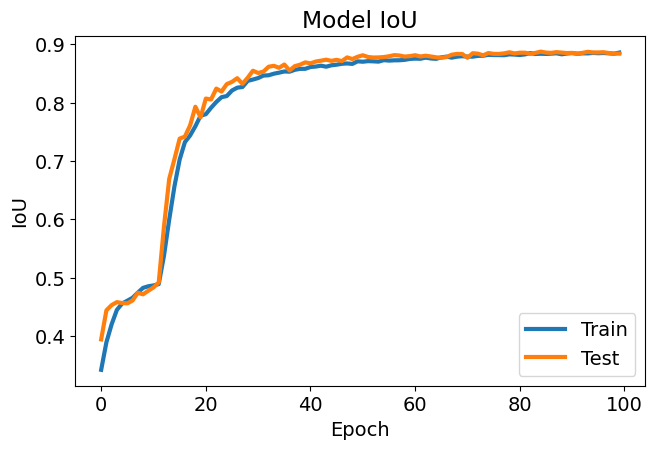

In [22]:
import matplotlib.pyplot as plt
# Adjust font size and line width
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 3
# Plot training & validation IoU values
# Convert list of tensors to list of numpy arrays
train_miou = [x.cpu().numpy() for x in history['train_miou']]
val_miou = [x.cpu().numpy() for x in history['val_miou']]

# Plot training & validation IoU values
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(train_miou)
plt.plot(val_miou)
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


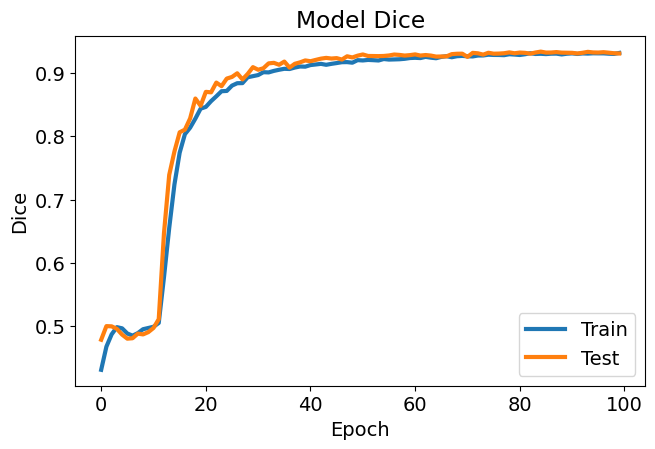

In [23]:
import matplotlib.pyplot as plt
# Adjust font size and line width
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 3
# Plot training & validation IoU values
# Convert list of tensors to list of numpy arrays
train_miou = [x.cpu().numpy() for x in history['train_dice']]
val_miou = [x.cpu().numpy() for x in history['val_dice']]

# Plot training & validation IoU values
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(train_miou)
plt.plot(val_miou)
plt.title('Model Dice')
plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


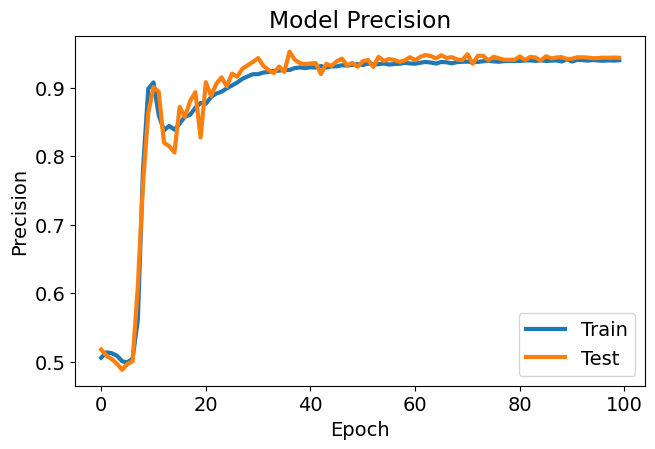

In [24]:
trainX = [x.cpu().numpy() for x in history['train_Precision']]
valX = [x.cpu().numpy() for x in history['val_Precision']]
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(trainX)
plt.plot(valX)
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

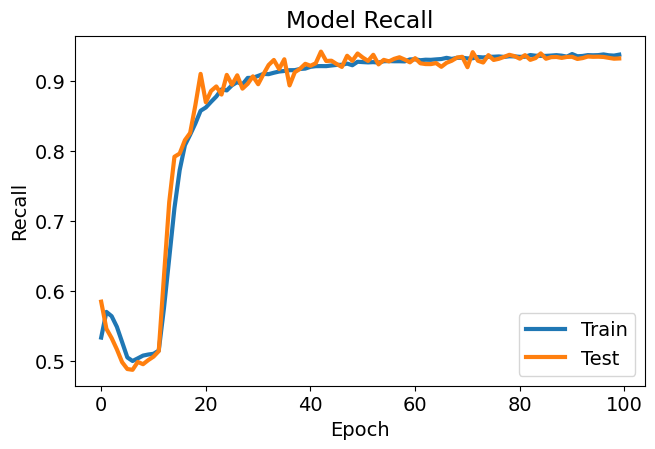

In [25]:
trainX = [x.cpu().numpy() for x in history['train_recall']]
valX = [x.cpu().numpy() for x in history['val_recall']]
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(trainX)
plt.plot(valX)
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

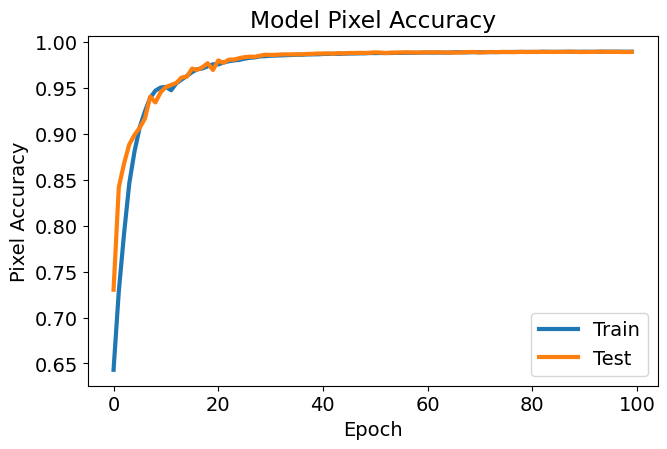

In [26]:
trainX = [x.cpu().numpy() for x in history['train_acc']]
valX = [x.cpu().numpy() for x in history['val_acc']]
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(trainX)
plt.plot(valX)
plt.title('Model Pixel Accuracy')
plt.ylabel('Pixel Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

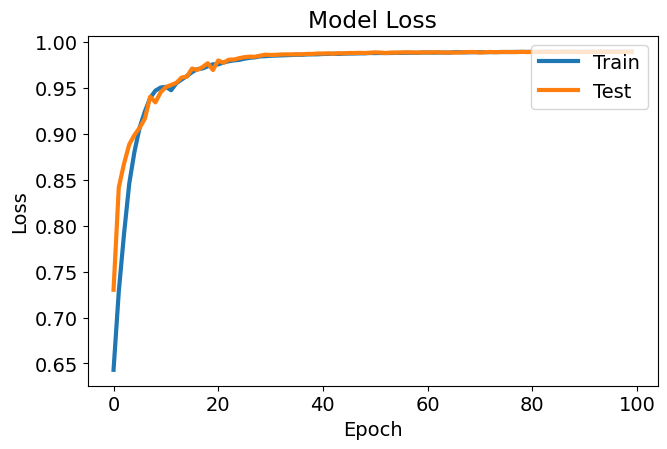

In [27]:
trainX = [x.cpu().numpy() for x in history['train_acc']]
valX = [x.cpu().numpy() for x in history['val_acc']]
plt.figure(figsize=(25, 10))
plt.subplot(2, 3, 1)
plt.plot(trainX)
plt.plot(valX)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

In [28]:
class TestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, Xmask, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.Xmask = Xmask
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path +self.X[idx] + '.TIFF')
        #img[45:64, :] = 0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.Xmask[idx] + '.TIFF', cv2.IMREAD_GRAYSCALE)
        mask=mask/255
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(64, 64, interpolation=cv2.INTER_NEAREST)
test_set = TestDataset(IMAGE_PATH, MASK_PATH, X_test,X_test_mask, transform=t_test)

In [29]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [30]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [31]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [32]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [33]:
def predict_image_mask_dice(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = dice_score(output, mask)  # Compute Dice score
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def dice_score_model(model, test_set):
    score_dice = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_dice(model, img, mask)  # Use the new function
        score_dice.append(score)
    return score_dice

In [34]:
mob_miou = miou_score(model, test_set)
dice_miou = dice_score_model(model, test_set)
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

100%|██████████| 456/456 [00:02<00:00, 164.76it/s]


y_true shape: (1867776,)
y_pred shape: (1867776,)
y_score shape: (1867776,)


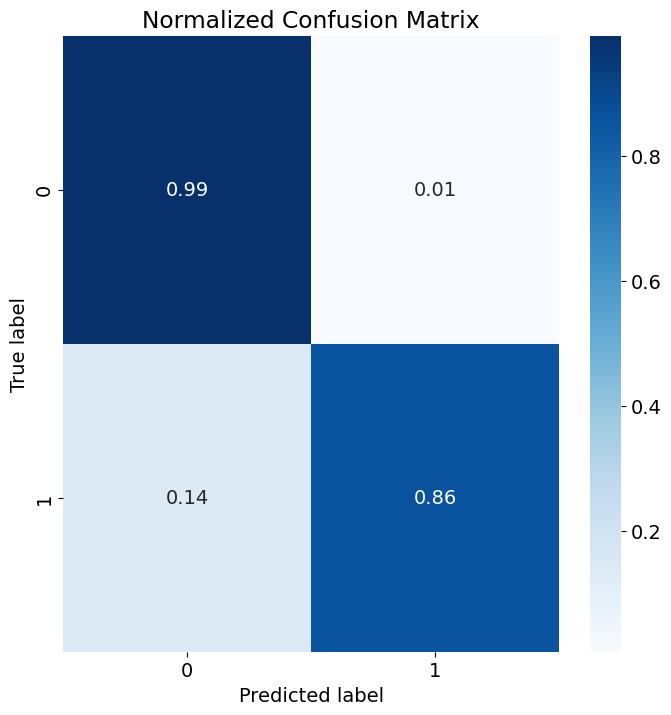

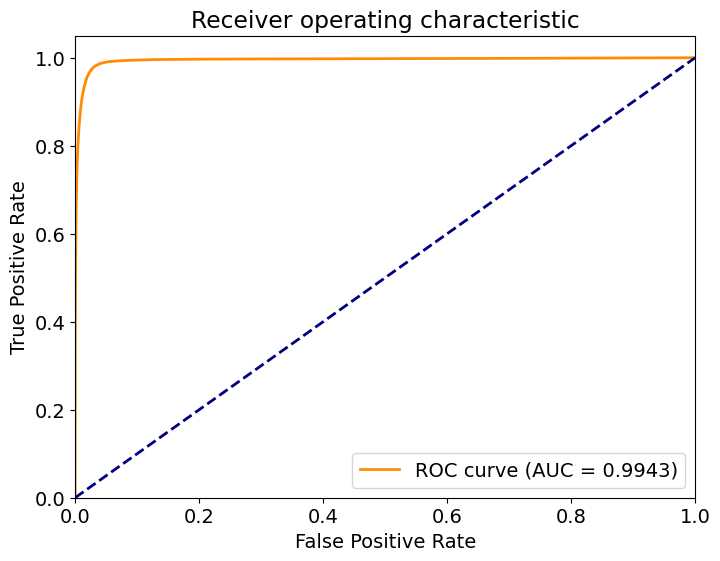

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms as T
from itertools import cycle

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# ROC Curve for binary classification
def plot_binary_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model and plot confusion matrix and ROC curve
def evaluate_model_binary_roc(model, test_set):
    y_true = []
    y_pred = []
    y_score = []

    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]

        # Convert image to tensor
        t = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        img = t(img)

        img = img.to(device)
        mask = mask.to(device)

        model.eval()
        with torch.no_grad():
            img = img.unsqueeze(0)
            output = model(img)
            prob = F.softmax(output, dim=1).cpu().numpy()
            pred = torch.argmax(output, dim=1).cpu().numpy().squeeze()

        y_true.extend((mask.cpu().numpy().flatten() == 1).astype(int))  # Transform to binary (1 vs. others)
        y_pred.extend((pred.flatten() == 1).astype(int))  # Transform to binary (1 vs. others)
        y_score.extend(prob[:, 1].flatten())  # Use probability of class 1

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score).flatten()

    # Ensure y_score is flattened correctly
    if y_score.ndim == 2:
        y_score = y_score.flatten()

    # Debugging shapes
    print(f'y_true shape: {y_true.shape}')
    print(f'y_pred shape: {y_pred.shape}')
    print(f'y_score shape: {y_score.shape}')

    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, classes=['0', '1'], normalize=True, title='Normalized Confusion Matrix')

    # Plot ROC Curve
    plot_binary_roc_curve(y_true, y_score)

# Example usage:
test_set = TestDataset(IMAGE_PATH, MASK_PATH, X_test, X_test_mask, transform=t_test)
evaluate_model_binary_roc(model, test_set)


In [35]:
print(np.mean(mob_miou))
print(np.mean(dice_miou))
print(np.mean(mob_acc))

0.8767519048936565
0.9273770471835922
0.9872227718955592


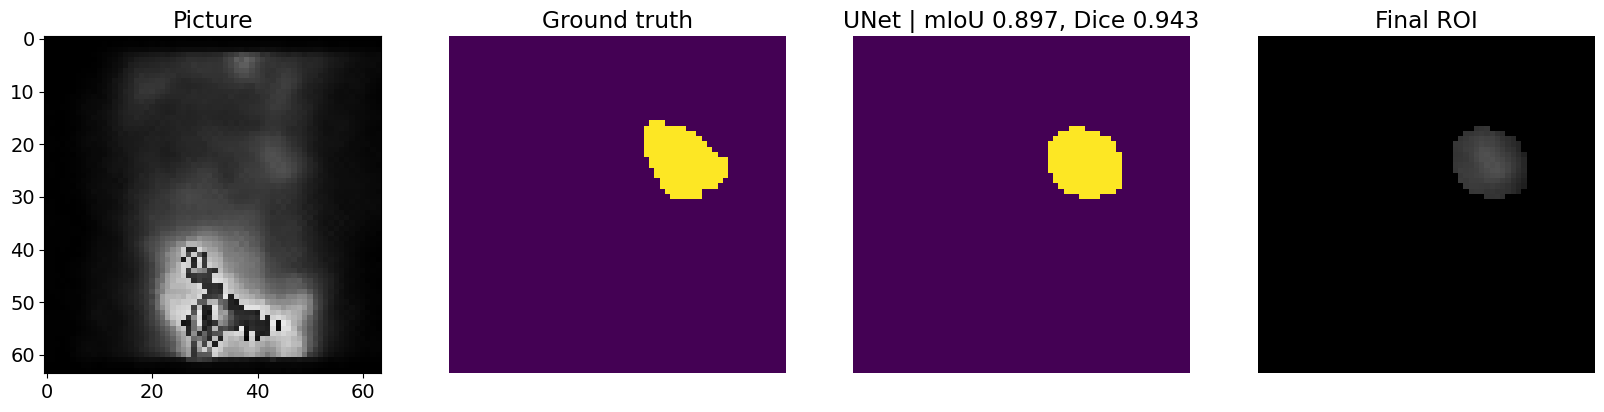

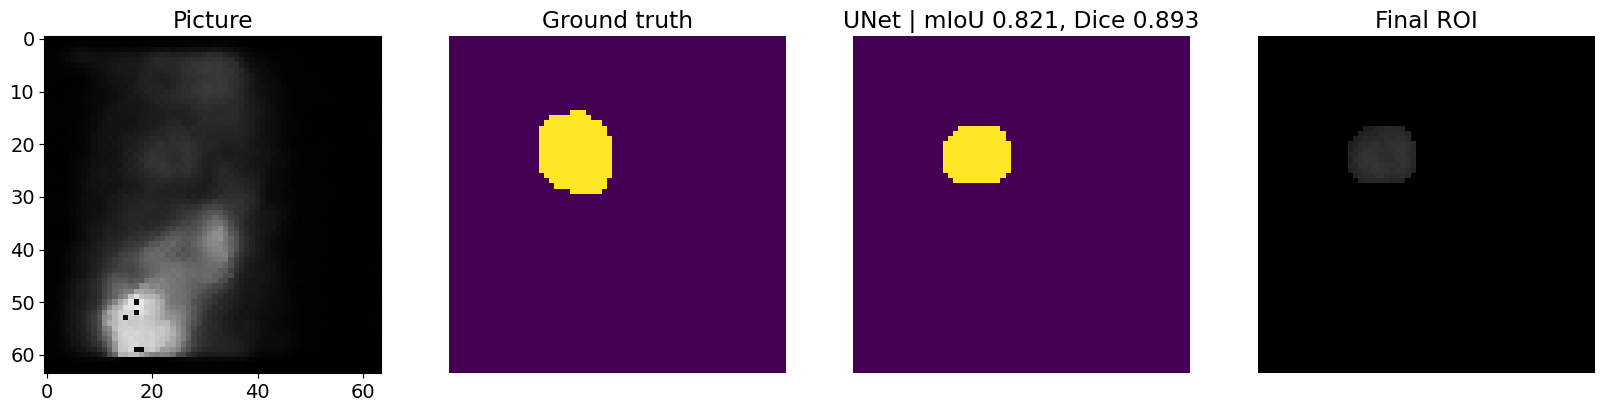

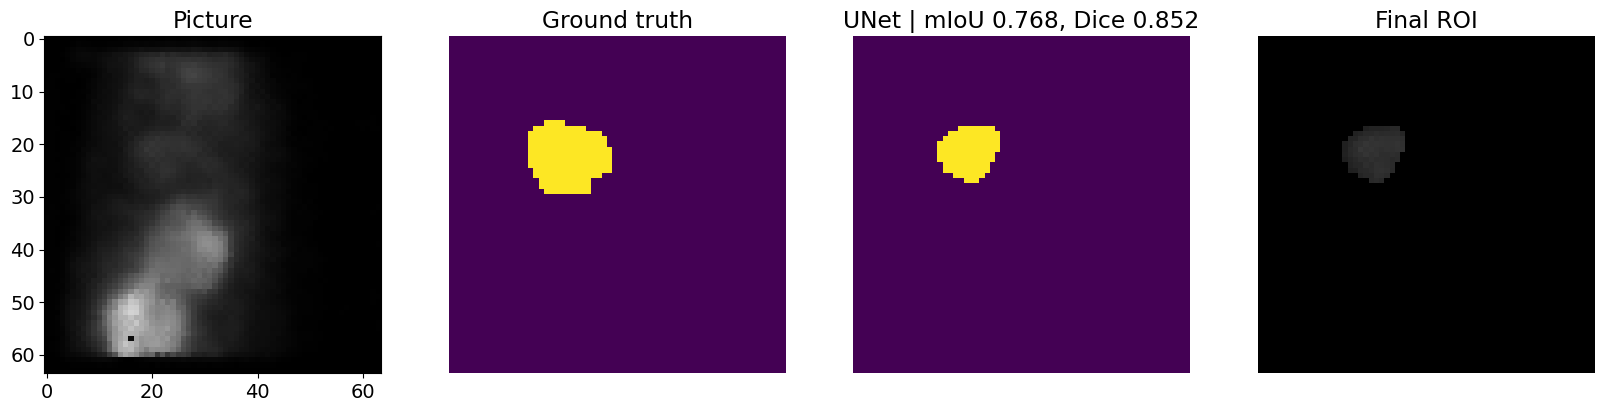

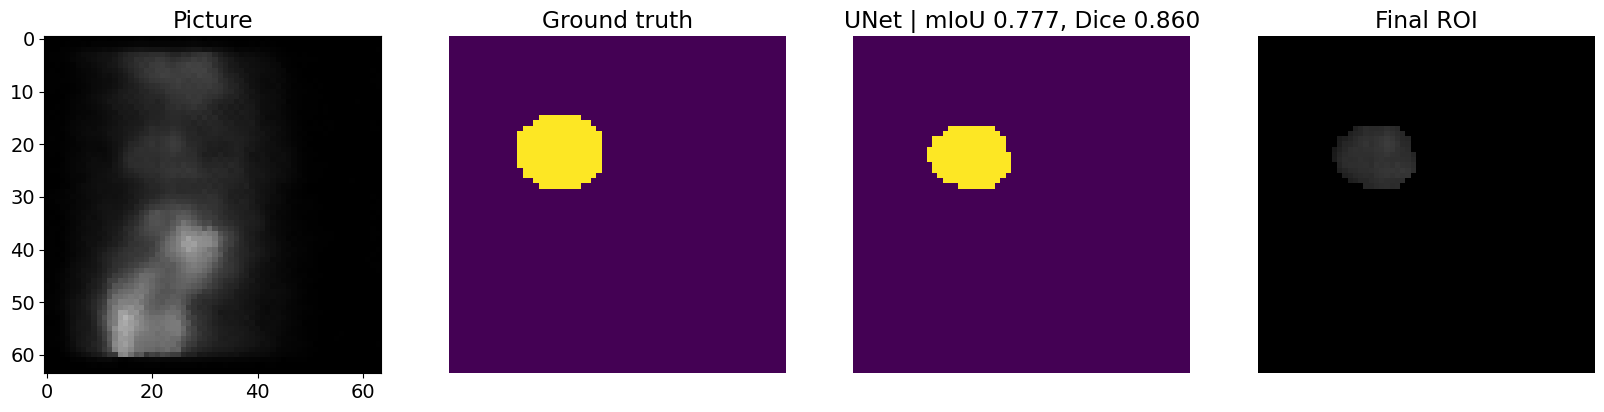

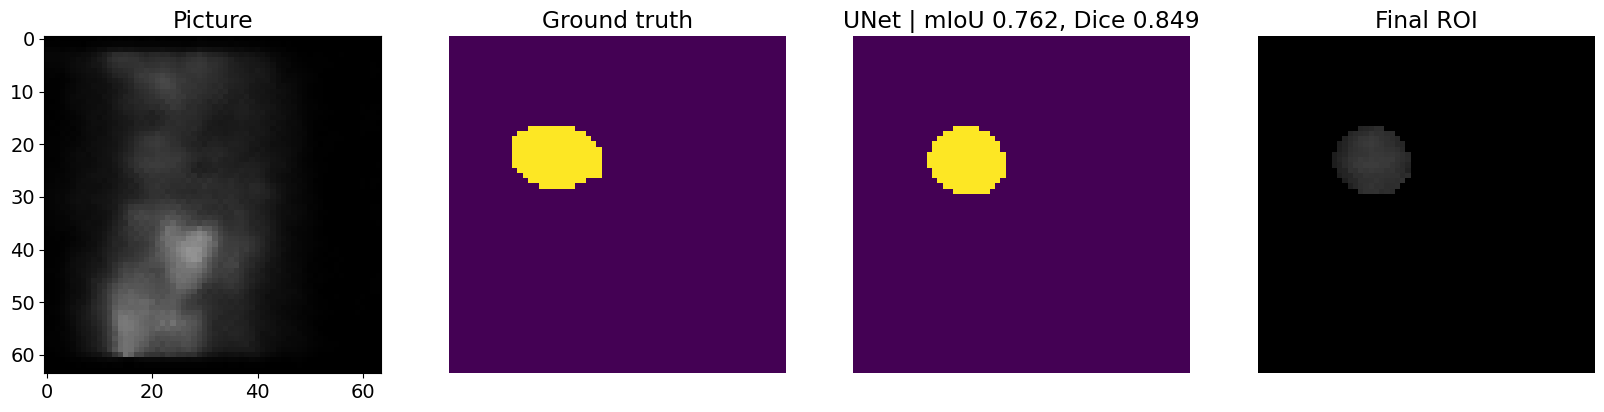

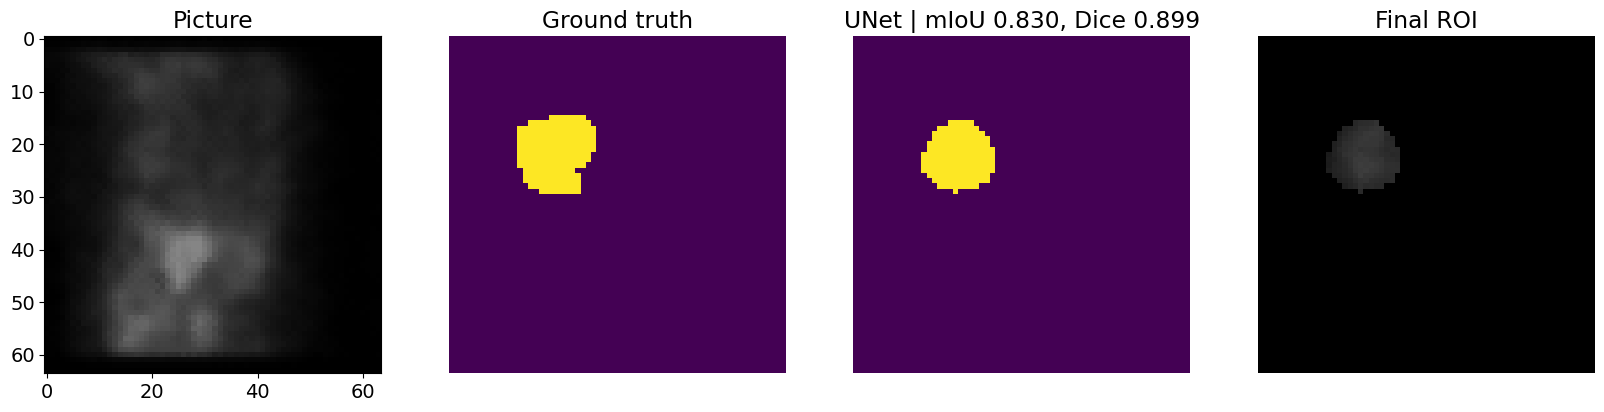

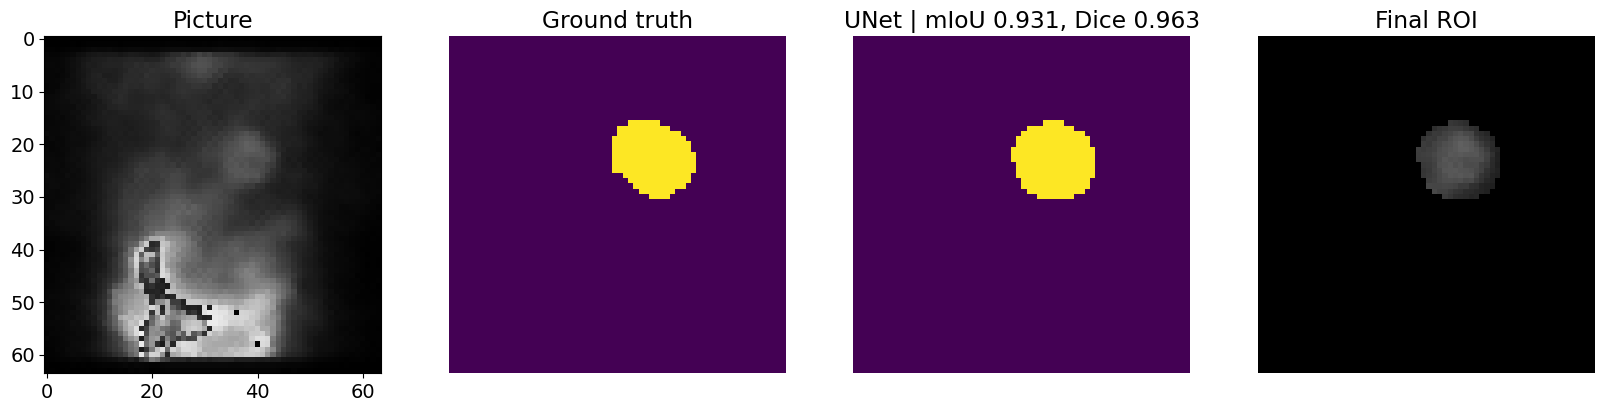

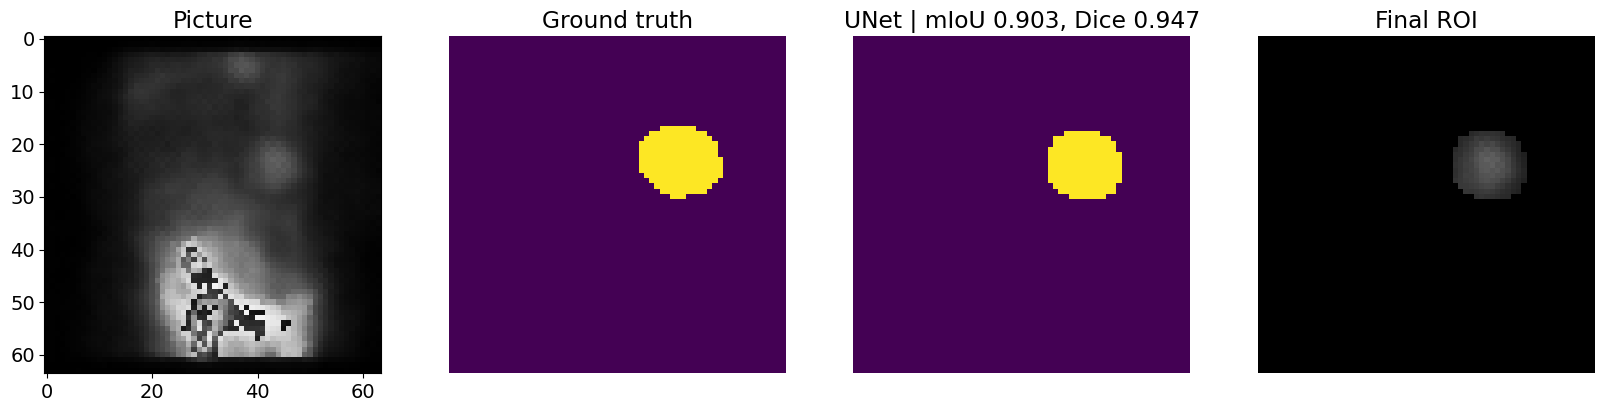

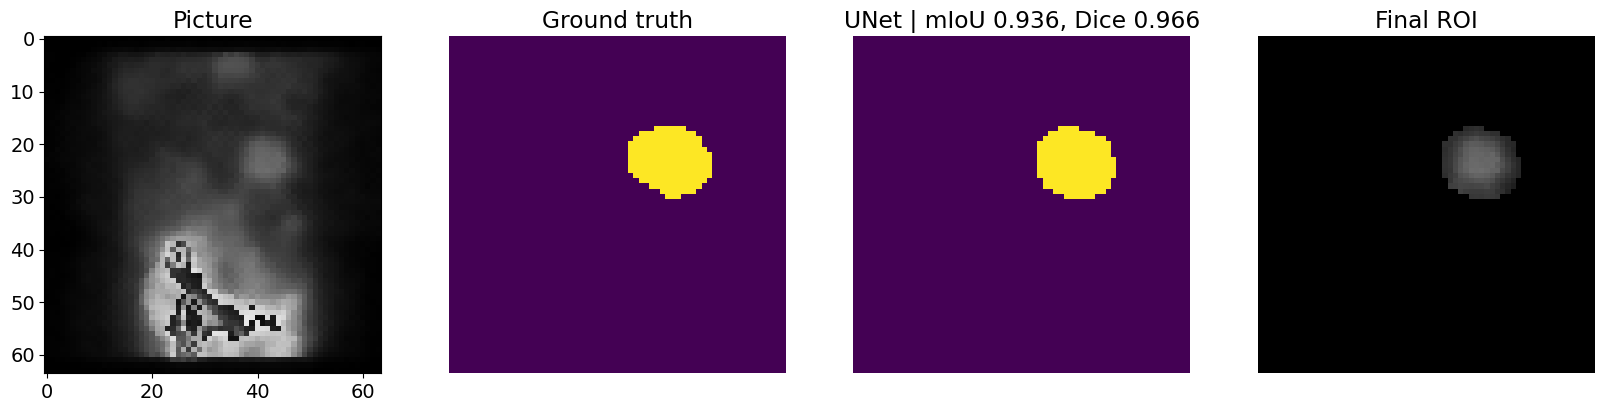

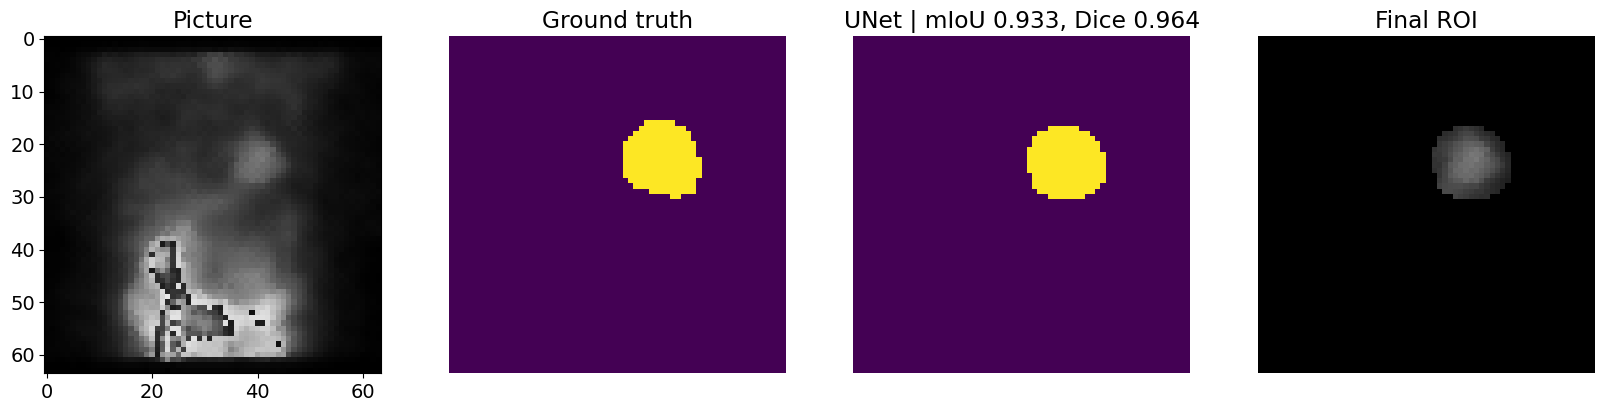

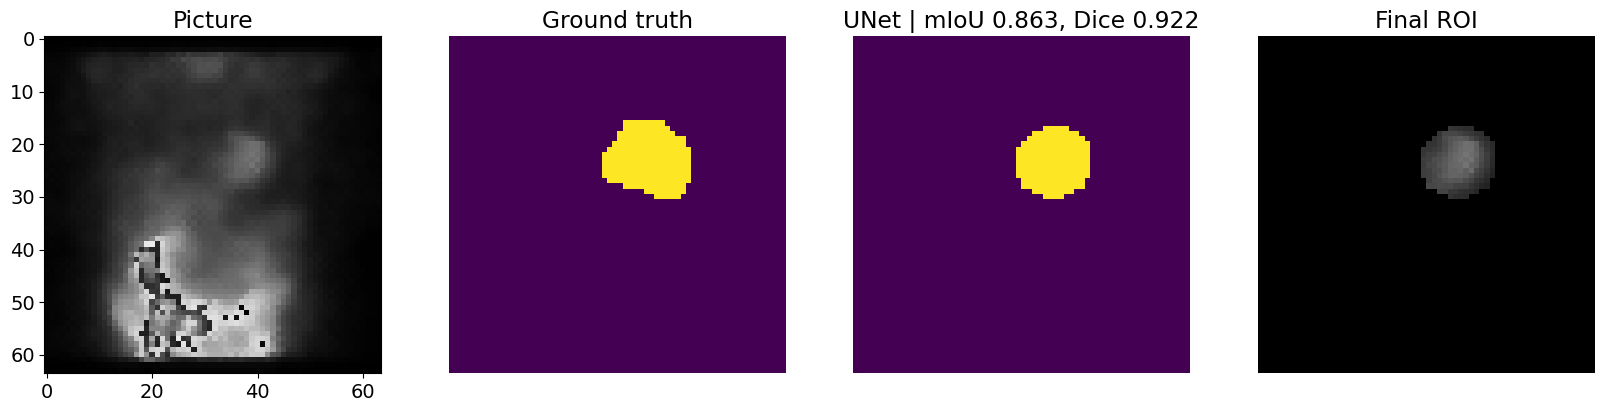

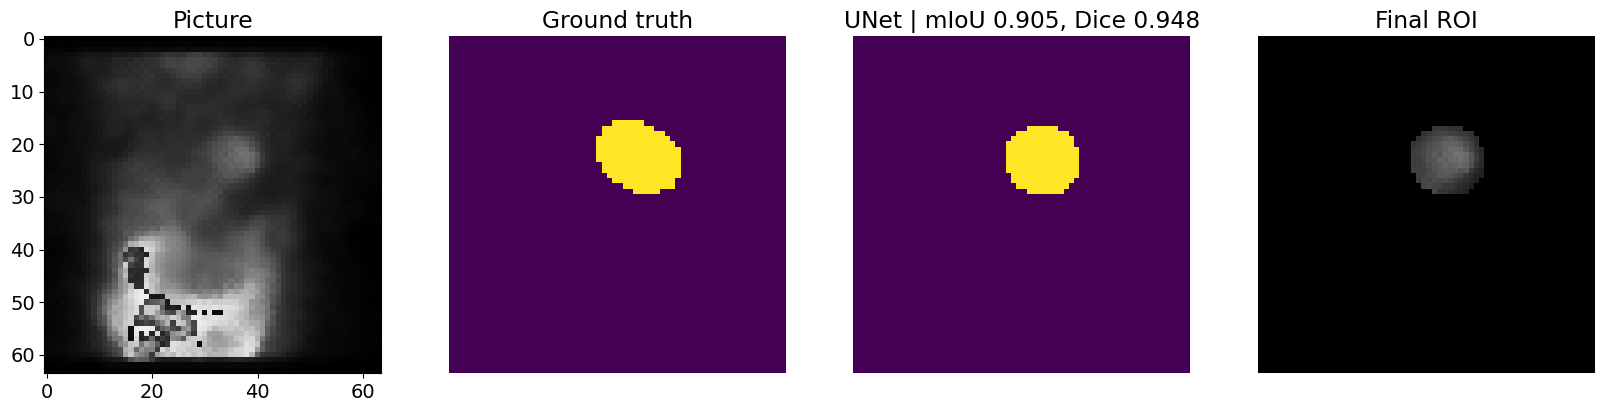

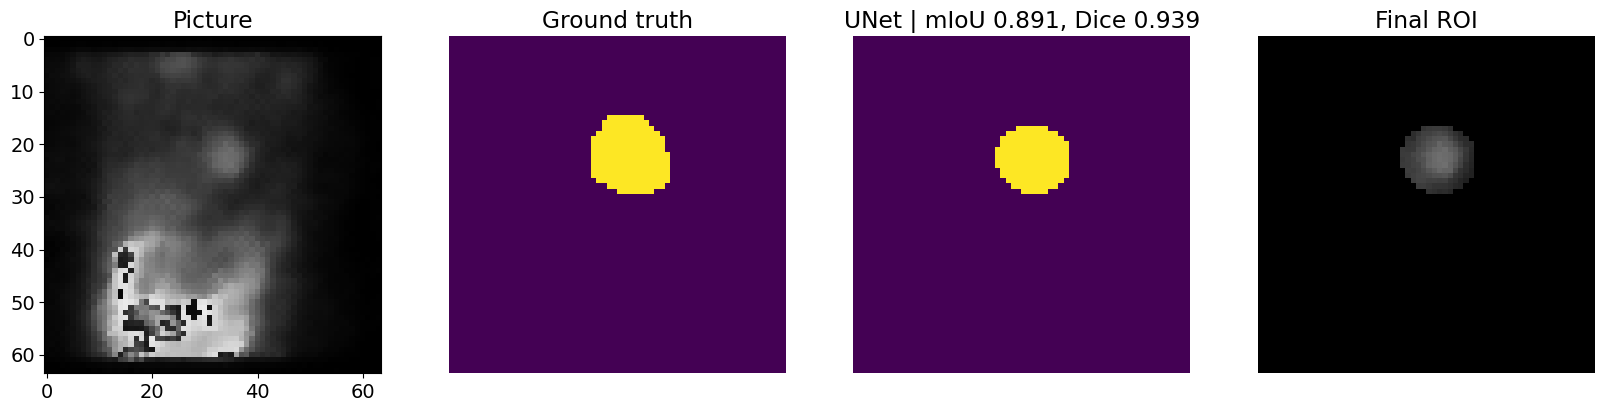

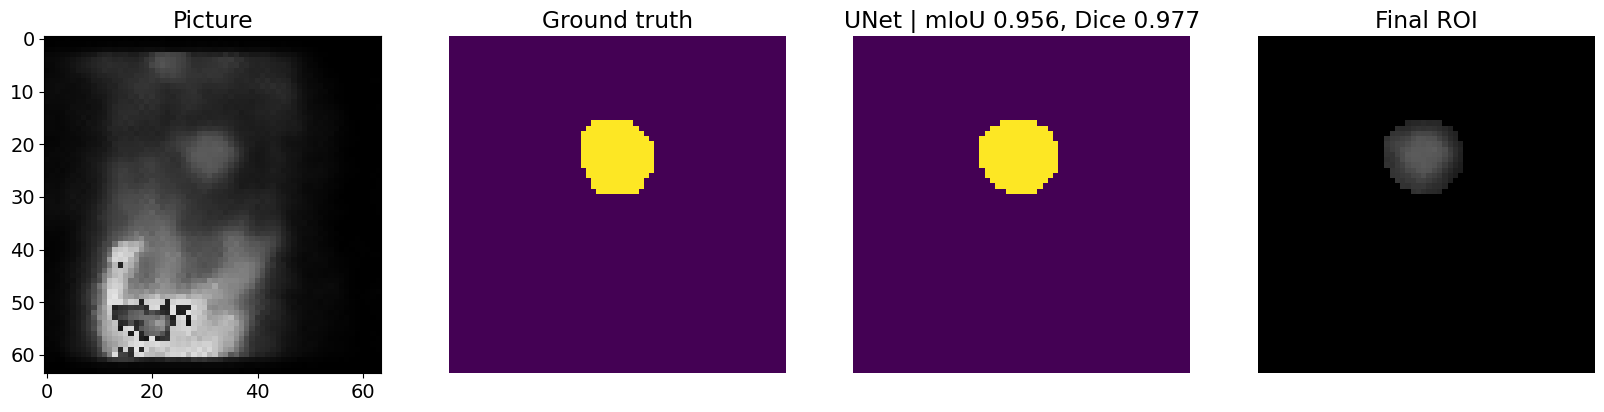

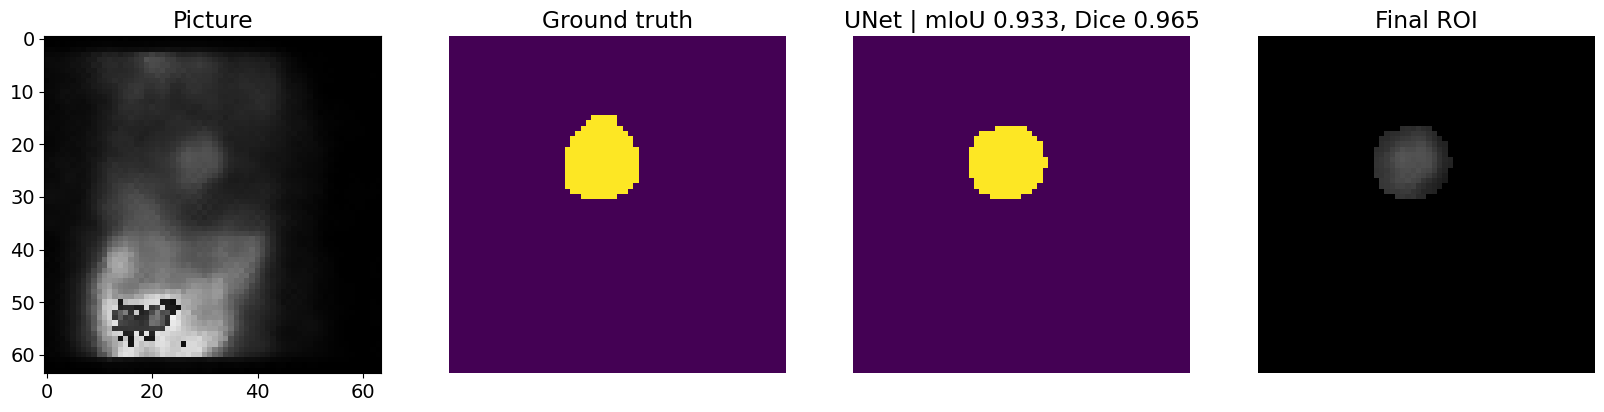

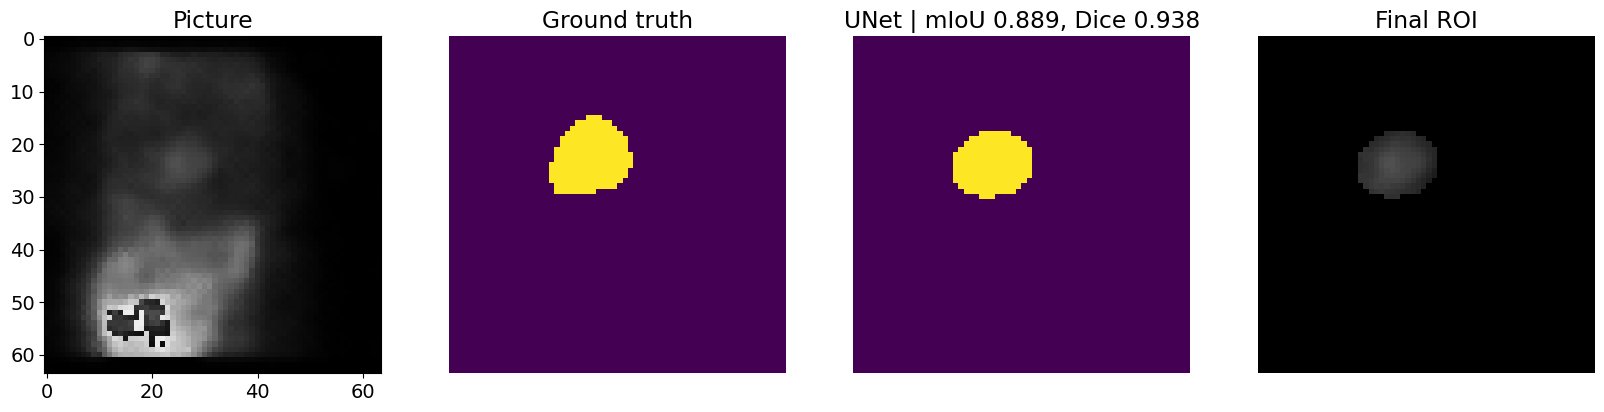

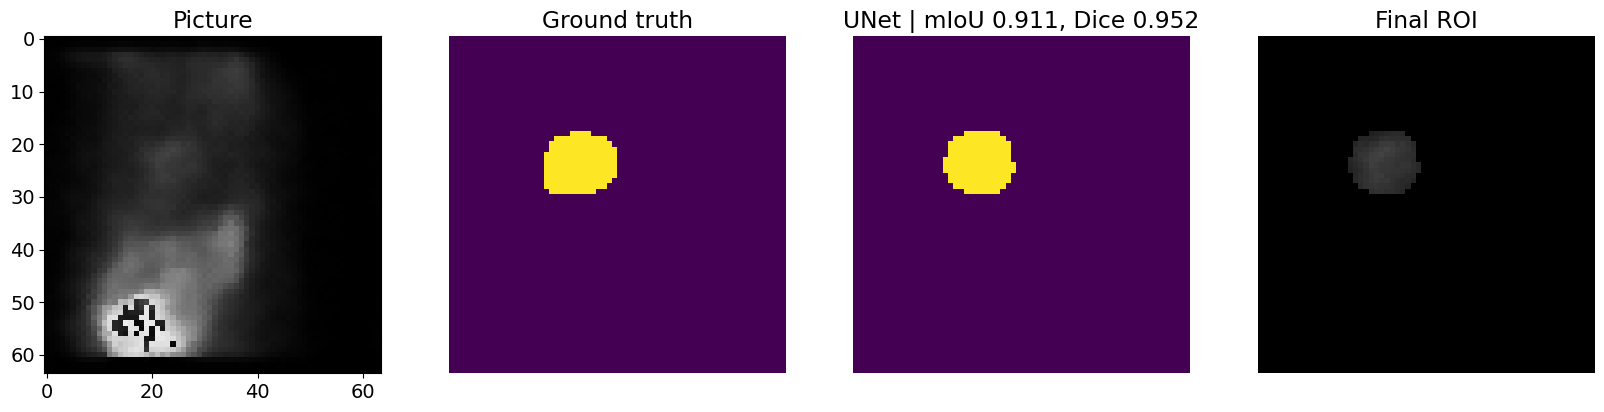

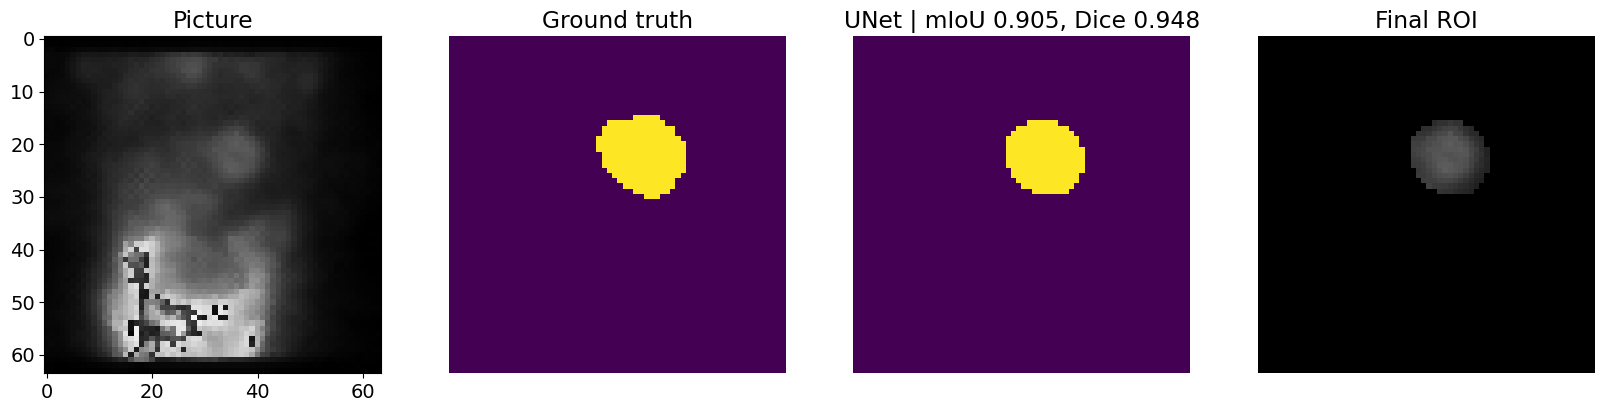

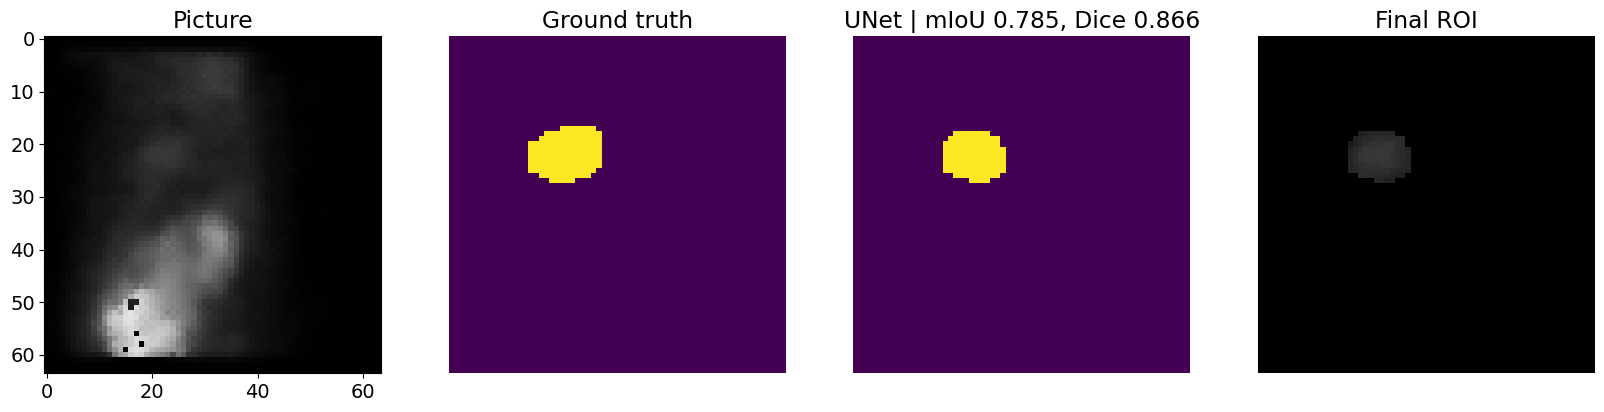

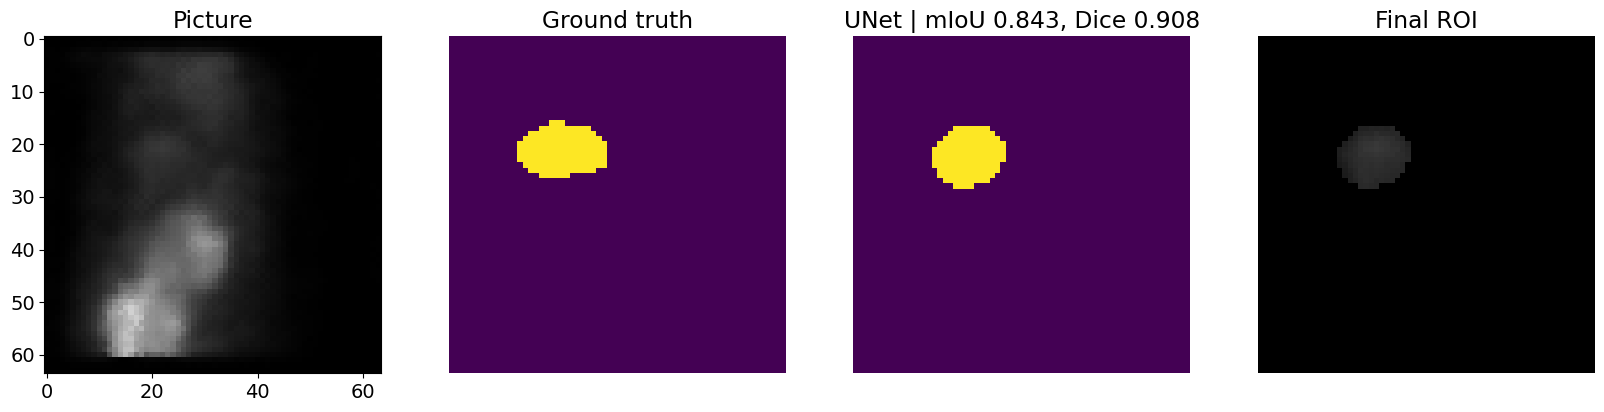

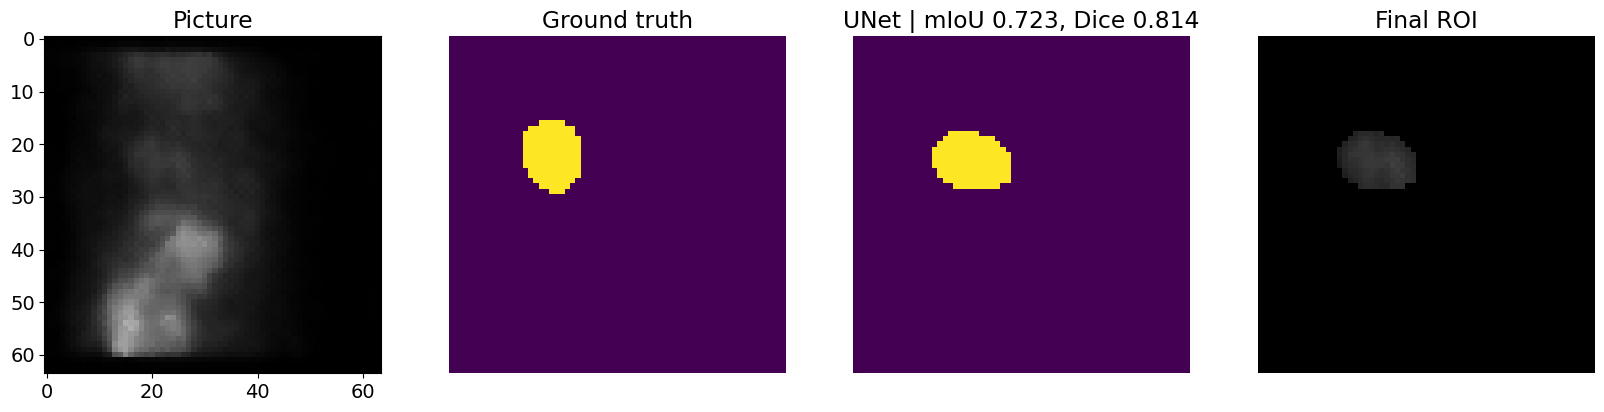

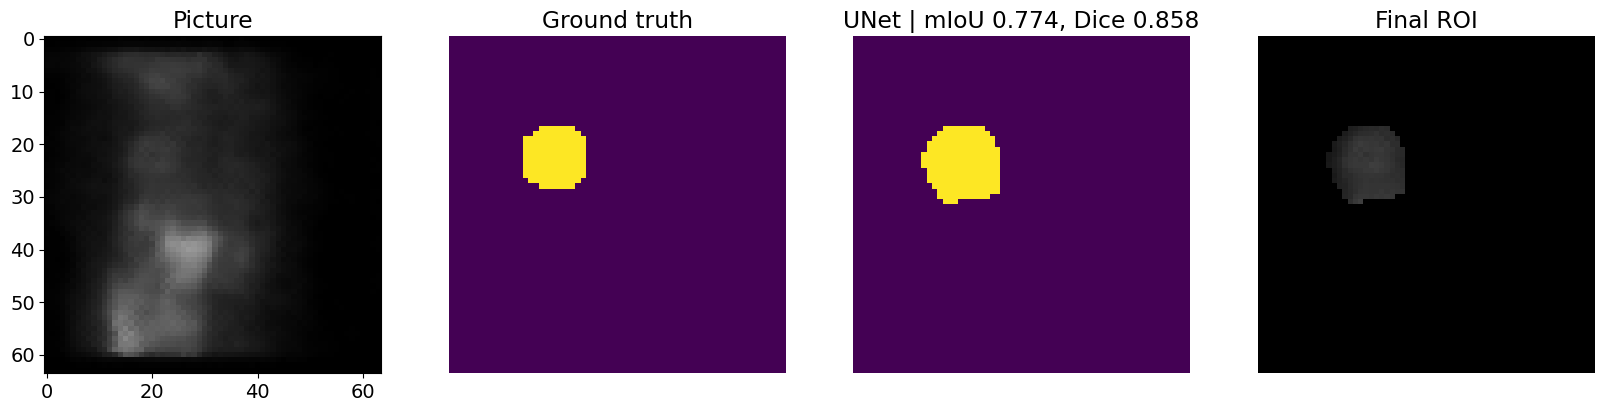

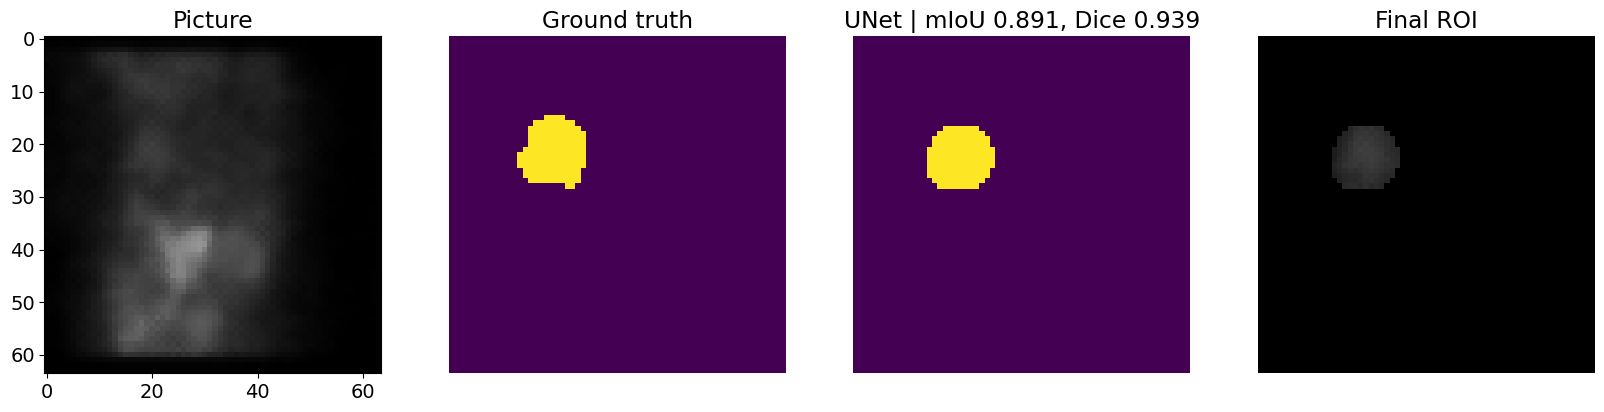

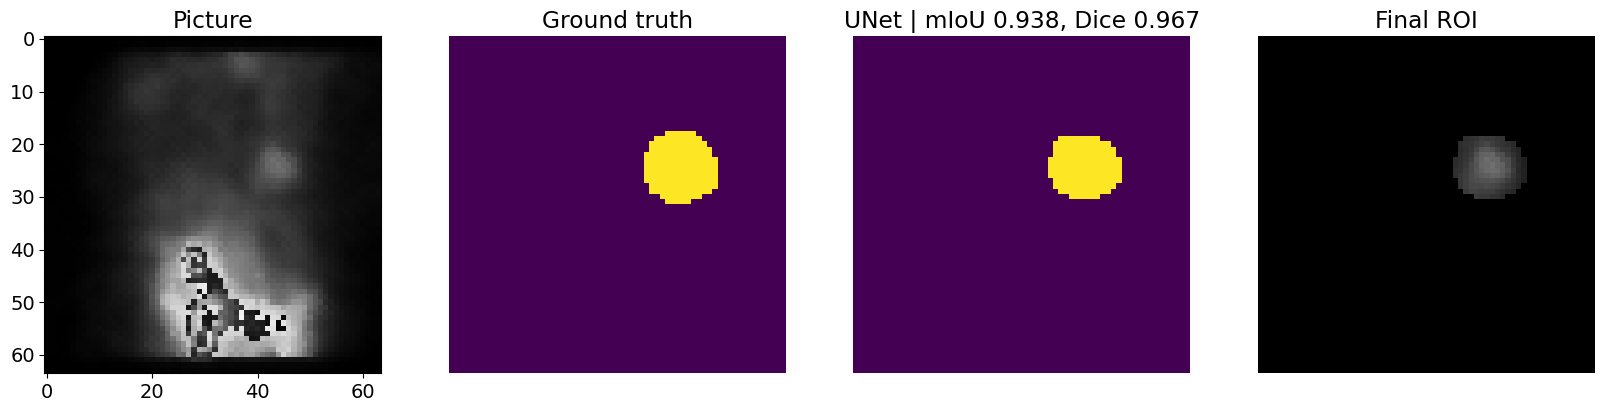

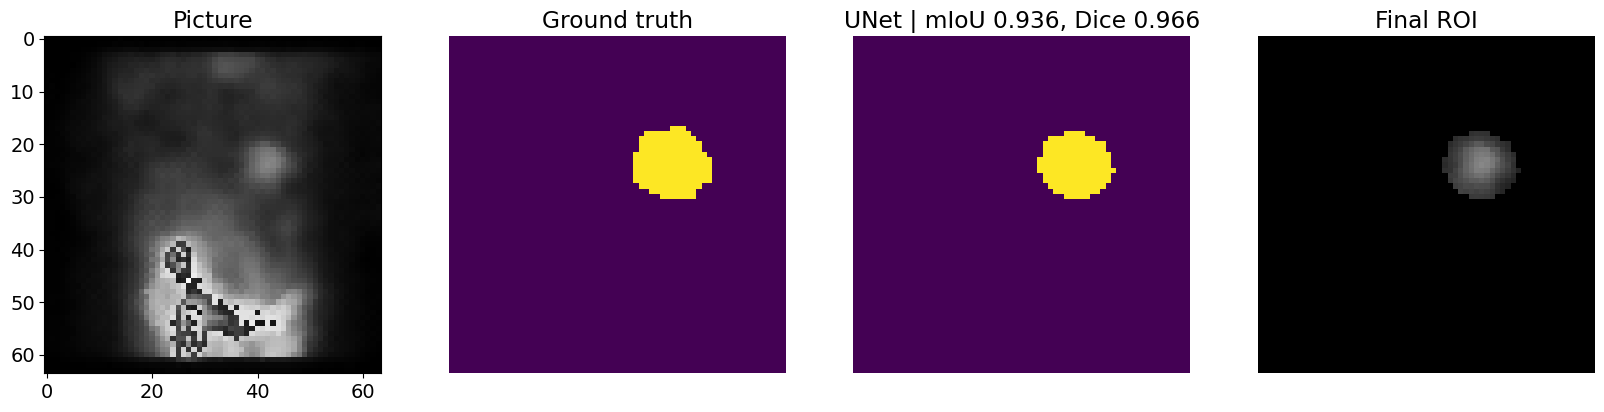

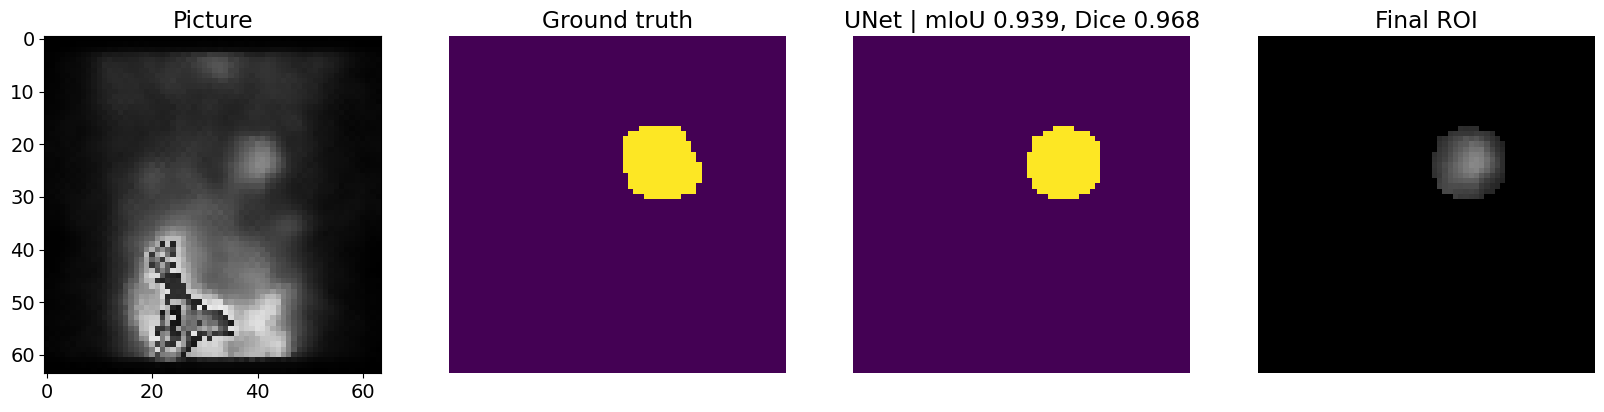

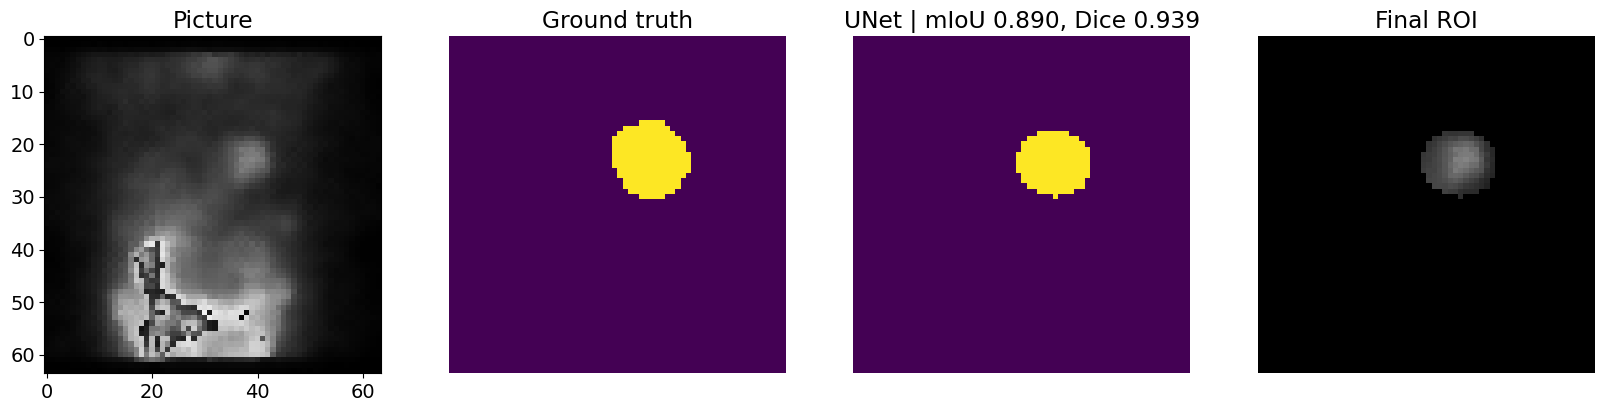

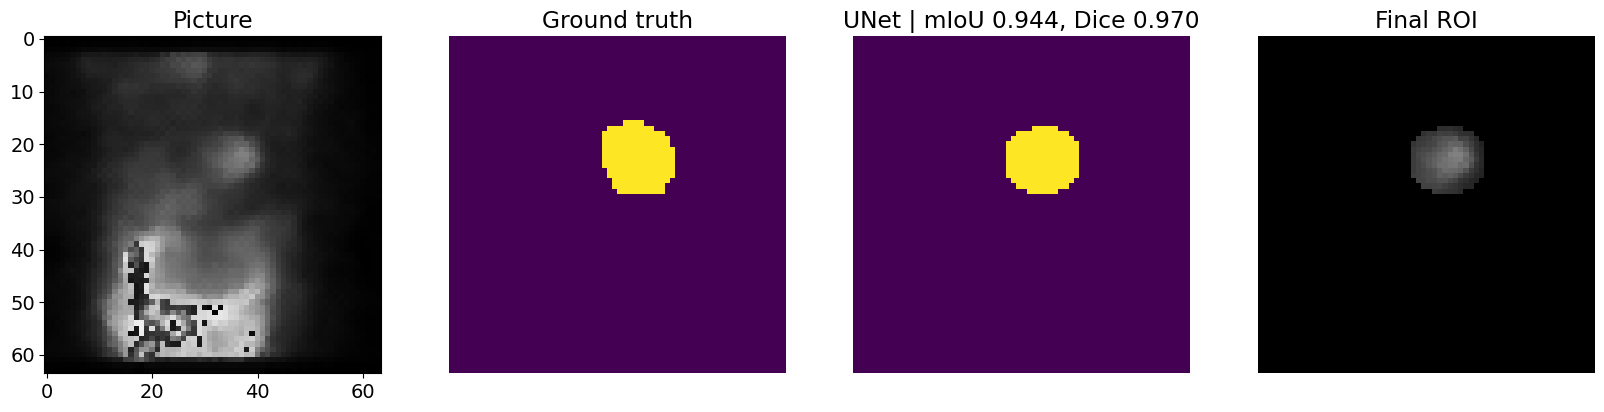

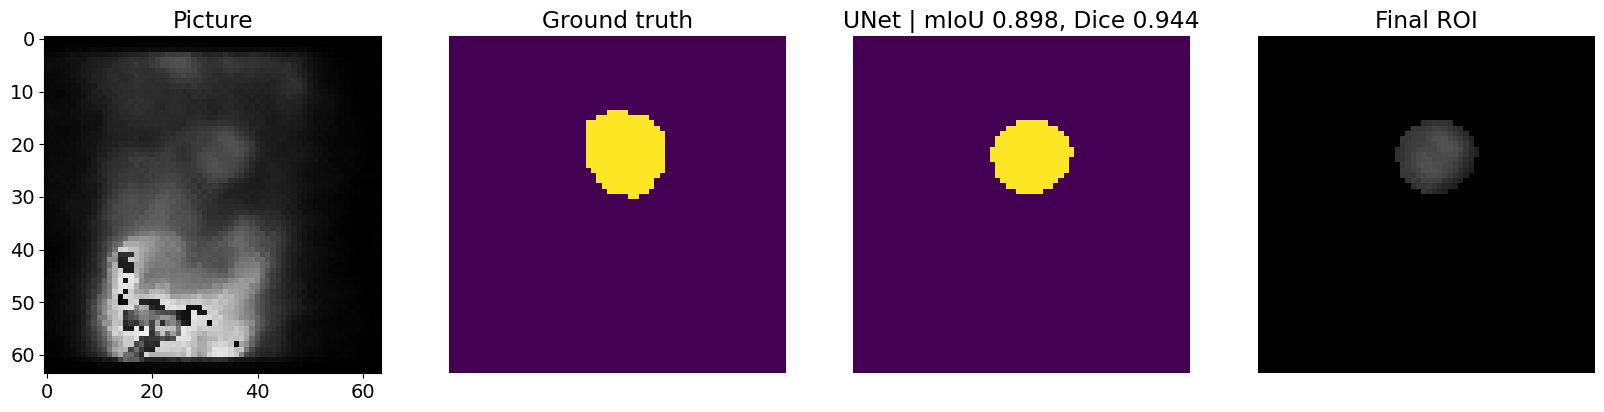

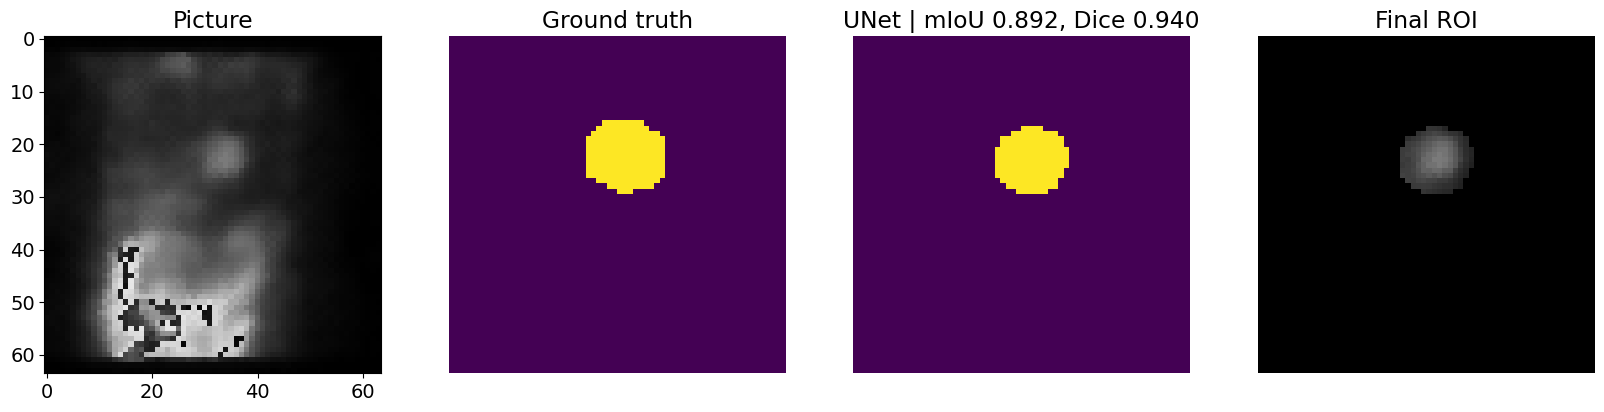

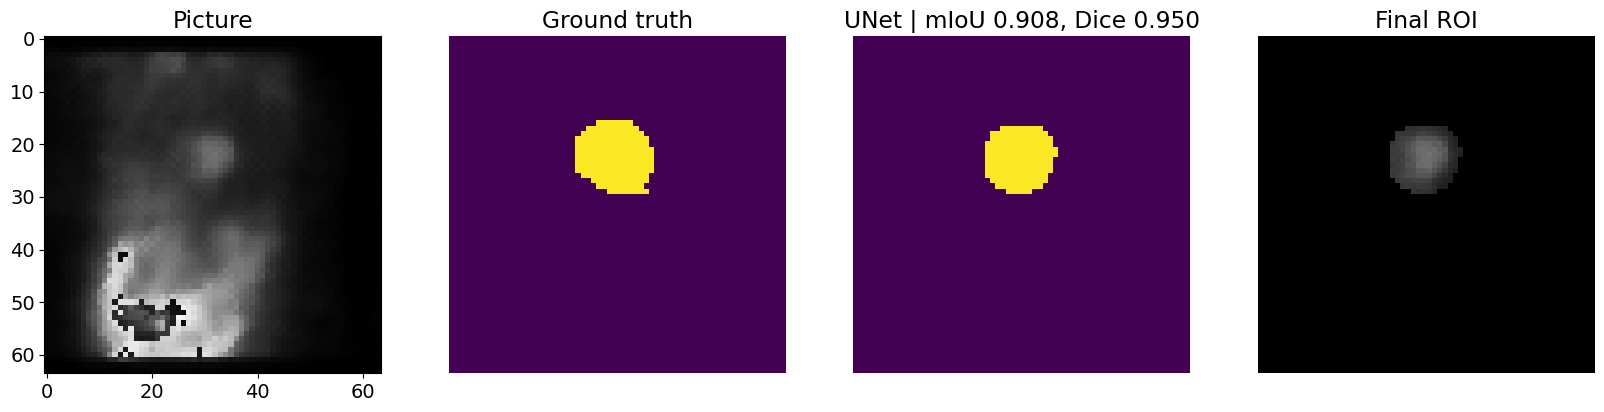

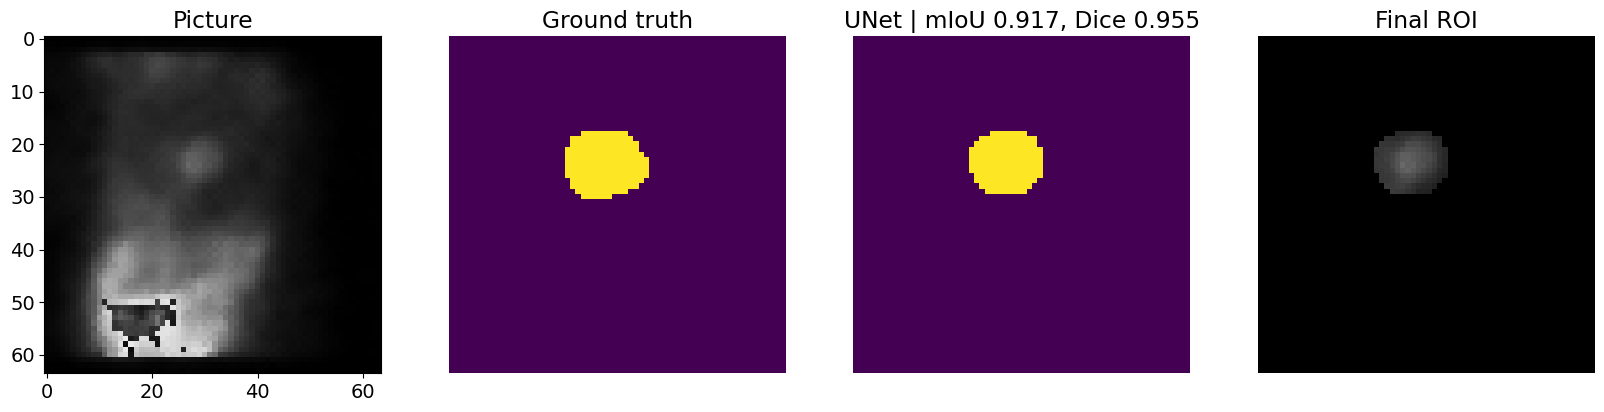

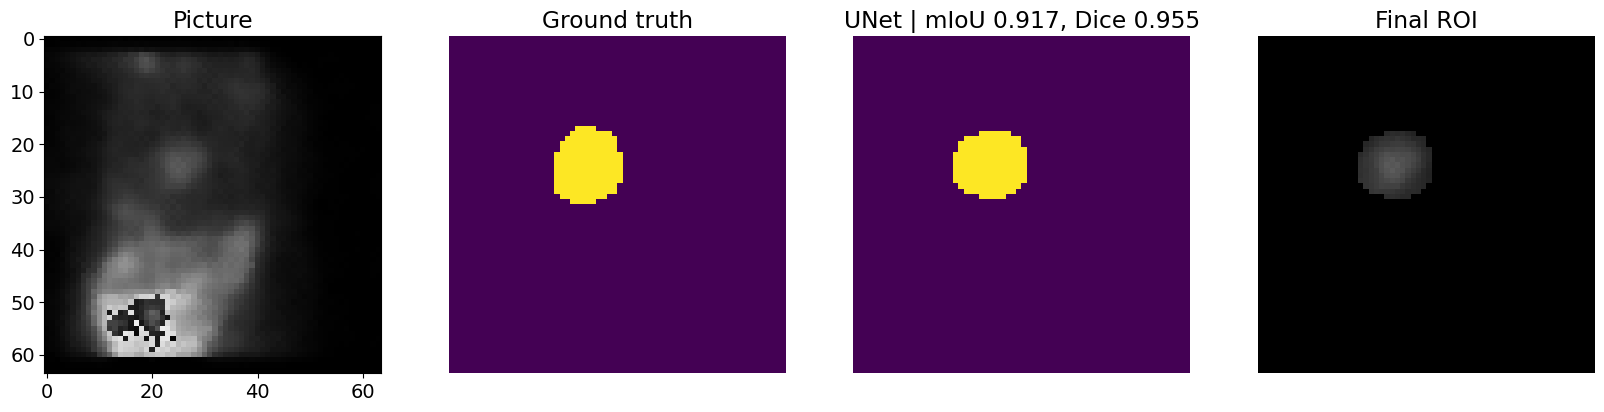

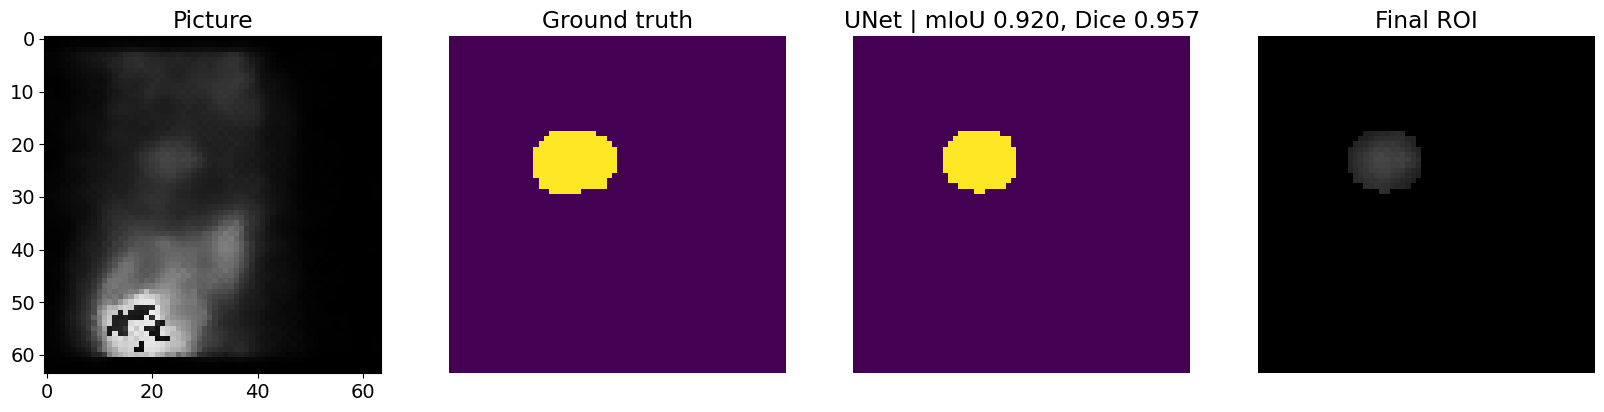

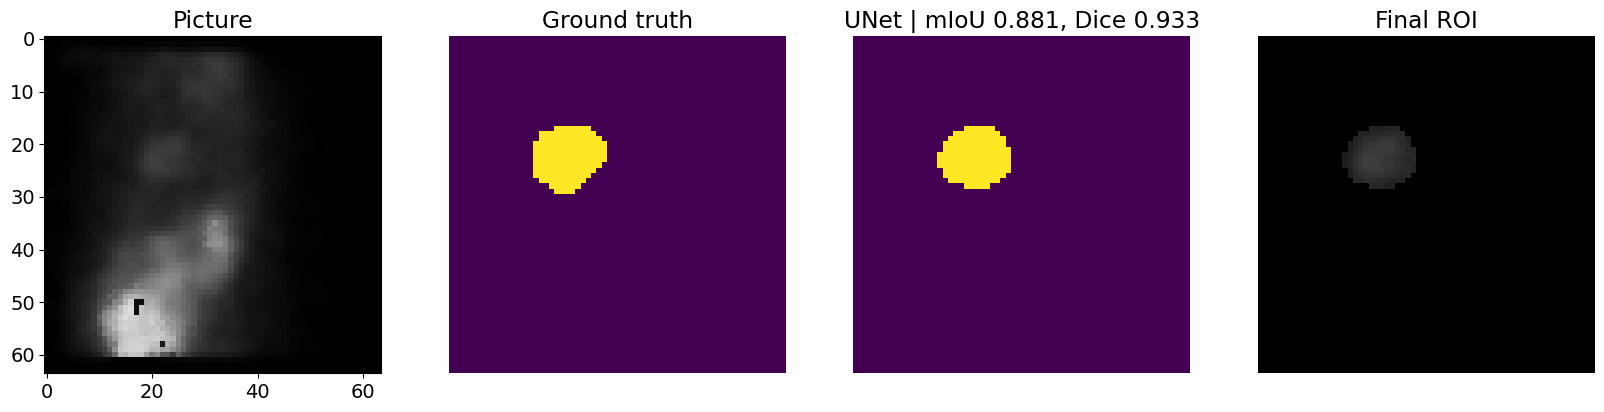

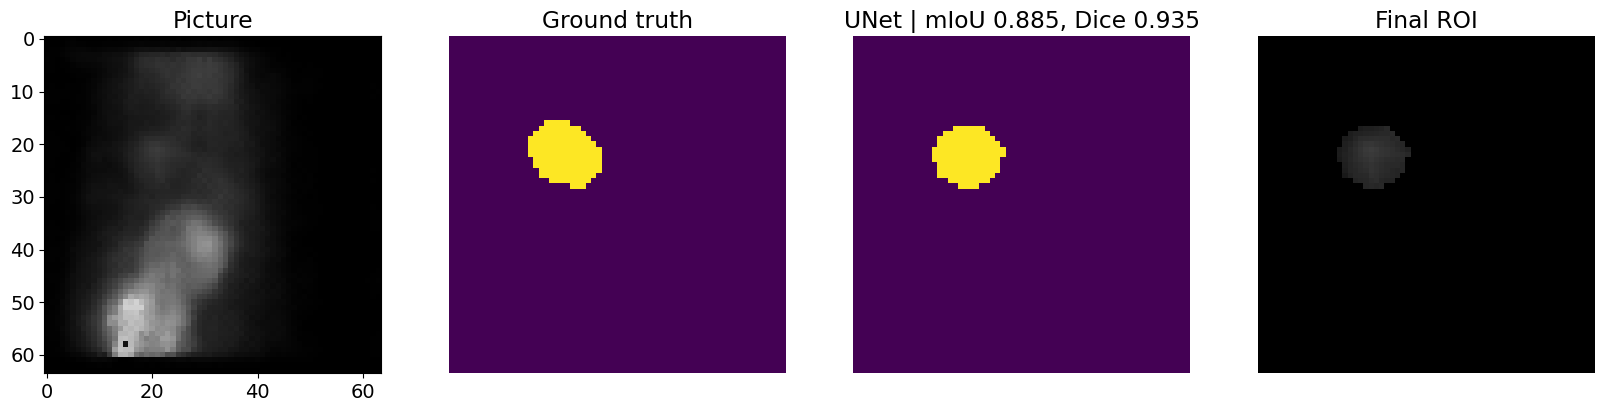

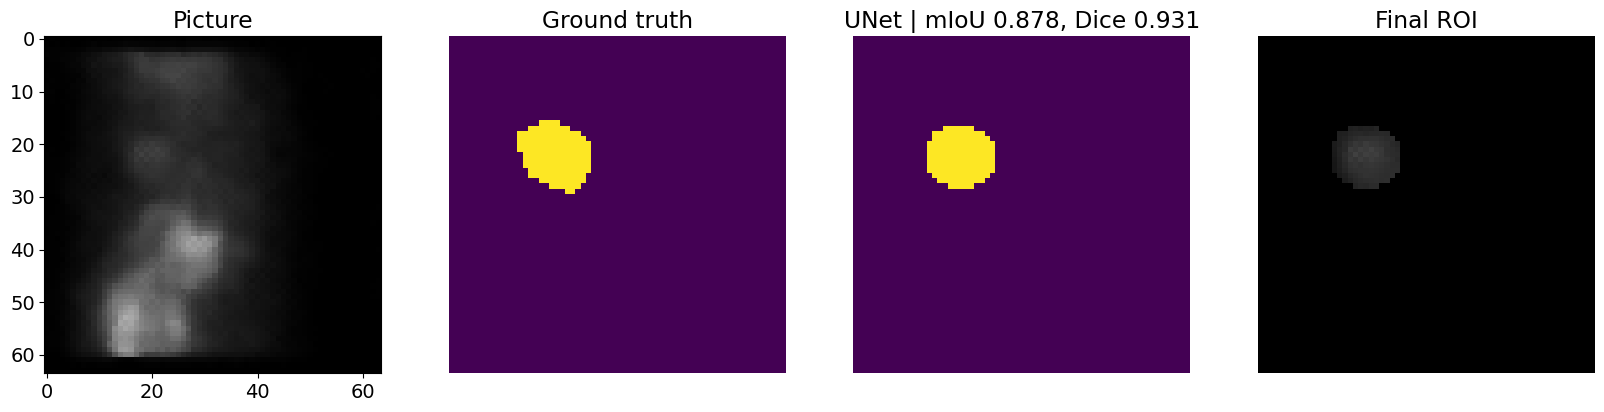

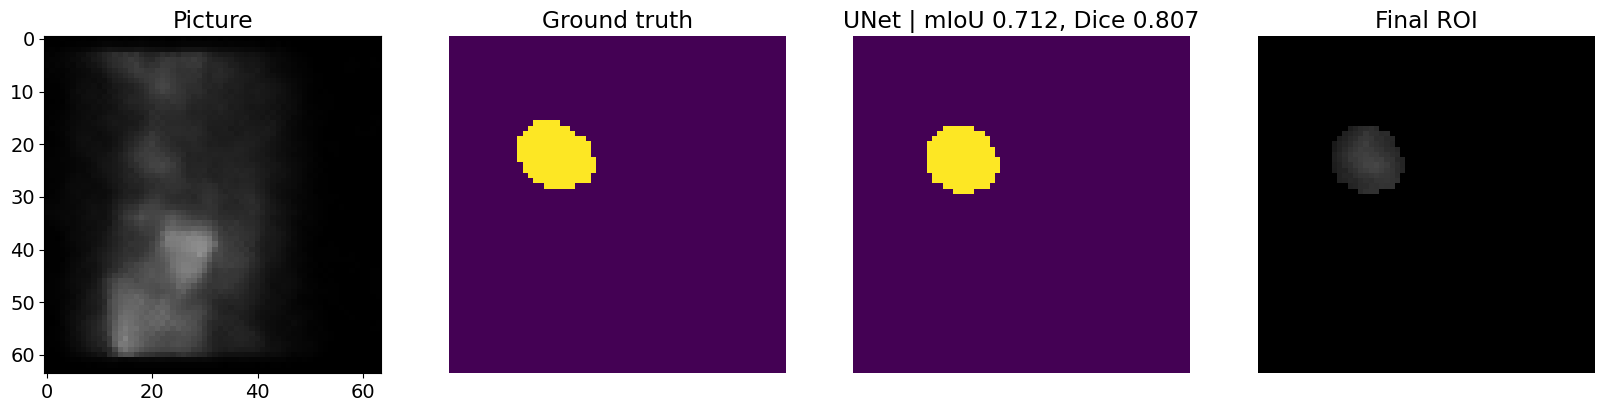

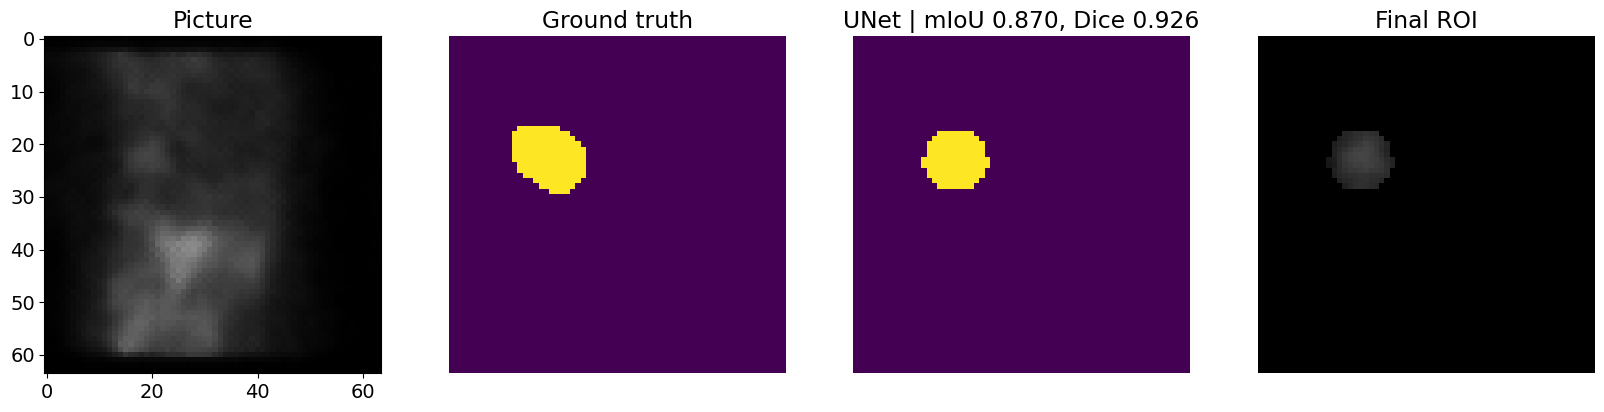

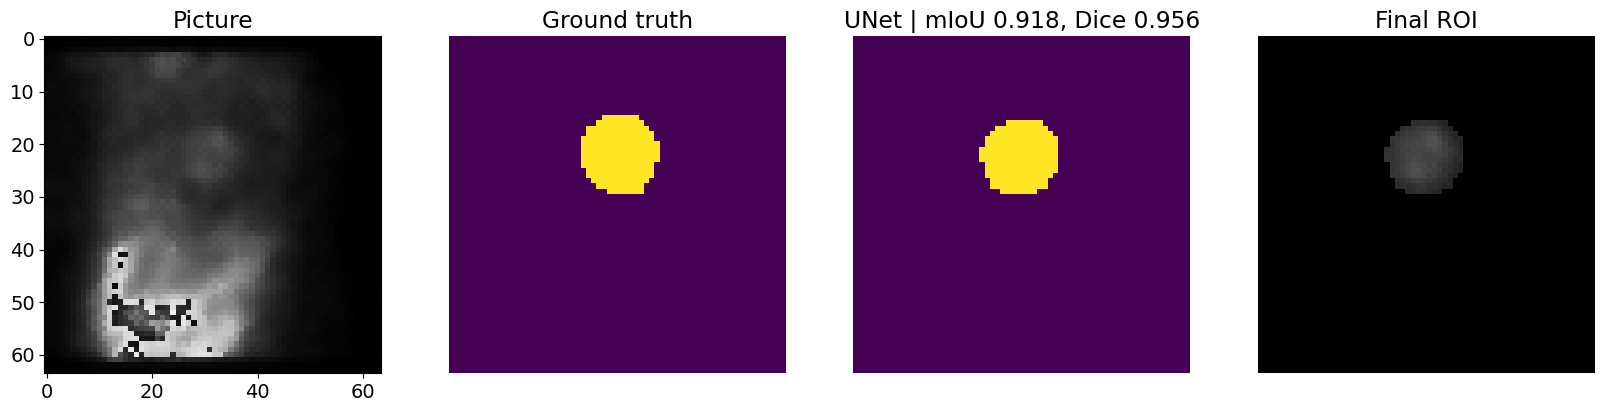

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

# Function to filter out small regions and keep only the largest connected component
def filter_largest_component(mask):
    # Convert the mask to a binary image
    binary_mask = (mask > 0).astype(np.uint8)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    # Keep the largest component (excluding the background)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create a mask with only the largest component
    largest_component_mask = (labels == largest_label).astype(np.uint8)
    return largest_component_mask

# Function to plot results
def plot_results(image, mask, filtered_pred_mask, score, Dscore):
    # Convert the PIL Image to a PyTorch Tensor
    image_tensor = transforms.ToTensor()(image)

    # Ensure the mask is on the same device as the image tensor
    filtered_pred_mask_tensor = torch.tensor(filtered_pred_mask, device=image_tensor.device)

    # Apply the mask to the image tensor
    masked_image = image_tensor * filtered_pred_mask_tensor.unsqueeze(0)

    # Now, let's add the masked image to the plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))  # Create 4 subplots

    ax1.imshow(image_tensor.permute(1, 2, 0), cmap='gray')  # Permute the tensor dimensions to match the expected input of imshow
    ax1.set_title('Picture')

    ax2.imshow(mask, cmap='viridis')
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(filtered_pred_mask, cmap='viridis')
    ax3.set_title('UNet | mIoU {:.3f}'.format(score) + ', Dice {:.3f}'.format(Dscore))
    ax3.set_axis_off()

    ax4.imshow(masked_image.permute(1, 2, 0), cmap='gray')  # Permute the tensor dimensions to match the expected input of imshow
    ax4.set_title('Final ROI')
    ax4.set_axis_off()

    plt.show()

# Loop through images
for i in range(40):
    image, mask = test_set[i]
    pred_mask, Dscore = predict_image_mask_dice(model, image, mask)
    pred_mask, score = predict_image_mask_miou(model, image, mask)

    # Convert the predicted mask to numpy array if it is a tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Filter out small regions and keep only the largest component
    filtered_pred_mask = filter_largest_component(pred_mask)

    # Plot results
    plot_results(image, mask, filtered_pred_mask, score, Dscore)
